In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio

import nibabel as nib



In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 116]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask

In [3]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="PED_Sliced/sagittal/t1c", t2f_dir="PED_Sliced/sagittal/t2f", seg_dir="PED_Sliced/sagittal/seg", transforms=data_transforms)

In [4]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [5]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)



4974
156
Data shape: torch.Size([32, 2, 240, 155])
Labels shape: torch.Size([32, 240, 155])
Data shape: torch.Size([32, 2, 240, 155])
Labels shape: torch.Size([32, 240, 155])


In [6]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(F.relu(g1 + x1, inplace=True))
        return x * psi

class AttnUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttnUNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Attention blocks
        self.attention_block1 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.attention_block2 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.attention_block3 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.attention_block4 = AttentionBlock(F_g=64, F_l=64, F_int=32)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)

        # Upsample path
        up6 = F.interpolate(self.up6(c5), size=c4.size()[2:], mode='bilinear', align_corners=False)
        attention_map1 = self.attention_block1(up6, c4)
        merge6 = torch.cat([up6, attention_map1], dim=1)
        c6 = self.conv6(merge6)

        up7 = F.interpolate(self.up7(c6), size=c3.size()[2:], mode='bilinear', align_corners=False)
        attention_map2 = self.attention_block2(up7, c3)
        merge7 = torch.cat([up7, attention_map2], dim=1)
        c7 = self.conv7(merge7)

        up8 = F.interpolate(self.up8(c7), size=c2.size()[2:], mode='bilinear', align_corners=False)
        attention_map3 = self.attention_block3(up8, c2)
        merge8 = torch.cat([up8, attention_map3], dim=1)
        c8 = self.conv8(merge8)

        up9 = F.interpolate(self.up9(c8), size=c1.size()[2:], mode='bilinear', align_corners=False)
        attention_map4 = self.attention_block4(up9, c1)
        merge9 = torch.cat([up9, attention_map4], dim=1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds


In [7]:


def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()



In [8]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)



In [9]:
from tqdm import tqdm
def train_model(num_epochs):
    # Create dataset and dataloader for T1
#     training_dataset_T1 = train_loader
#     validation_dataset_T1 = val_loader

    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    # Check if saved model exists, if so load it, otherwise initialize a new one
    model_path = "Attnunet_PED_sagittal_comb.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = AttnUNet(in_channels = 2 , out_channels = 4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = AttnUNet(in_channels = 2, out_channels = 4).to(device)
        print("New model initialized.")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")

        # Initialize the running loss to zero
        running_loss = 0.0

        # Initialize counter for the number of batches
        num_batches = 0

        # Initialize the running DSC and ASSD
        running_train_dsc = []
        running_train_assd = []

        # Training phase
        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
#             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

            # Forward pass
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
#                 print(outputs.shape,masks.shape)
                plot_preds_and_masks(preds,masks[:2])

            # Update the running loss and batch count
            running_loss += loss.item()
            num_batches += 1


            if epoch % 1 == 0:
                _, preds = torch.max(outputs, 1)
                preds_one_hot = F.one_hot(preds, num_classes = 4)
                preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

                masks_one_hot = F.one_hot(masks, num_classes = 4)
                masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

                train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
                running_train_dsc.append(train_dsc)
                running_train_assd.append(train_assd)


        # Compute and print the average training loss for this epoch
        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  # No need to track gradients in validation phase
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                running_val_loss += val_loss.item()
                num_val_batches += 1


                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    
                    plot_preds_and_masks(preds, val_masks[:2])


                if epoch % 1 == 0:
                    _, val_preds = torch.max(val_outputs, 1)
                    val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                    val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

                    val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                    val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
                    val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                    running_val_dsc.append(val_dsc)
                    running_val_assd.append(val_assd)

        # Compute and print the average validation loss for this epoch
        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        # Save the trained model
        torch.save(model.state_dict(), "Attnunet_PED_sagittal_comb.pth")

    
    return model


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


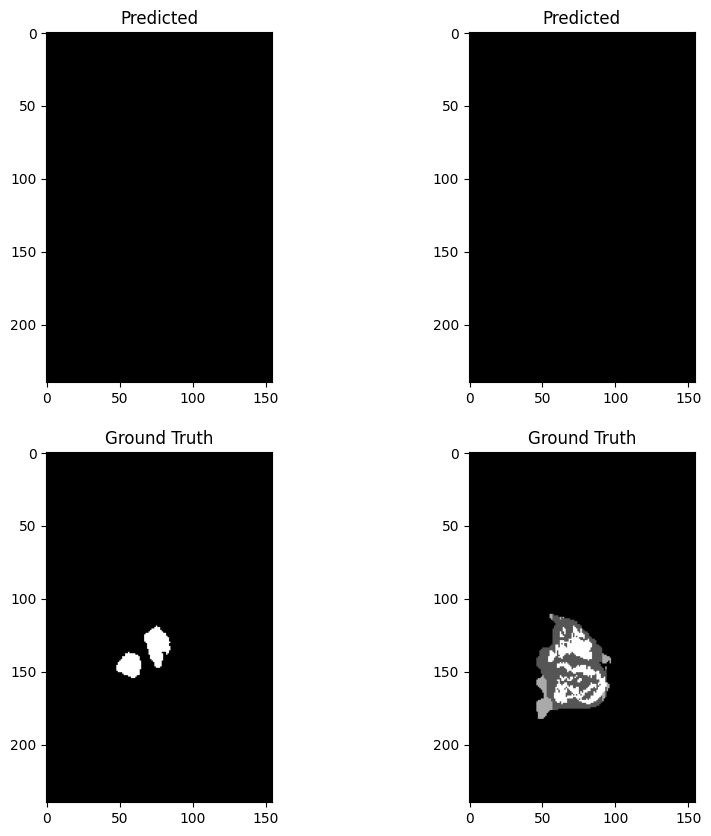

100%|██████████| 156/156 [19:08<00:00,  7.36s/it]



Average Training Loss: 0.3218010108058269

Average Training DSC: [0.86157285 0.34335123 0.75334821 0.        ]
Average Training ASSD: [ 43.25478088 193.83450696  89.28794643 362.        ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


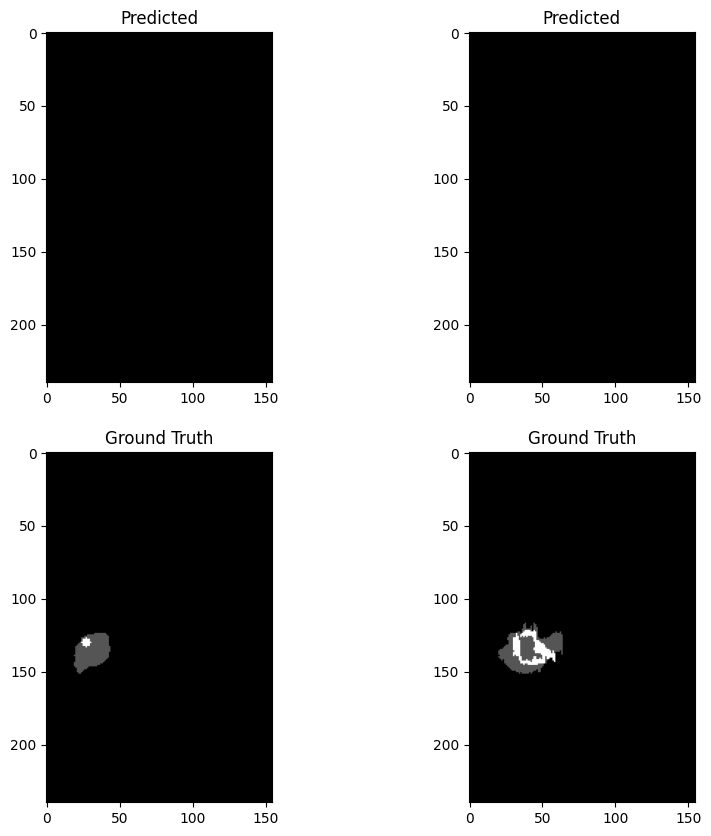

100%|██████████| 39/39 [04:41<00:00,  7.21s/it]


Average Validation Loss: 0.20063712791754648

Average Validation DSC: [0.98567021 0.47084641 0.76648352 0.        ]
Average Validation ASSD: [  3.44153312 182.24618664  84.53296703 362.        ]
Epoch 2/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


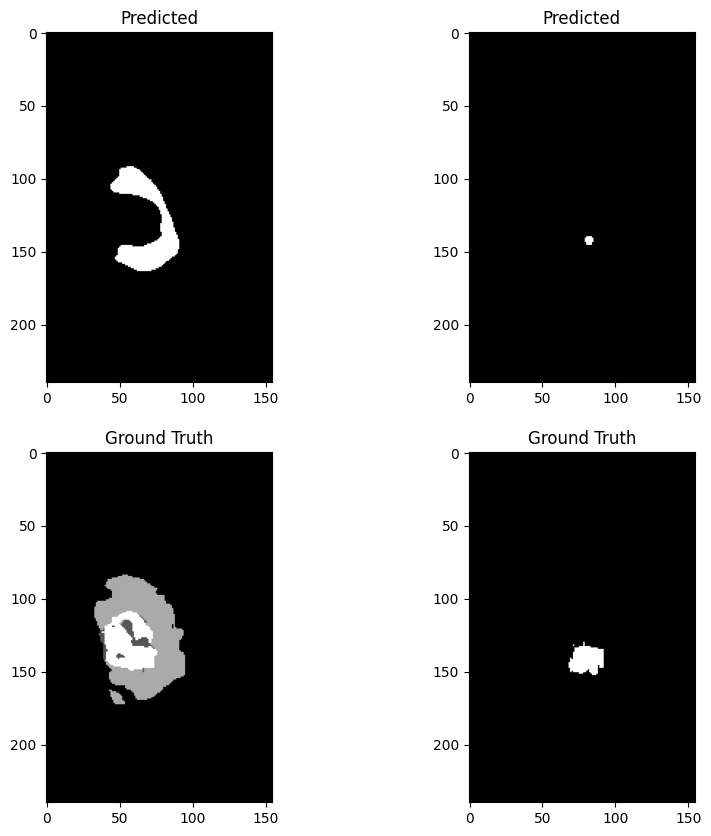

100%|██████████| 156/156 [19:40<00:00,  7.57s/it]



Average Training Loss: 0.07306363228230904

Average Training DSC: [0.99072913 0.26793163 0.75231799 0.17399359]
Average Training ASSD: [  1.14009696 135.77166873  89.66088599 167.87530591]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


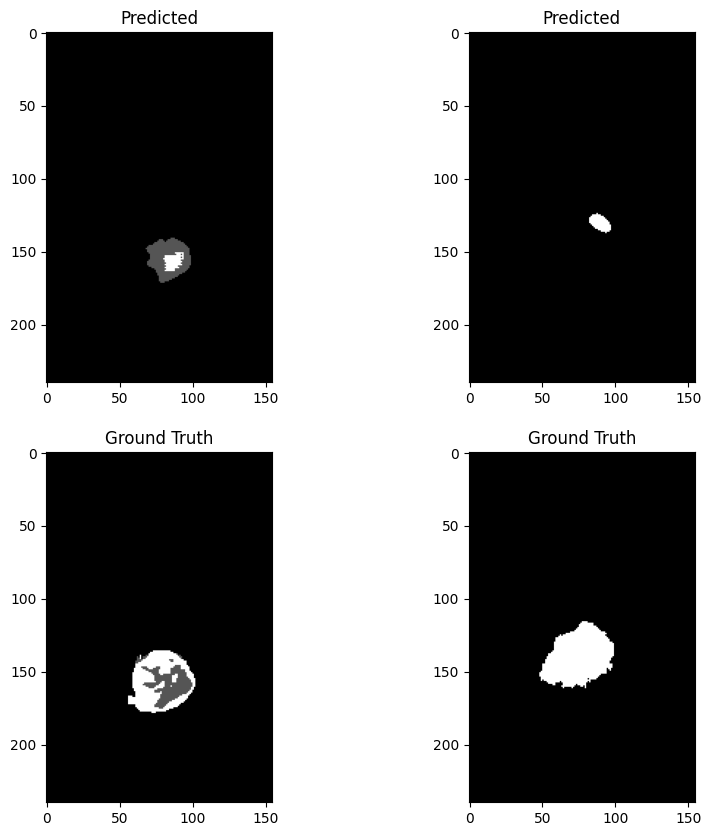

100%|██████████| 39/39 [04:58<00:00,  7.67s/it]


Average Validation Loss: 0.06852914125491412

Average Validation DSC: [0.99062264 0.33301074 0.76694139 0.13903351]
Average Validation ASSD: [  1.35082753 131.94921587  84.36721612 178.25380406]
Epoch 3/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


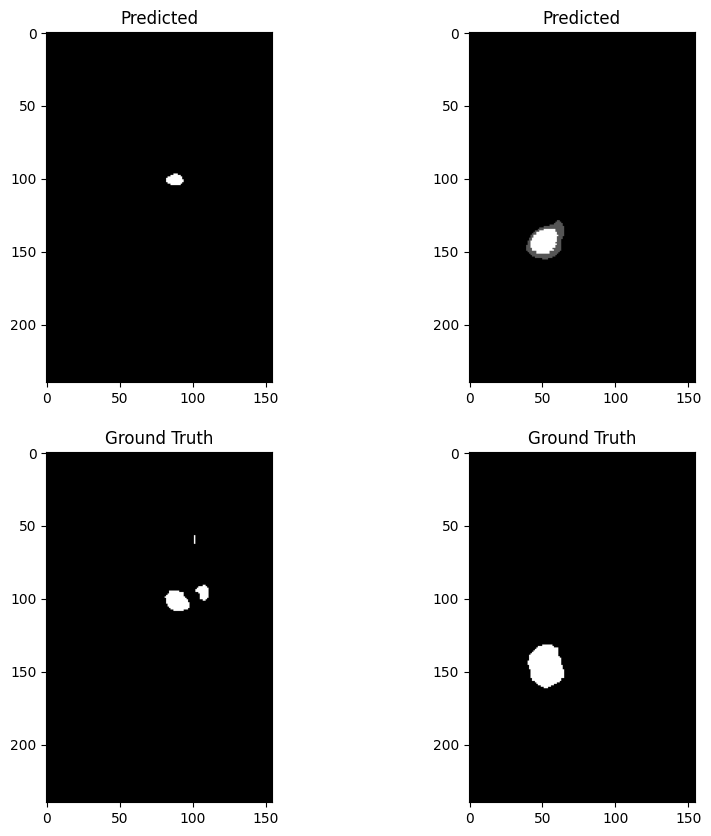

100%|██████████| 156/156 [20:36<00:00,  7.93s/it]



Average Training Loss: 0.06240823642852215

Average Training DSC: [0.9927558  0.28836696 0.7528331  0.23569657]
Average Training ASSD: [  0.87912075 134.62624756  89.47441621 118.40513383]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


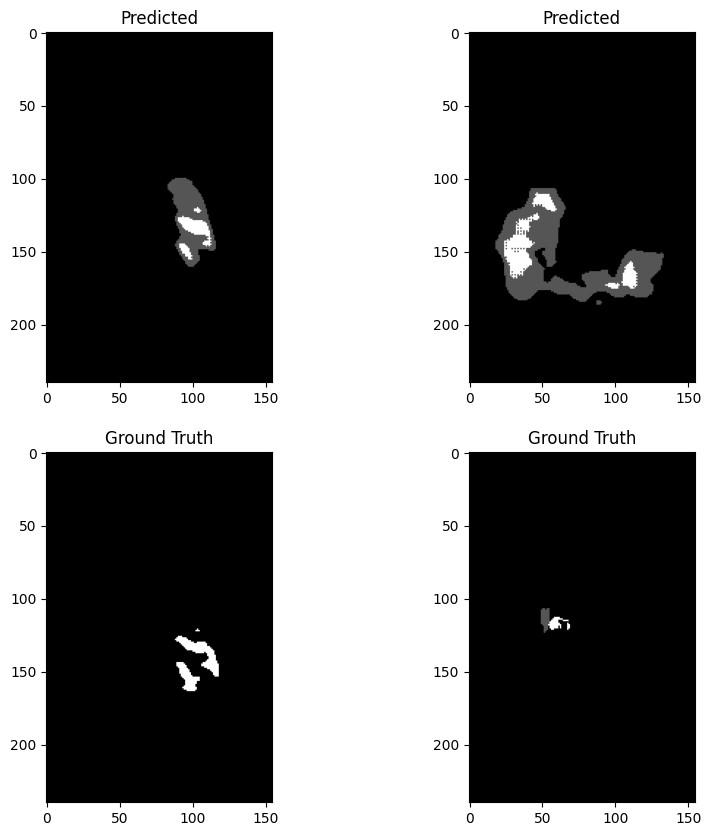

100%|██████████| 39/39 [04:56<00:00,  7.59s/it]


Average Validation Loss: 0.12203977276117374

Average Validation DSC: [0.98459367 0.14109586 0.76694139 0.35706777]
Average Validation ASSD: [  1.73115016 171.60502456  84.36721612  22.7400586 ]
Epoch 4/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


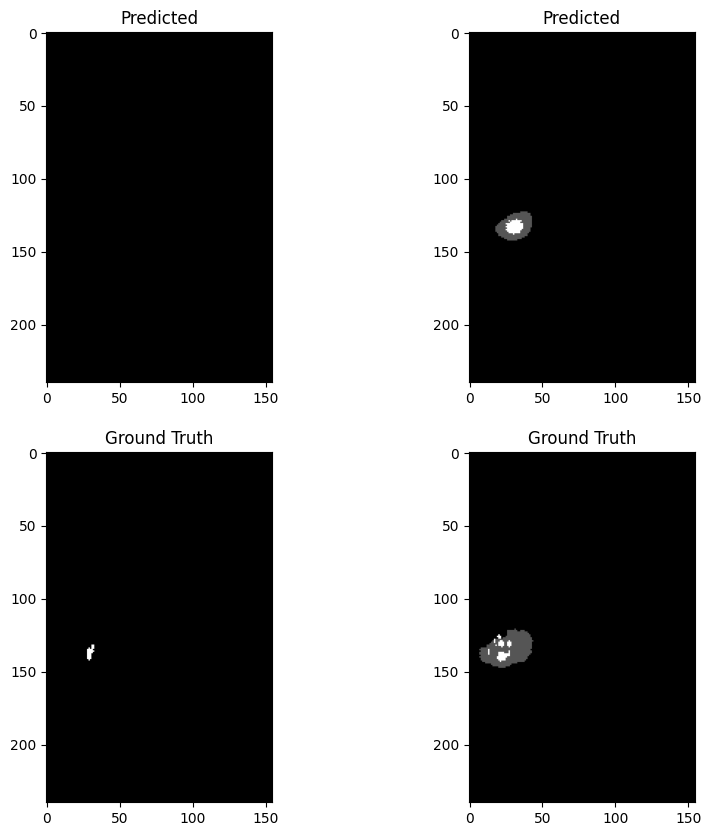

100%|██████████| 156/156 [20:22<00:00,  7.83s/it]



Average Training Loss: 0.058236079123348765

Average Training DSC: [0.99357208 0.30801572 0.75257555 0.23434457]
Average Training ASSD: [  0.8189755  132.54276687  89.5676511  121.50676202]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


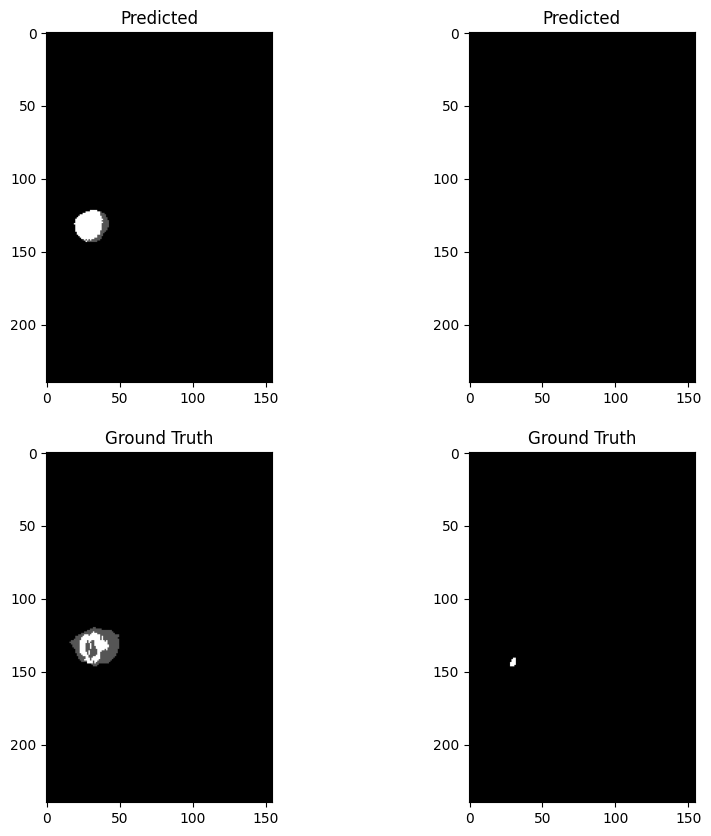

100%|██████████| 39/39 [04:59<00:00,  7.67s/it]


Average Validation Loss: 0.05675108348711943

Average Validation DSC: [0.99367563 0.2867024  0.76717033 0.2530301 ]
Average Validation ASSD: [  0.822223   136.89033112  84.28434066 104.51522031]
Epoch 5/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


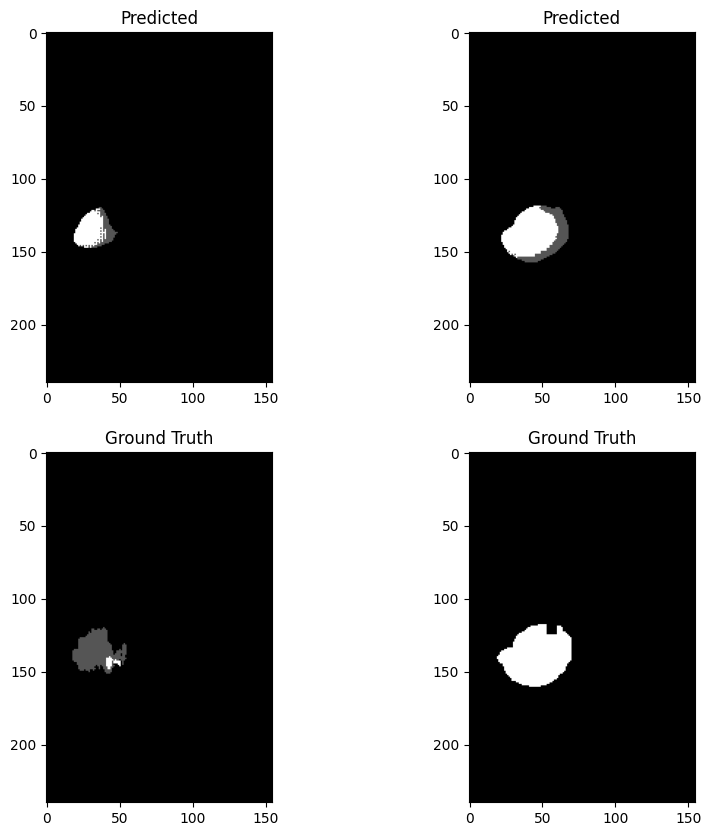

100%|██████████| 156/156 [20:21<00:00,  7.83s/it]



Average Training Loss: 0.05527132045095547

Average Training DSC: [0.99420557 0.30246673 0.75309066 0.23946925]
Average Training ASSD: [  0.71616466 134.97488481  89.38118132  88.587619  ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


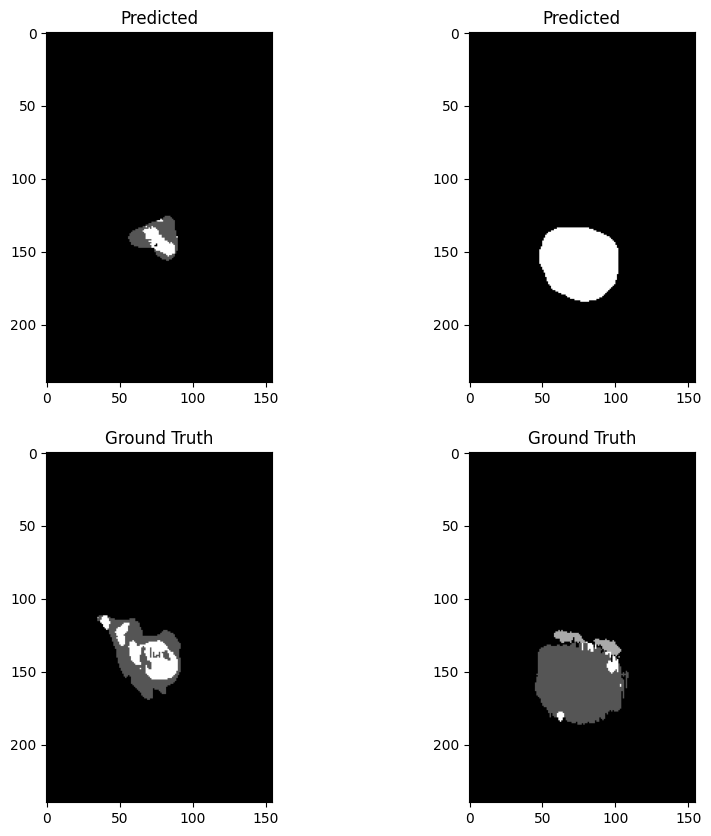

100%|██████████| 39/39 [04:43<00:00,  7.27s/it]


Average Validation Loss: 0.08828773531012046

Average Validation DSC: [0.9894034  0.38873035 0.76682692 0.13179356]
Average Validation ASSD: [  1.94977352 122.43261047  84.40865385 218.1752014 ]
Epoch 6/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


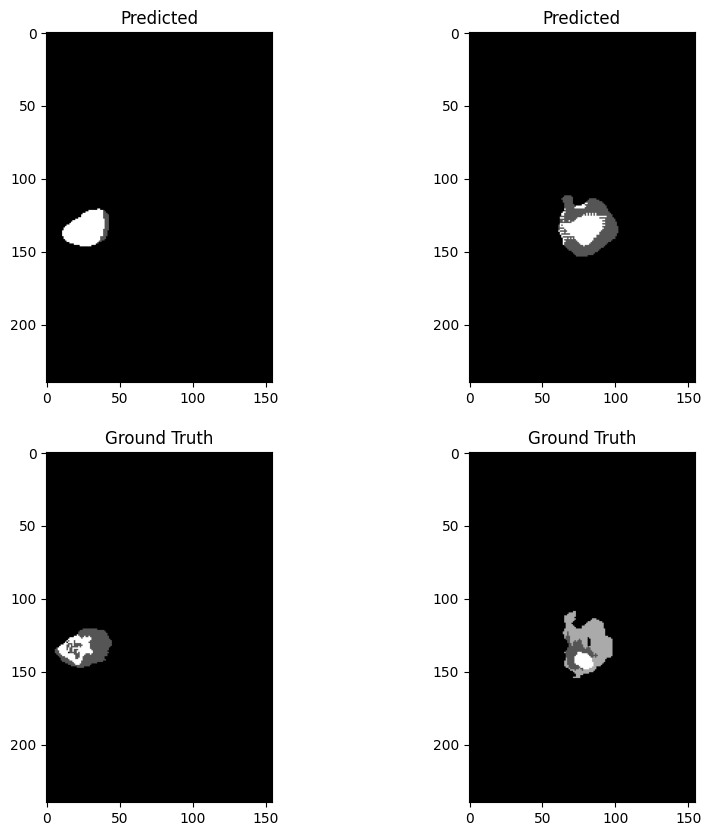

100%|██████████| 156/156 [19:54<00:00,  7.66s/it]



Average Training Loss: 0.0524333683678355

Average Training DSC: [0.99473901 0.32008363 0.75231799 0.29643031]
Average Training ASSD: [  0.65677366 130.87257679  89.66088599  74.44850073]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


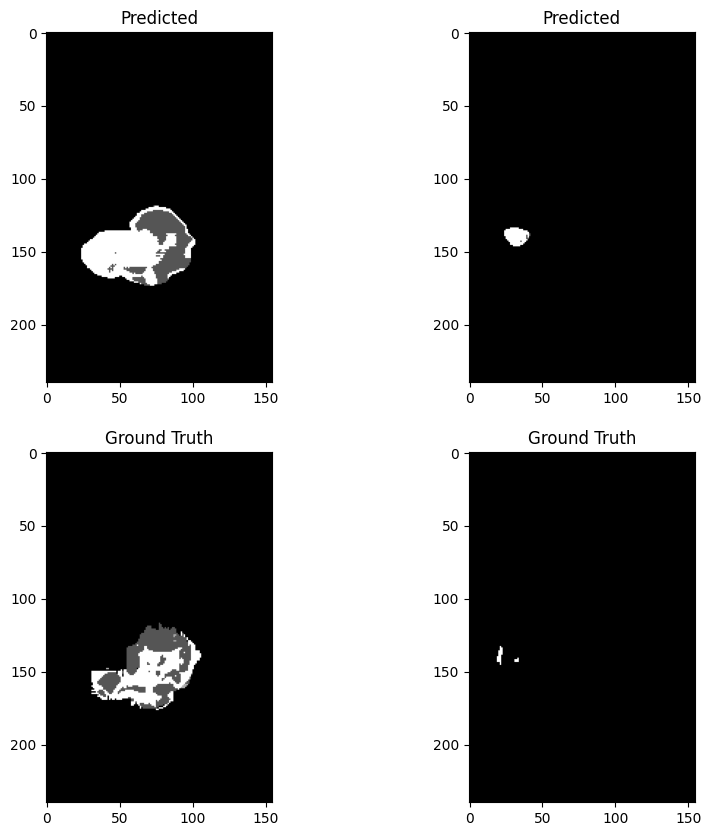

100%|██████████| 39/39 [05:10<00:00,  7.96s/it]


Average Validation Loss: 0.07661087677264825

Average Validation DSC: [0.99260009 0.3024656  0.76705586 0.32292541]
Average Validation ASSD: [  0.81791621 147.67121342  84.32577839  30.74952552]
Epoch 7/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


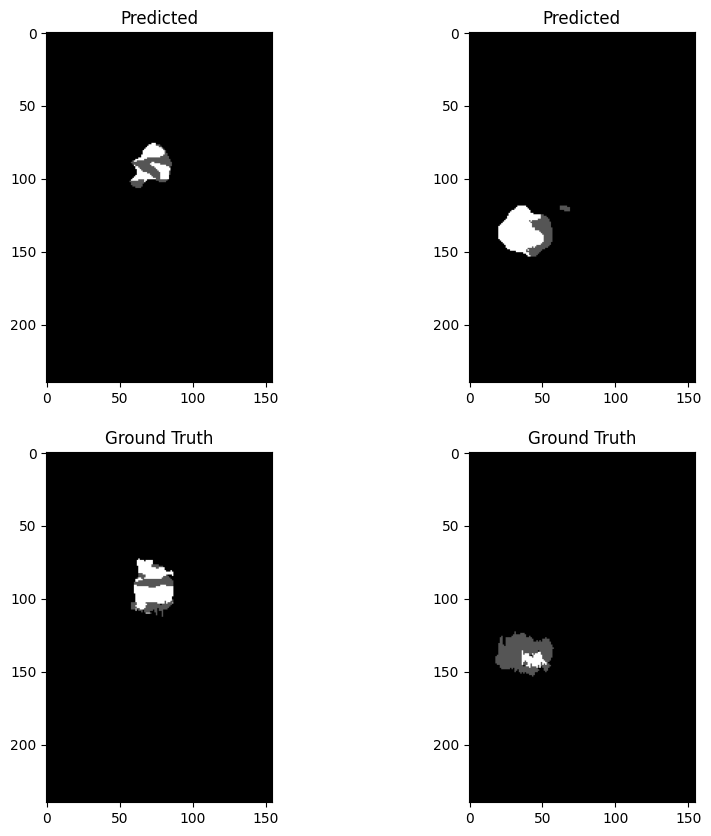

100%|██████████| 156/156 [20:23<00:00,  7.84s/it]



Average Training Loss: 0.050821069651880324

Average Training DSC: [0.99502153 0.36034886 0.7528331  0.29483203]
Average Training ASSD: [  0.63431266 129.72050347  89.47441621  80.33741122]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


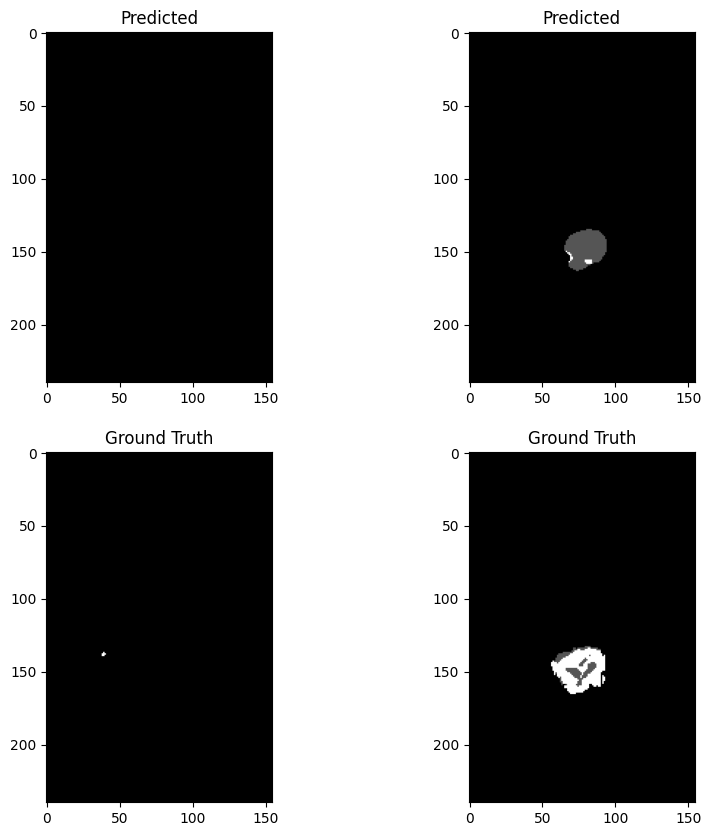

100%|██████████| 39/39 [04:51<00:00,  7.47s/it]


Average Validation Loss: 0.0623030346364547

Average Validation DSC: [0.99226094 0.40905027 0.76717033 0.15278366]
Average Validation ASSD: [  1.271078   125.25365432  84.28434066 171.90720355]
Epoch 8/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


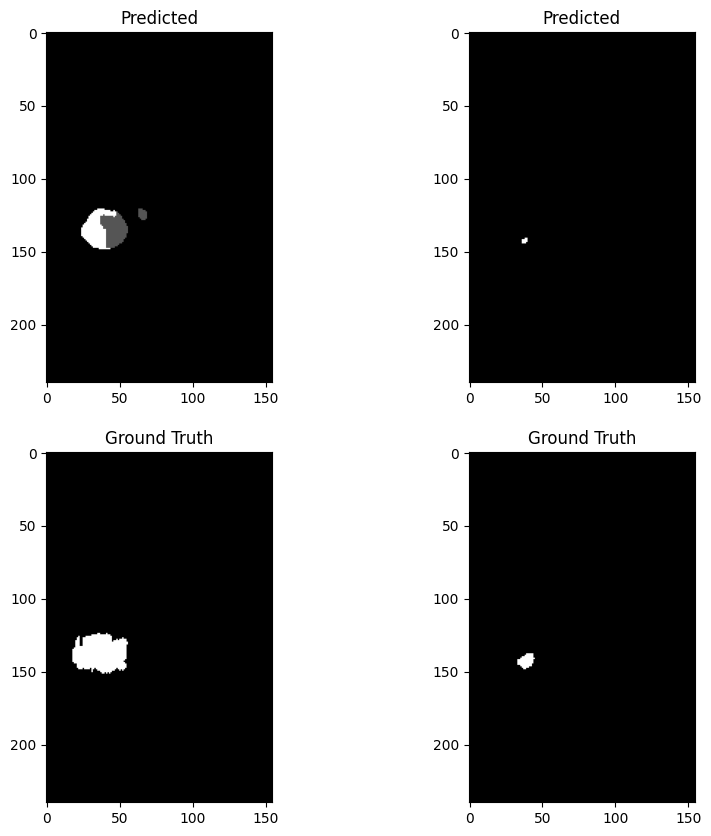

100%|██████████| 156/156 [20:28<00:00,  7.88s/it]



Average Training Loss: 0.04845659432407373

Average Training DSC: [0.99544853 0.37153817 0.73573332 0.29408063]
Average Training ASSD: [  0.58220906 128.29472164  89.8551684   91.94265481]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


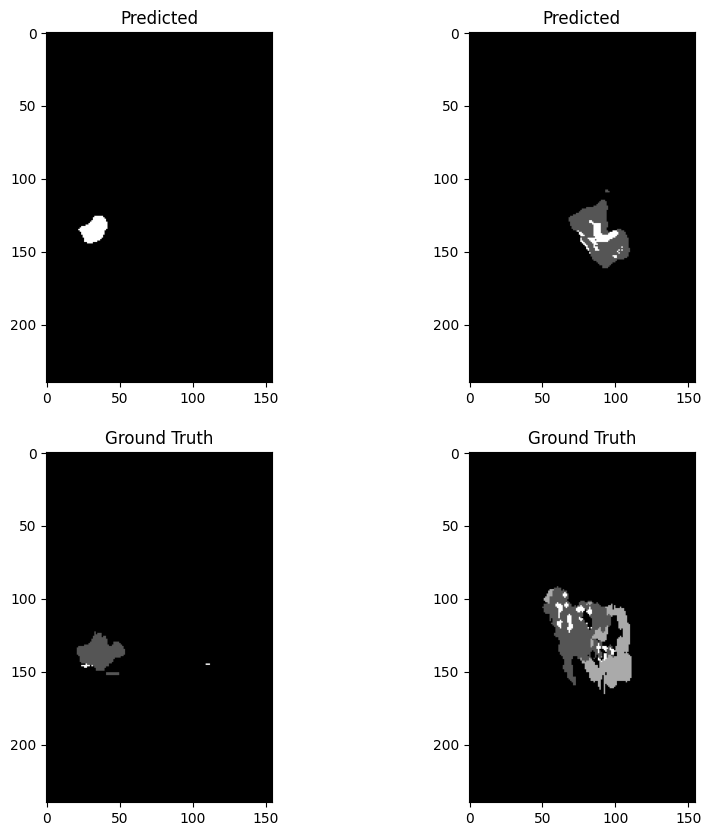

100%|██████████| 39/39 [05:02<00:00,  7.75s/it]


Average Validation Loss: 0.05237802652976452

Average Validation DSC: [0.99351928 0.34209392 0.76201923 0.32461583]
Average Validation ASSD: [  0.82979692 134.46865376  86.14903846  94.09723832]
Epoch 9/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


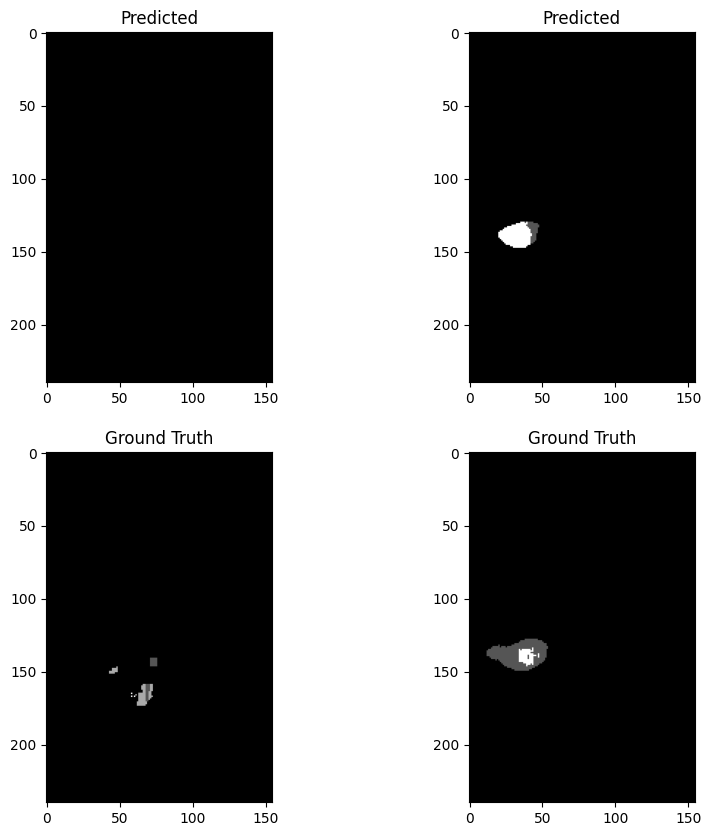

100%|██████████| 156/156 [20:00<00:00,  7.70s/it]



Average Training Loss: 0.0464613606245854

Average Training DSC: [0.99578626 0.37582928 0.6972637  0.3005179 ]
Average Training ASSD: [  0.53893644 127.38954722  86.35880912  93.81746785]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


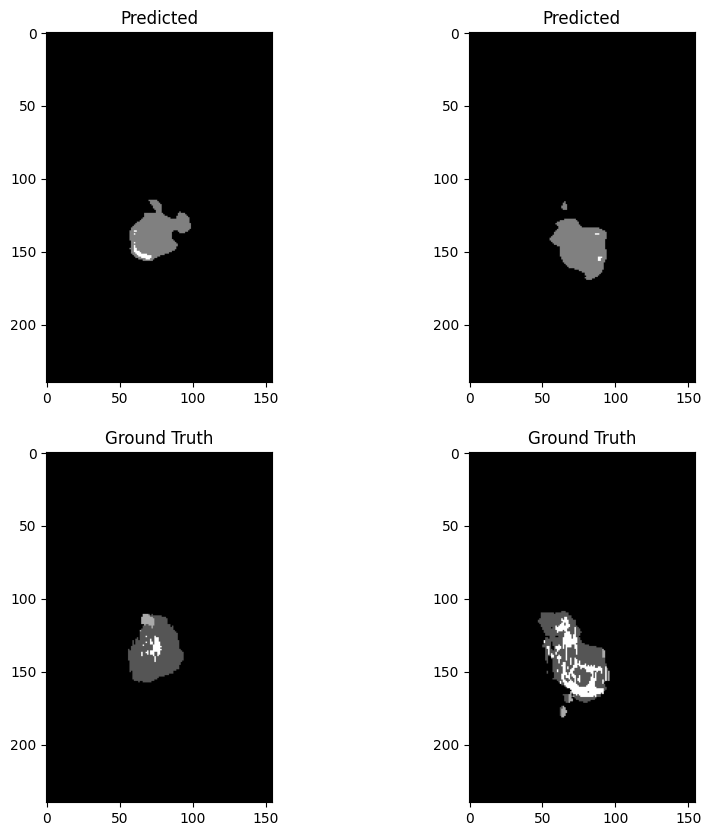

100%|██████████| 39/39 [04:37<00:00,  7.12s/it]


Average Validation Loss: 0.04809345782567293

Average Validation DSC: [0.99471548 0.37134086 0.643054   0.31068677]
Average Validation ASSD: [  0.67259368 123.91901736  84.20806569  99.9030432 ]
Epoch 10/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


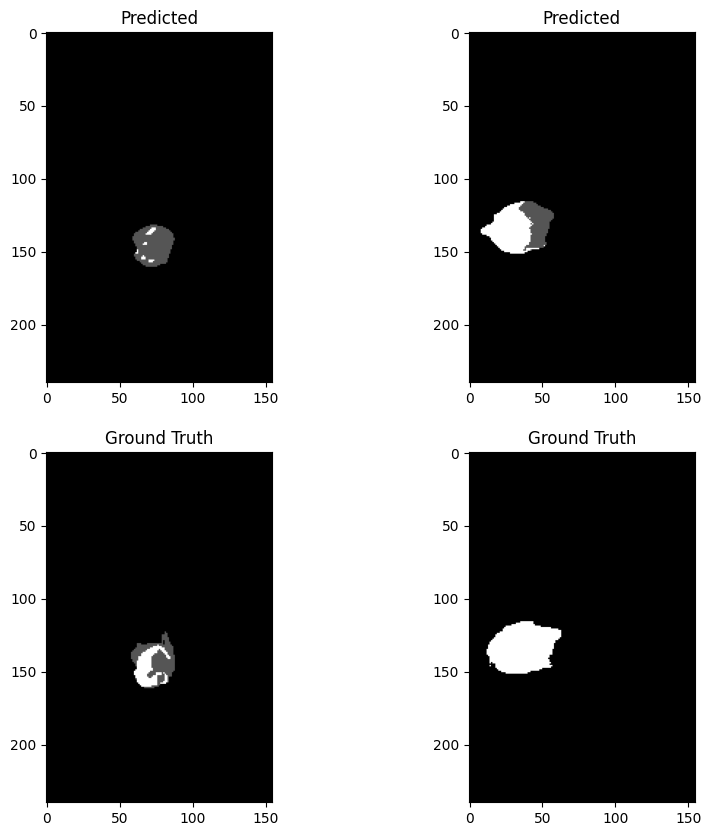

100%|██████████| 156/156 [20:35<00:00,  7.92s/it]



Average Training Loss: 0.04450857436332183

Average Training DSC: [0.99607299 0.37811108 0.60835855 0.32099817]
Average Training ASSD: [  0.49530333 125.90091189  97.53024856  85.63488836]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


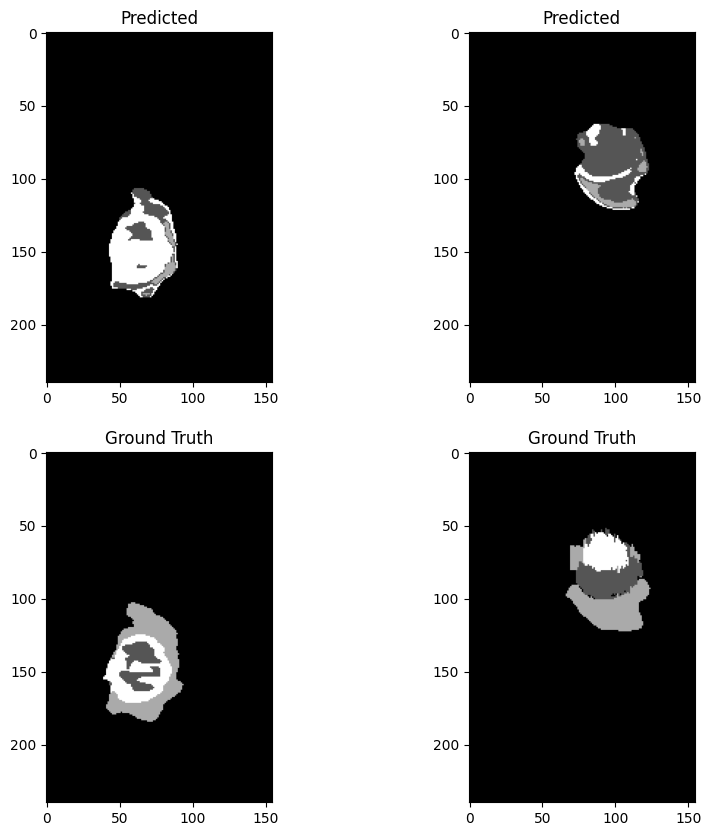

100%|██████████| 39/39 [04:44<00:00,  7.31s/it]


Average Validation Loss: 0.04937645258047642

Average Validation DSC: [0.99487608 0.3756268  0.5970104  0.32115481]
Average Validation ASSD: [  0.69013634 124.6709787  100.61365379  98.81134365]
Epoch 11/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


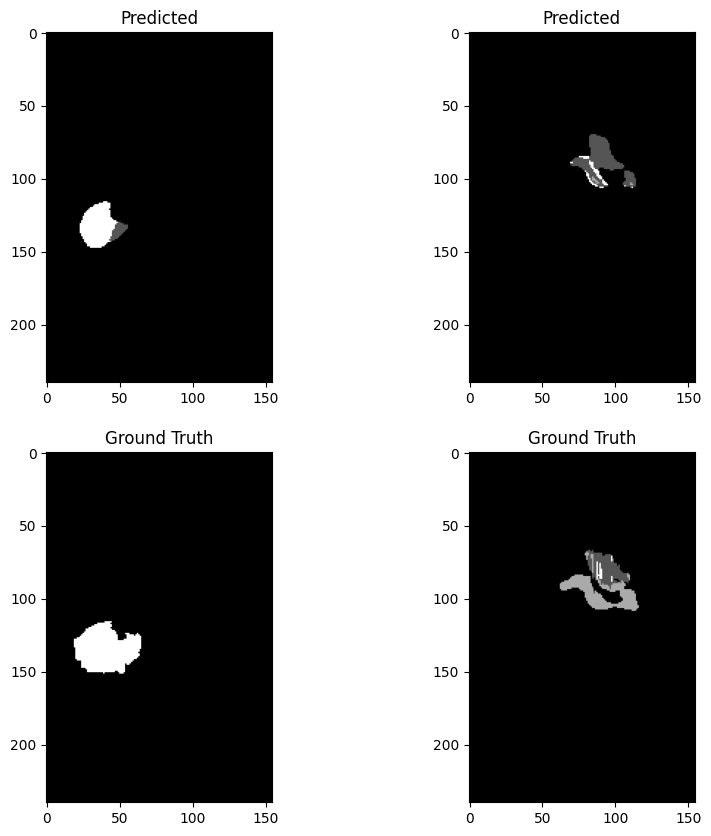

100%|██████████| 156/156 [20:29<00:00,  7.88s/it]



Average Training Loss: 0.043558551285129324

Average Training DSC: [0.9961408  0.39494035 0.60808576 0.33112457]
Average Training ASSD: [  0.48810842 123.31816375  97.44281587  69.42962234]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


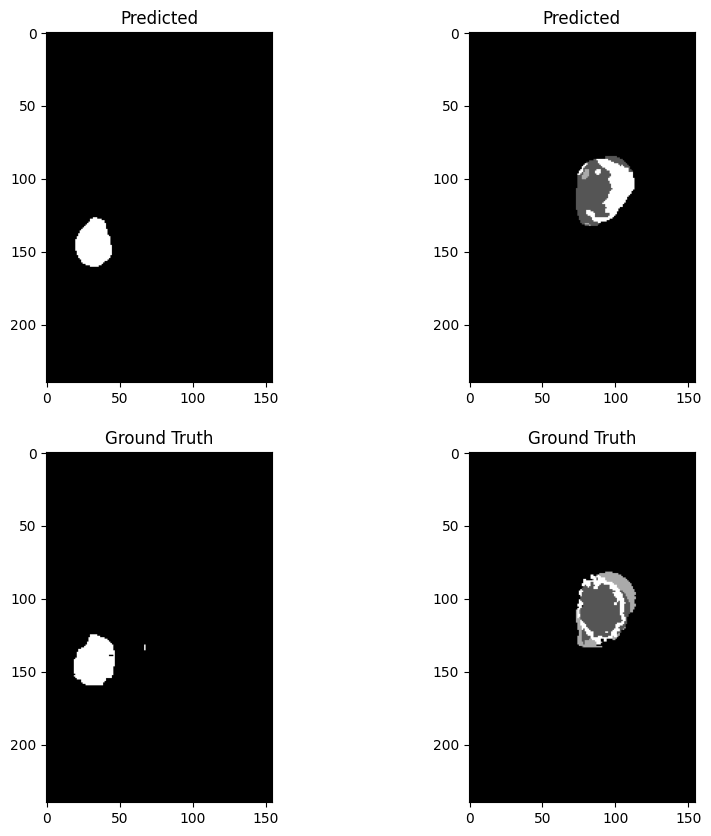

100%|██████████| 39/39 [04:52<00:00,  7.50s/it]


Average Validation Loss: 0.05157426219338026

Average Validation DSC: [0.99403453 0.42190662 0.58181849 0.36470147]
Average Validation ASSD: [  0.89601834 111.89449456 108.6336468   86.10775606]
Epoch 12/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


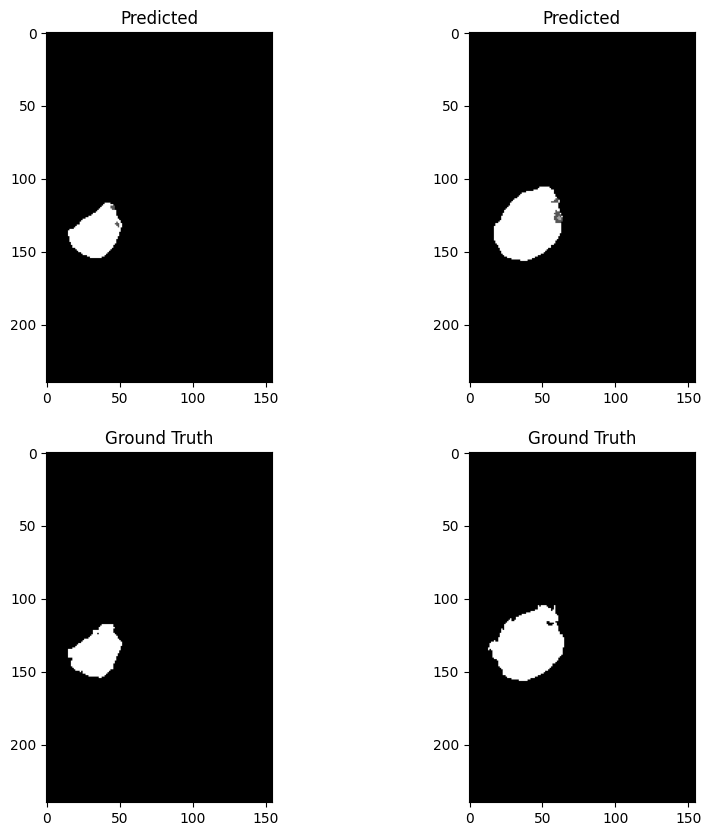

100%|██████████| 156/156 [19:59<00:00,  7.69s/it]



Average Training Loss: 0.04164440671984966

Average Training DSC: [0.99629878 0.41480521 0.60745317 0.3870382 ]
Average Training ASSD: [  0.46050296 115.09217891  96.88534509  48.68312692]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


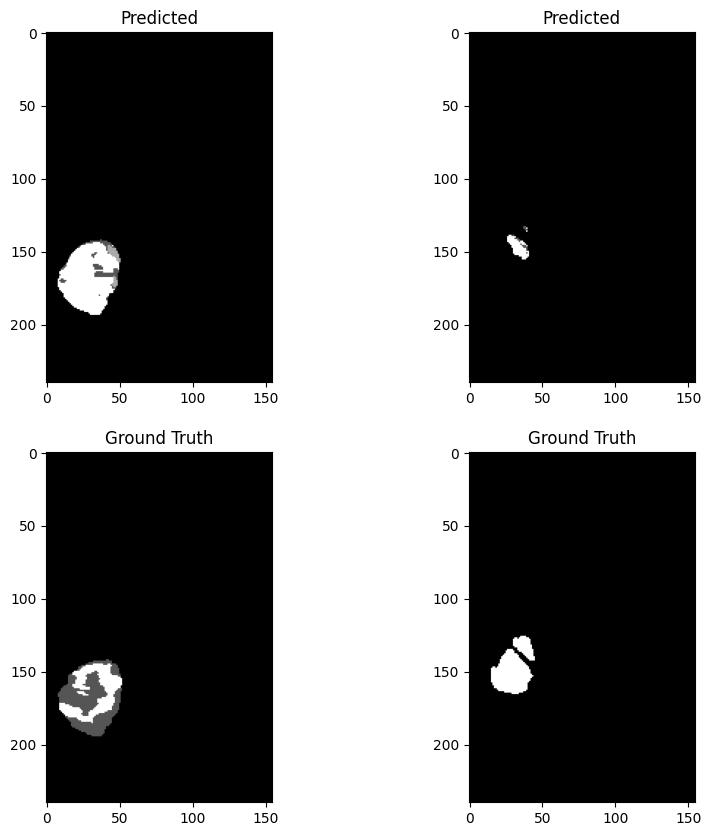

100%|██████████| 39/39 [04:49<00:00,  7.43s/it]


Average Validation Loss: 0.09459419624927716

Average Validation DSC: [0.99137802 0.45351695 0.64439469 0.25863293]
Average Validation ASSD: [  1.63701945 137.39894351  95.83550121 144.91761536]
Epoch 13/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


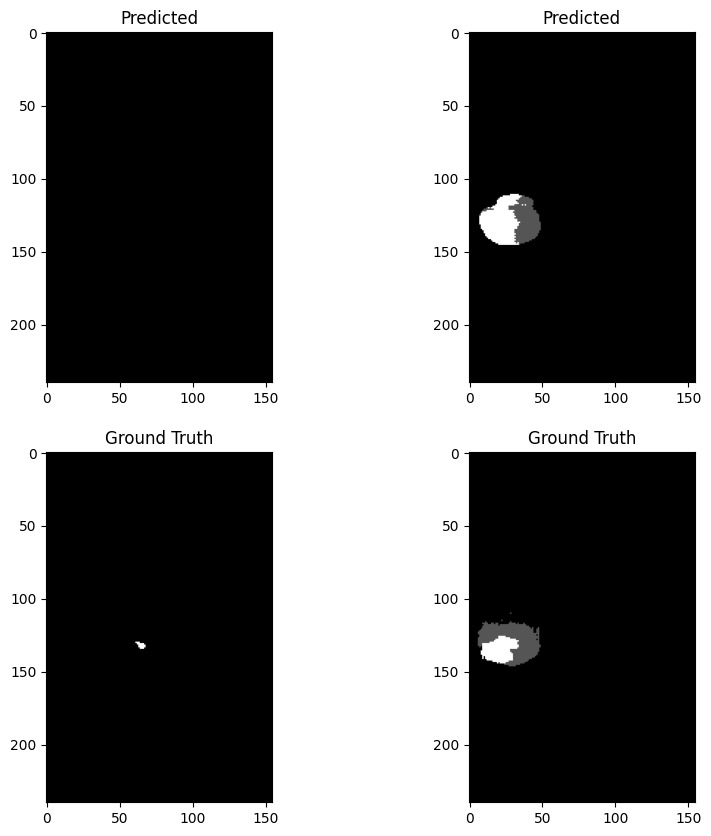

100%|██████████| 156/156 [19:57<00:00,  7.68s/it]



Average Training Loss: 0.03966541189509325

Average Training DSC: [0.99646587 0.42827978 0.64188047 0.38620273]
Average Training ASSD: [  0.43961301 115.52691825  88.26829335  49.52480493]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


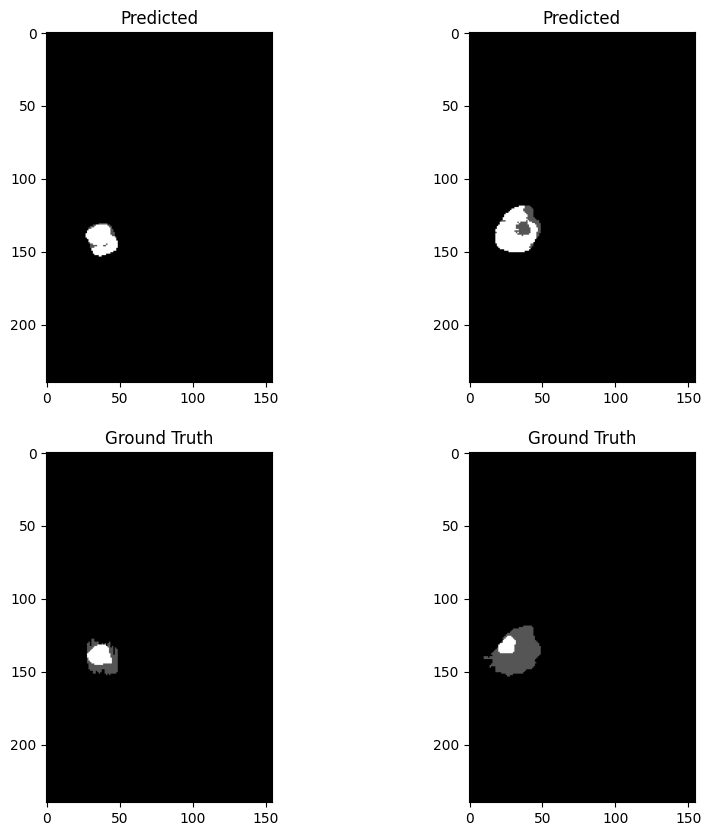

100%|██████████| 39/39 [04:54<00:00,  7.55s/it]


Average Validation Loss: 0.03750383524367443

Average Validation DSC: [0.99643575 0.43399236 0.72353286 0.37451239]
Average Validation ASSD: [  0.44365618 122.22367562  63.67288104  56.63347177]
Epoch 14/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


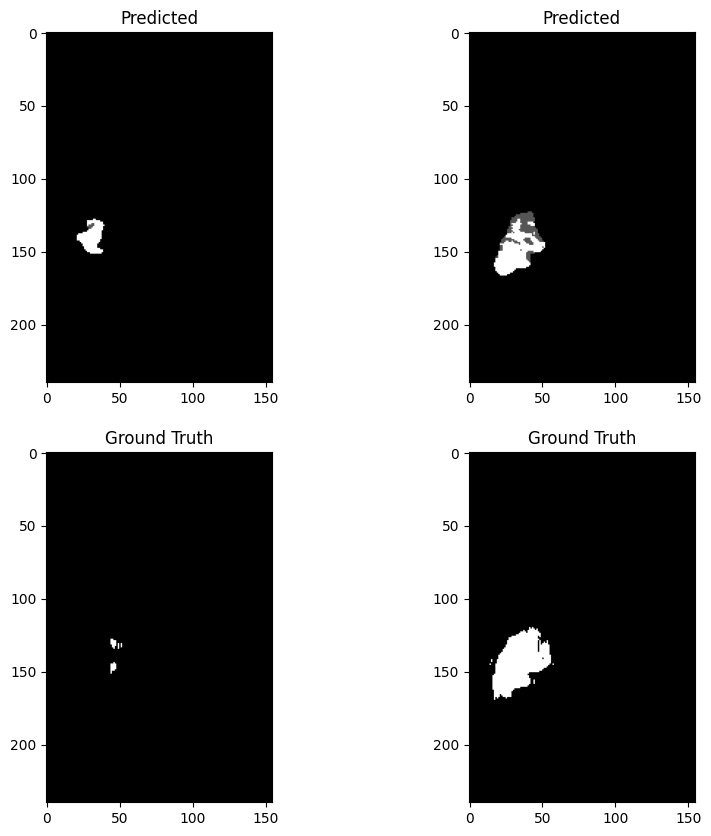

100%|██████████| 156/156 [18:53<00:00,  7.27s/it]



Average Training Loss: 0.03661138342263607

Average Training DSC: [0.99676853 0.43871986 0.69661286 0.40397452]
Average Training ASSD: [  0.3900207  113.26174847  75.76616743  47.016442  ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


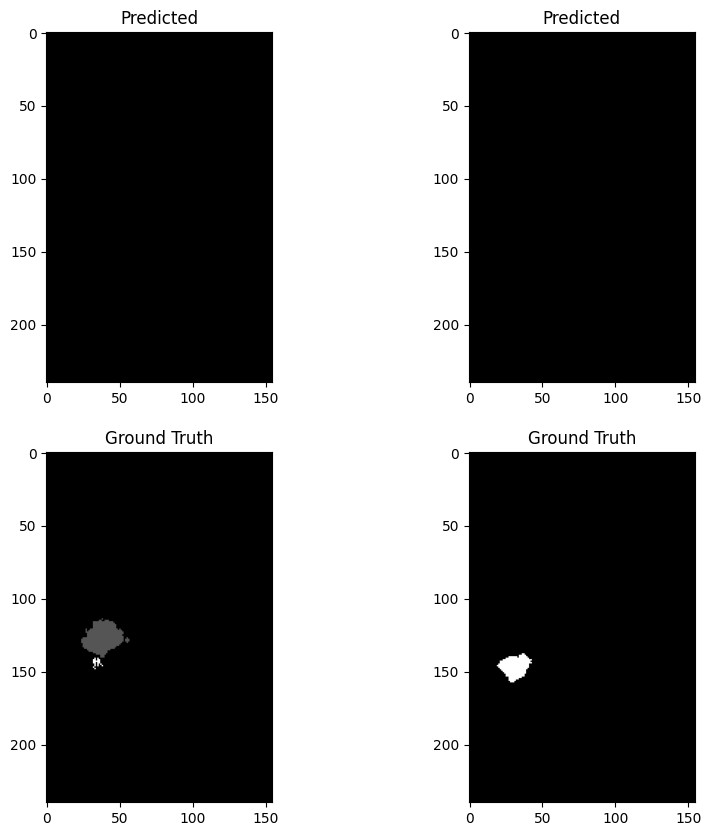

100%|██████████| 39/39 [04:39<00:00,  7.18s/it]


Average Validation Loss: 0.0772444479740583

Average Validation DSC: [0.99161322 0.49772015 0.73880225 0.24759772]
Average Validation ASSD: [  1.37434591 116.85958359  61.69469547 134.4325915 ]
Epoch 15/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


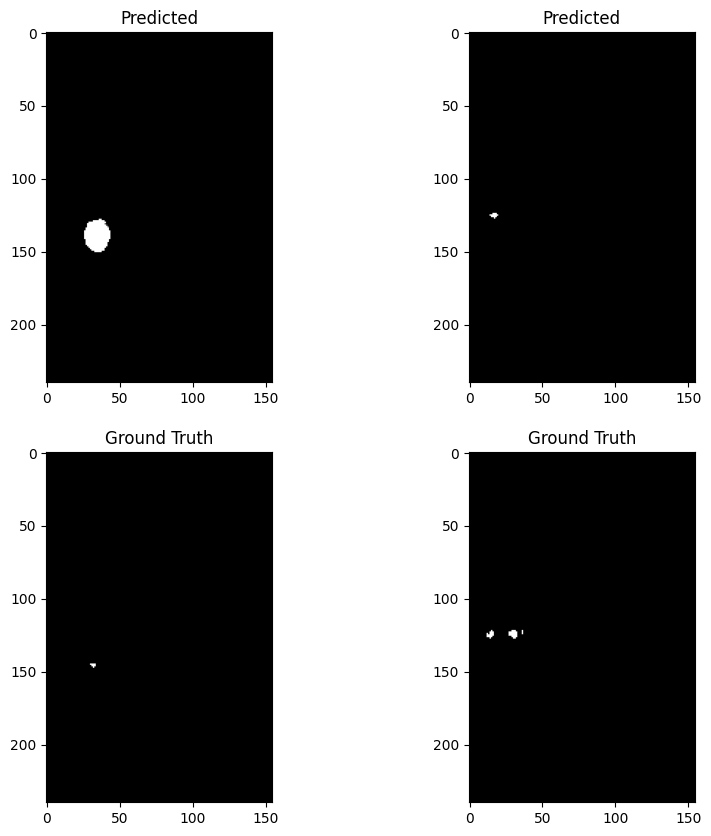

100%|██████████| 156/156 [18:27<00:00,  7.10s/it]



Average Training Loss: 0.035469604178498954

Average Training DSC: [0.99679823 0.44169984 0.72380725 0.42278204]
Average Training ASSD: [  0.38472825 111.37696209  67.44824782  43.29798622]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


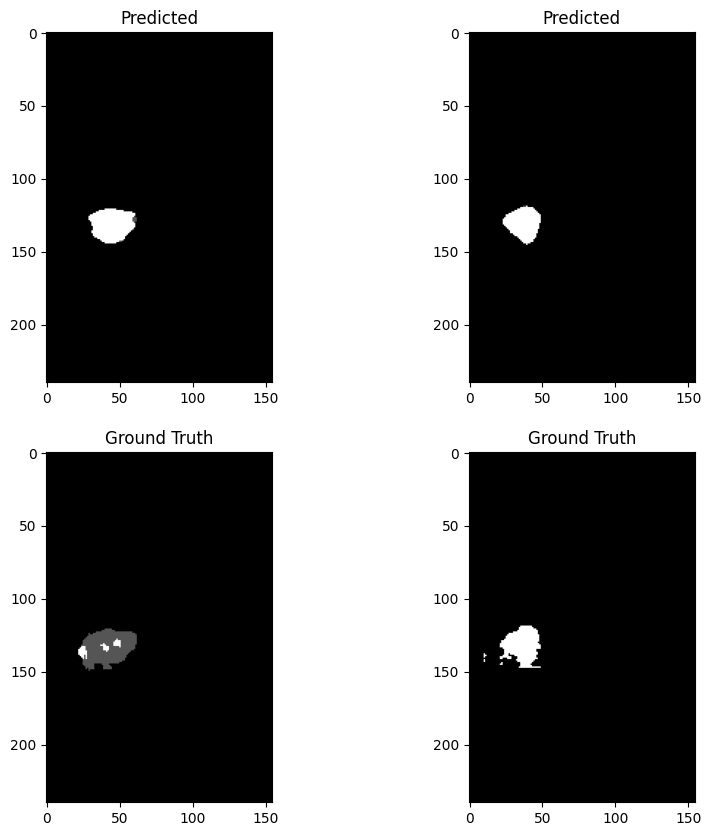

100%|██████████| 39/39 [04:32<00:00,  6.98s/it]


Average Validation Loss: 0.035197705460282475

Average Validation DSC: [0.9965534  0.45548611 0.78398104 0.45349316]
Average Validation ASSD: [  0.4236639  101.5393722   51.26323233  50.39022628]
Epoch 16/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


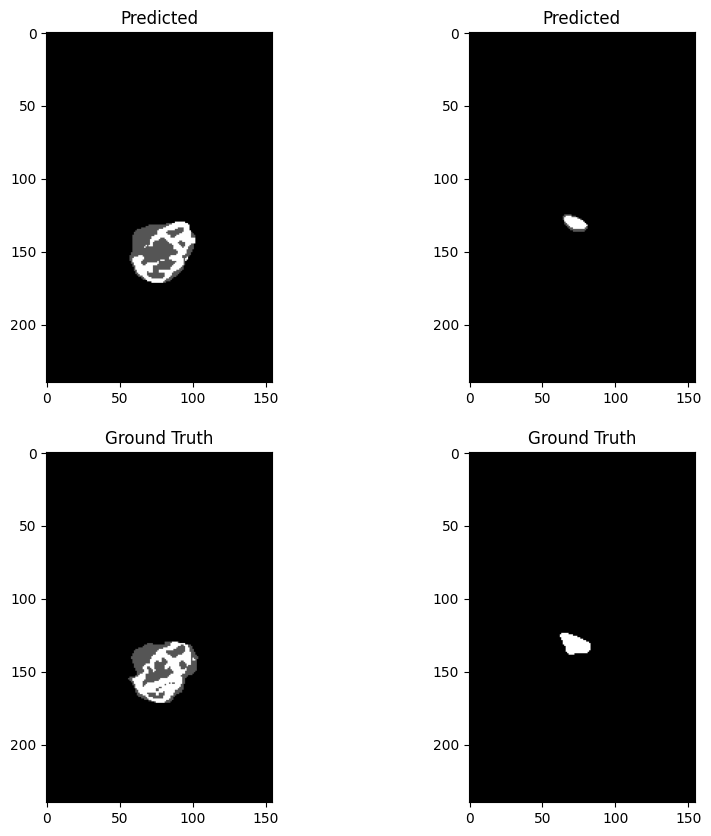

100%|██████████| 156/156 [19:24<00:00,  7.47s/it]



Average Training Loss: 0.034216844476759434

Average Training DSC: [0.99691721 0.44925065 0.74034528 0.43741105]
Average Training ASSD: [  0.3700916  110.87309386  63.4119729   42.16131586]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


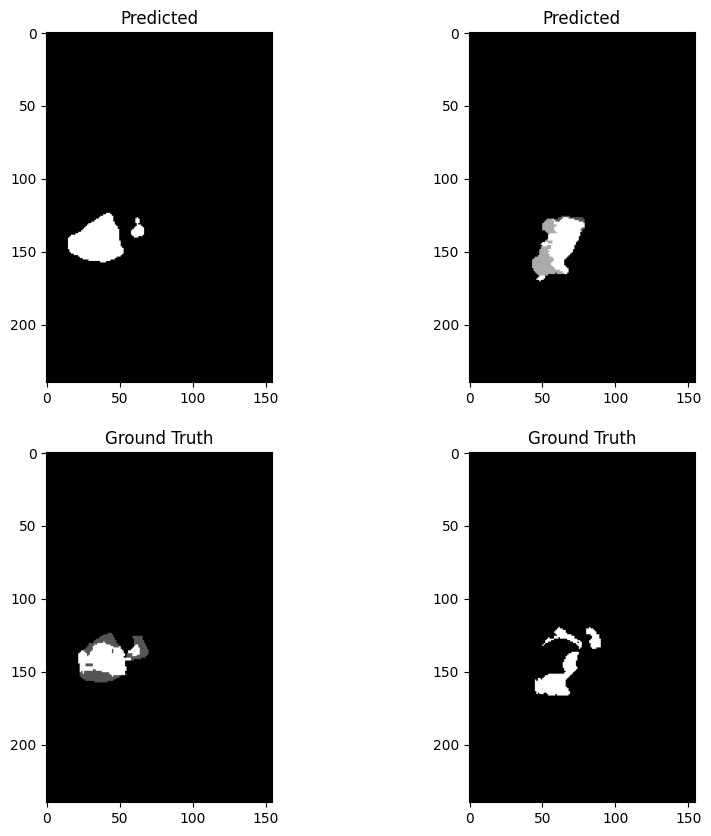

100%|██████████| 39/39 [05:08<00:00,  7.90s/it]


Average Validation Loss: 0.04013931923187696

Average Validation DSC: [0.99656447 0.38700491 0.77871999 0.4920461 ]
Average Validation ASSD: [  0.40147018 114.49711505  51.67394704  19.42626463]
Epoch 17/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


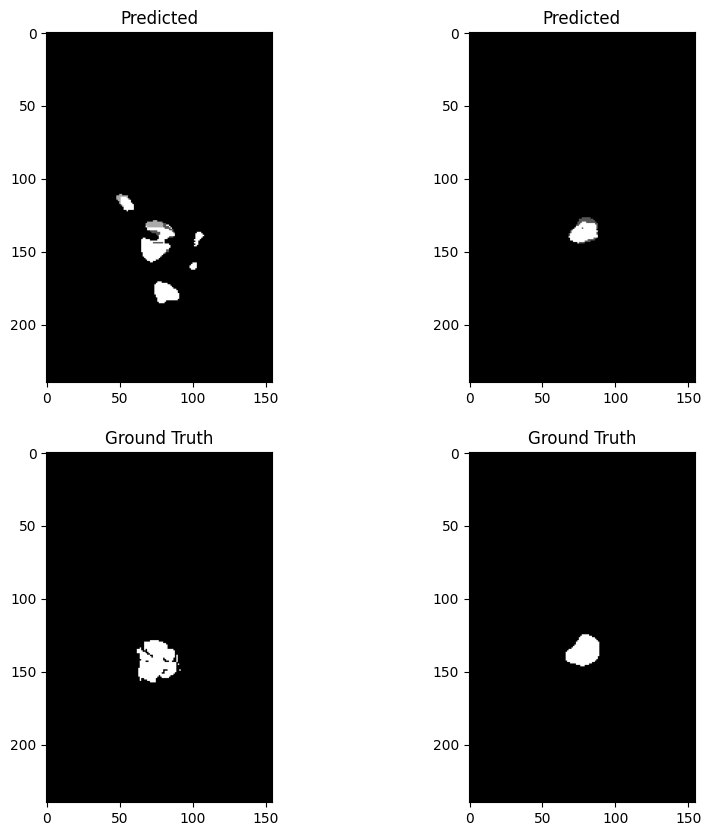

100%|██████████| 156/156 [20:38<00:00,  7.94s/it]



Average Training Loss: 0.03228582610161258

Average Training DSC: [0.99711877 0.46300802 0.76386449 0.45219723]
Average Training ASSD: [  0.33759961 109.00406873  56.73110245  40.21072602]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


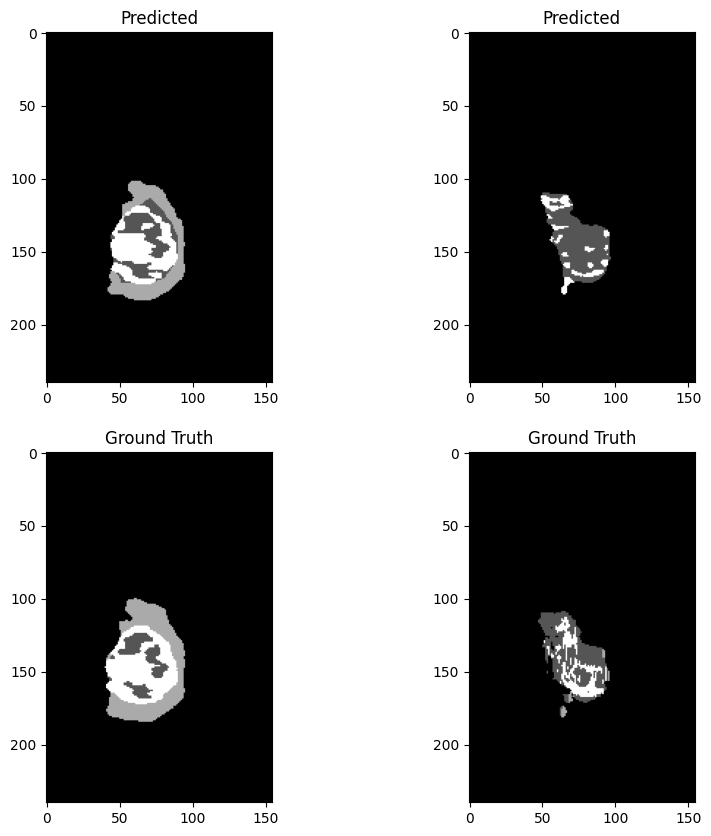

100%|██████████| 39/39 [04:59<00:00,  7.67s/it]


Average Validation Loss: 0.0317734912610971

Average Validation DSC: [0.99724567 0.45939419 0.77326279 0.46669508]
Average Validation ASSD: [  0.30607883 116.53541915  55.52579288  31.52441925]
Epoch 18/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


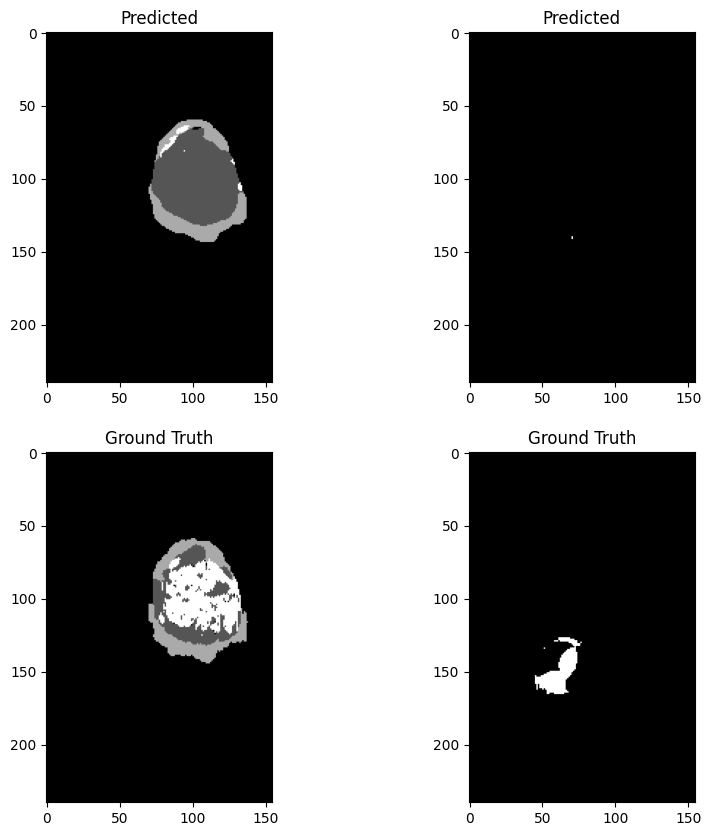

100%|██████████| 156/156 [20:27<00:00,  7.87s/it]



Average Training Loss: 0.031552078847128615

Average Training DSC: [0.99711163 0.46750174 0.77110859 0.4602222 ]
Average Training ASSD: [  0.33657375 108.68499273  53.59460802  38.5690099 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


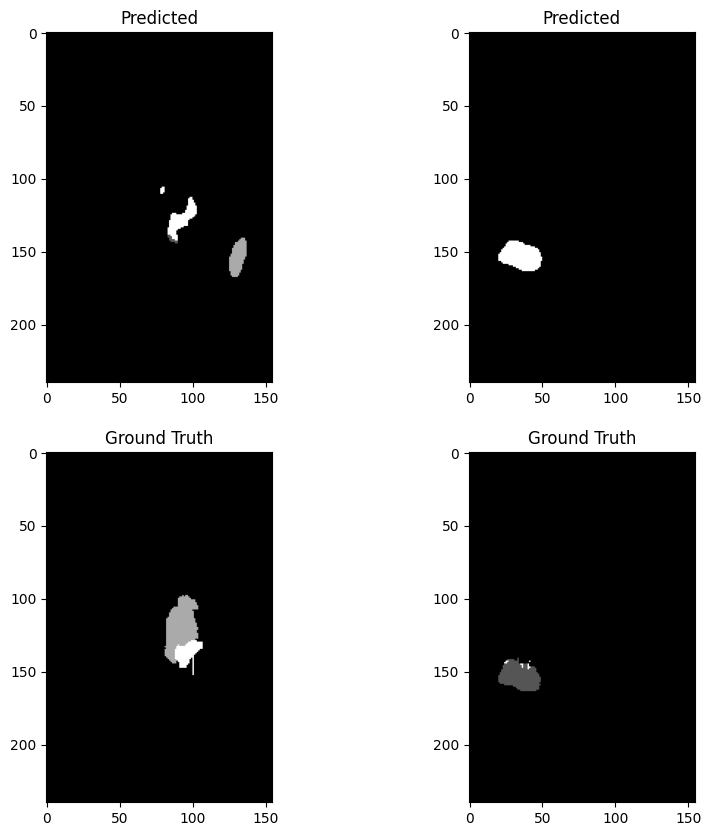

100%|██████████| 39/39 [05:12<00:00,  8.02s/it]


Average Validation Loss: 0.03759778080842434

Average Validation DSC: [0.99671375 0.45139069 0.67234368 0.40585404]
Average Validation ASSD: [  0.36606076 129.6878751   86.64360218  27.95870868]
Epoch 19/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


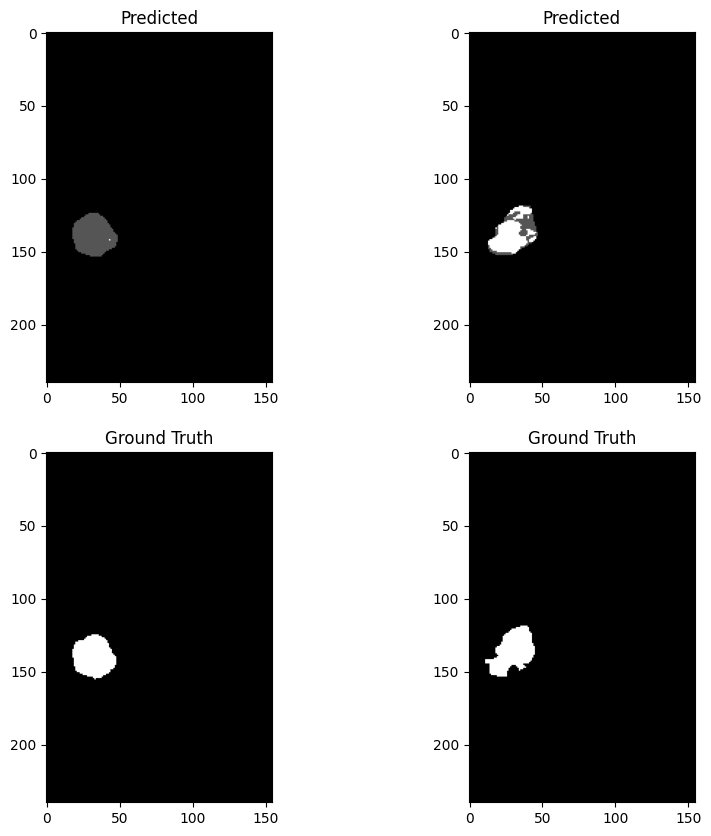

100%|██████████| 156/156 [20:39<00:00,  7.95s/it]



Average Training Loss: 0.02959360210941388

Average Training DSC: [0.99731143 0.49166681 0.79310865 0.4811146 ]
Average Training ASSD: [  0.30709877 104.49466323  49.99991532  35.15313247]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


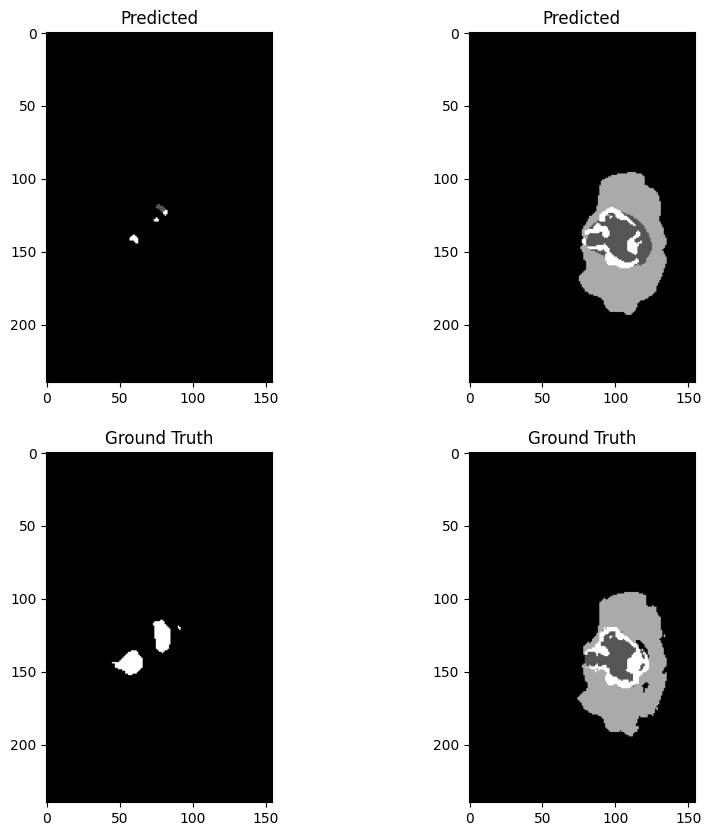

100%|██████████| 39/39 [05:01<00:00,  7.74s/it]


Average Validation Loss: 0.029923717610729046

Average Validation DSC: [0.99728327 0.49147565 0.82481337 0.50190783]
Average Validation ASSD: [  0.28197383 109.76877331  38.12937015  29.42722607]
Epoch 20/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


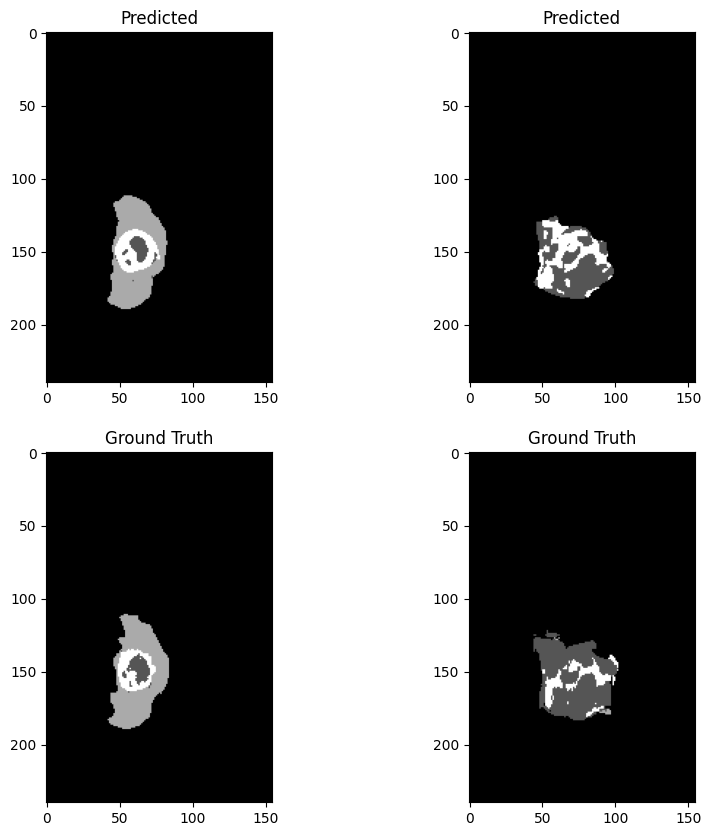

100%|██████████| 156/156 [20:52<00:00,  8.03s/it]



Average Training Loss: 0.02836166875054821

Average Training DSC: [0.99736068 0.52121868 0.79897799 0.49787388]
Average Training ASSD: [ 0.29517819 97.90187968 46.77513555 32.96320641]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


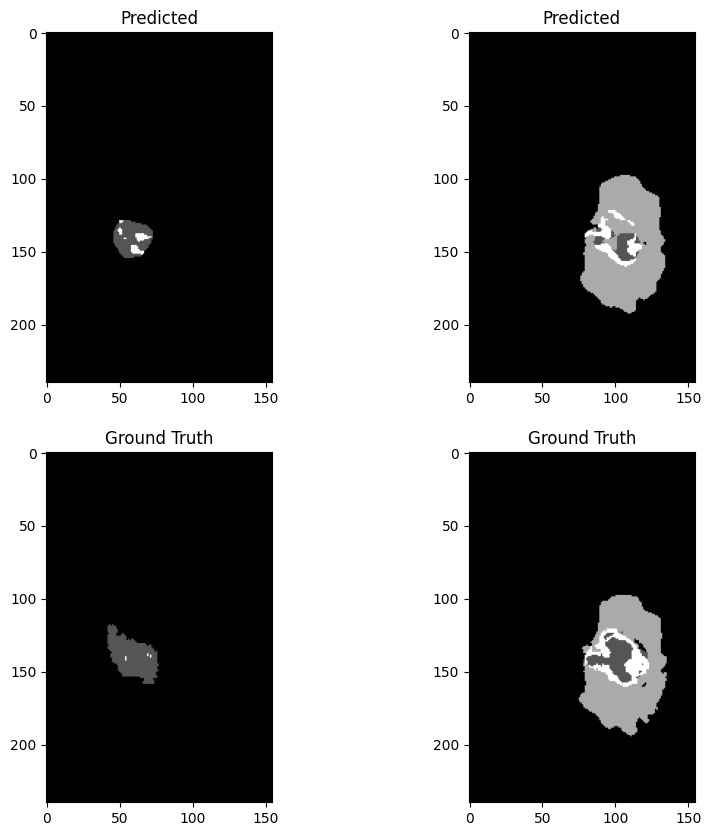

100%|██████████| 39/39 [04:38<00:00,  7.14s/it]


Average Validation Loss: 0.033842794167307705

Average Validation DSC: [0.99687242 0.49668674 0.78939941 0.43324097]
Average Validation ASSD: [  0.40709991 113.06276181  44.84596148  49.95578308]
Epoch 21/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


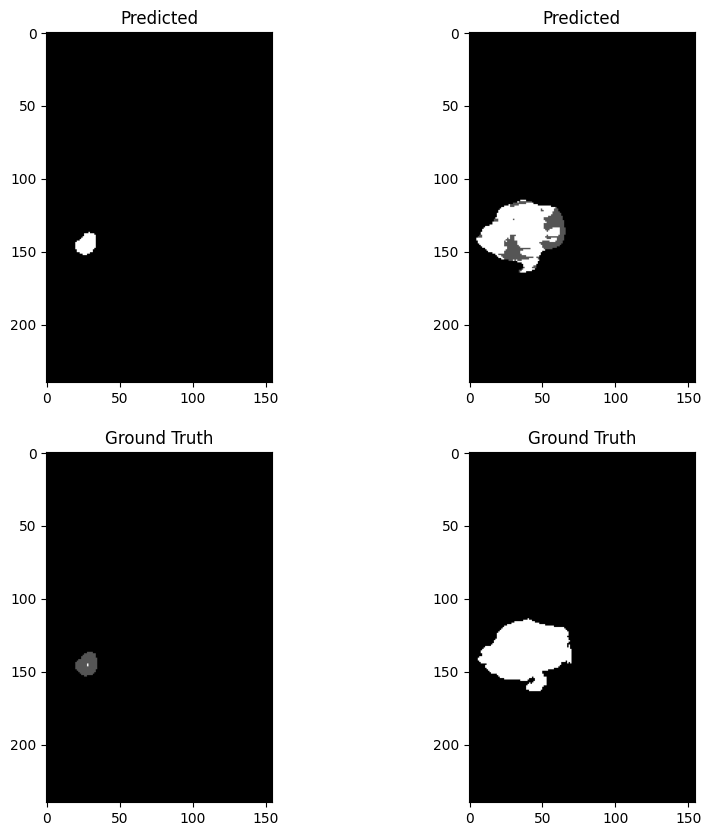

100%|██████████| 156/156 [21:00<00:00,  8.08s/it]



Average Training Loss: 0.02865601622332365

Average Training DSC: [0.99725131 0.5376882  0.80607753 0.50751359]
Average Training ASSD: [ 0.31006903 94.79653985 43.6924548  32.90903056]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


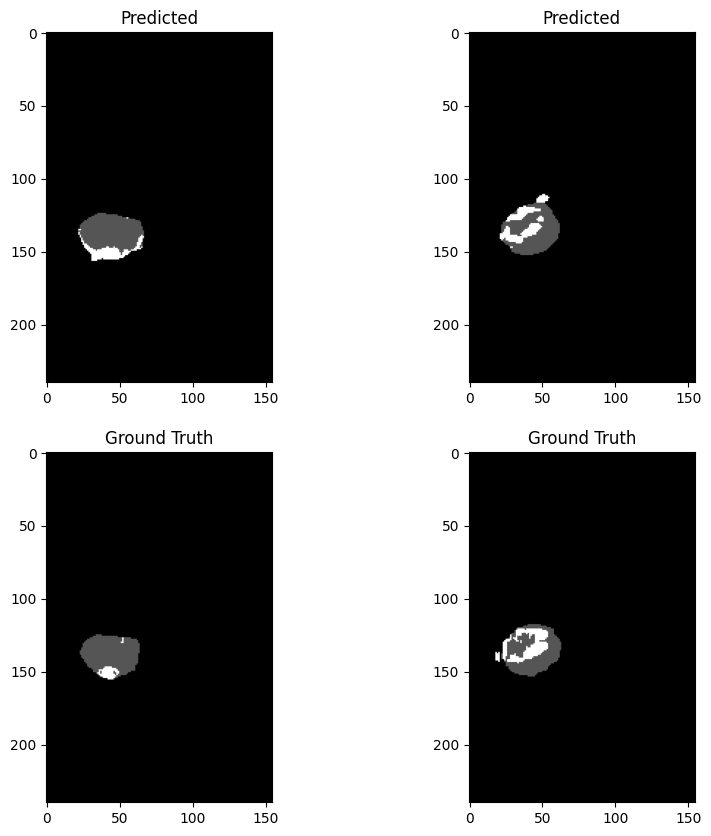

100%|██████████| 39/39 [05:09<00:00,  7.95s/it]


Average Validation Loss: 0.030762494374544192

Average Validation DSC: [0.99720313 0.55513085 0.69777595 0.49076435]
Average Validation ASSD: [ 0.28915577 97.60600597 75.41782921 24.31796455]
Epoch 22/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


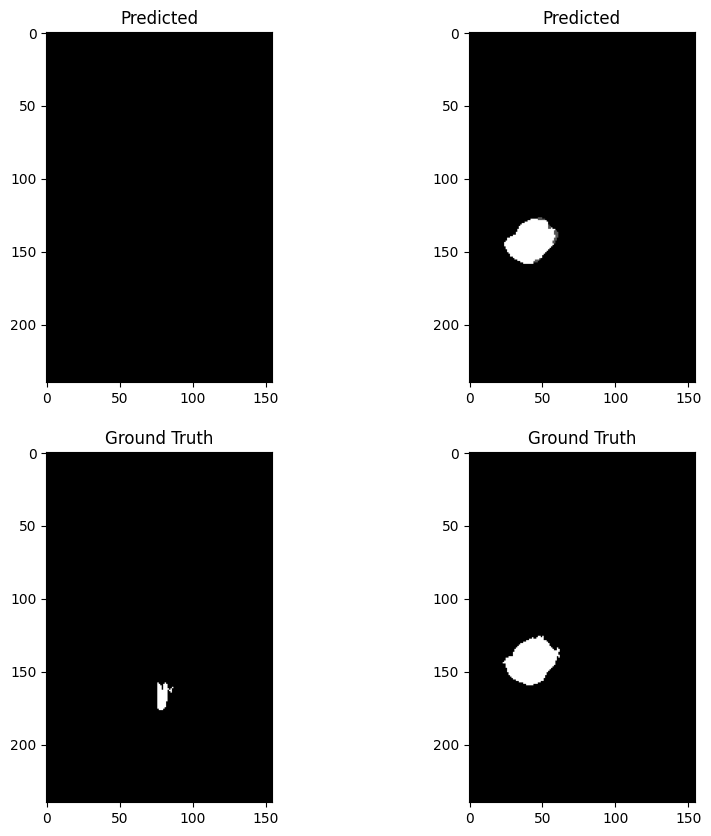

100%|██████████| 156/156 [20:37<00:00,  7.93s/it]



Average Training Loss: 0.02570608616448366

Average Training DSC: [0.99751556 0.58589192 0.82304924 0.53383788]
Average Training ASSD: [ 0.28018742 85.64822611 39.37198274 31.04659111]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


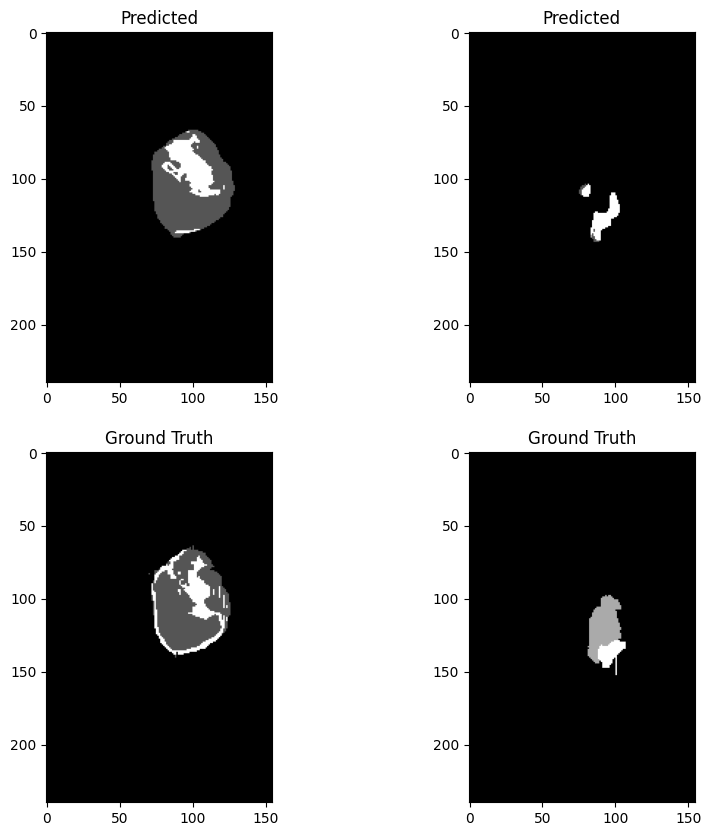

100%|██████████| 39/39 [04:56<00:00,  7.60s/it]


Average Validation Loss: 0.032568336058503546

Average Validation DSC: [0.99682631 0.51463024 0.83749991 0.42144915]
Average Validation ASSD: [  0.36654863 114.24574575  35.46237706  50.32543306]
Epoch 23/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


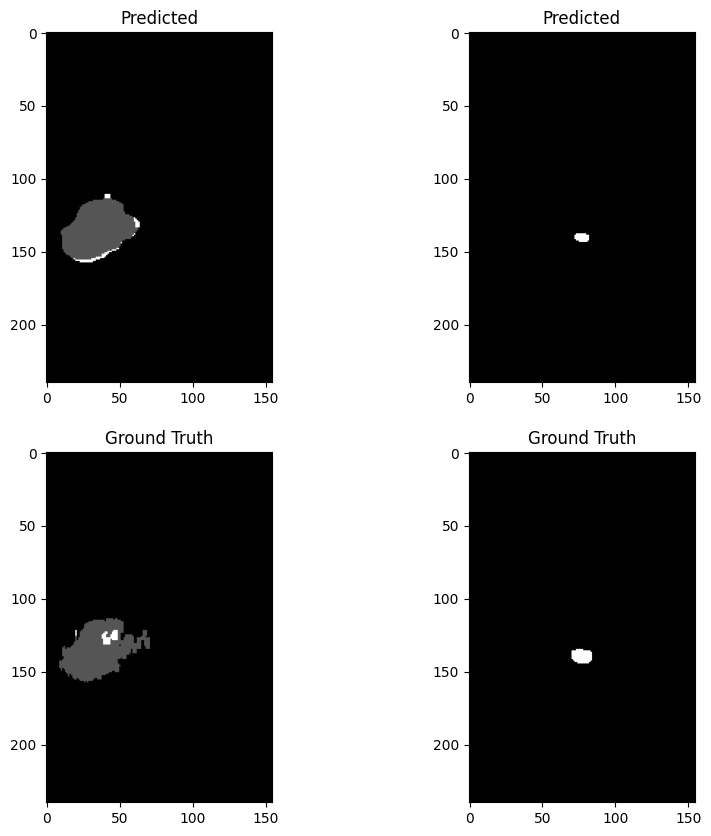

100%|██████████| 156/156 [20:40<00:00,  7.95s/it]



Average Training Loss: 0.024189827068207357

Average Training DSC: [0.99757962 0.61911316 0.83706098 0.54799602]
Average Training ASSD: [ 0.26822542 79.88563853 35.34303004 30.93645677]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


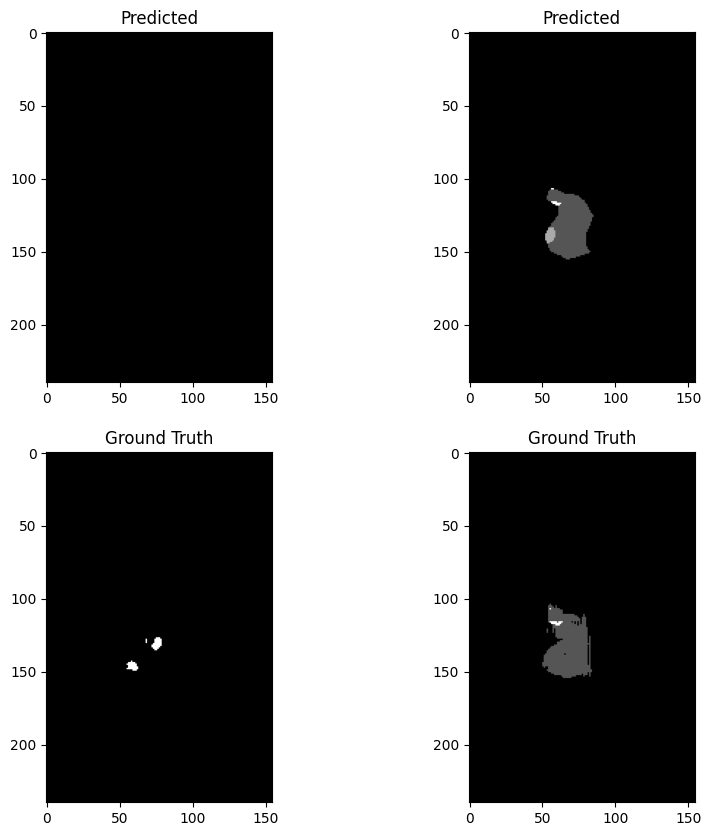

100%|██████████| 39/39 [05:08<00:00,  7.92s/it]


Average Validation Loss: 0.02527289350445454

Average Validation DSC: [0.99739644 0.61656548 0.84742671 0.49580967]
Average Validation ASSD: [ 0.2957992  86.2557003  33.81140739 38.15612928]
Epoch 24/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


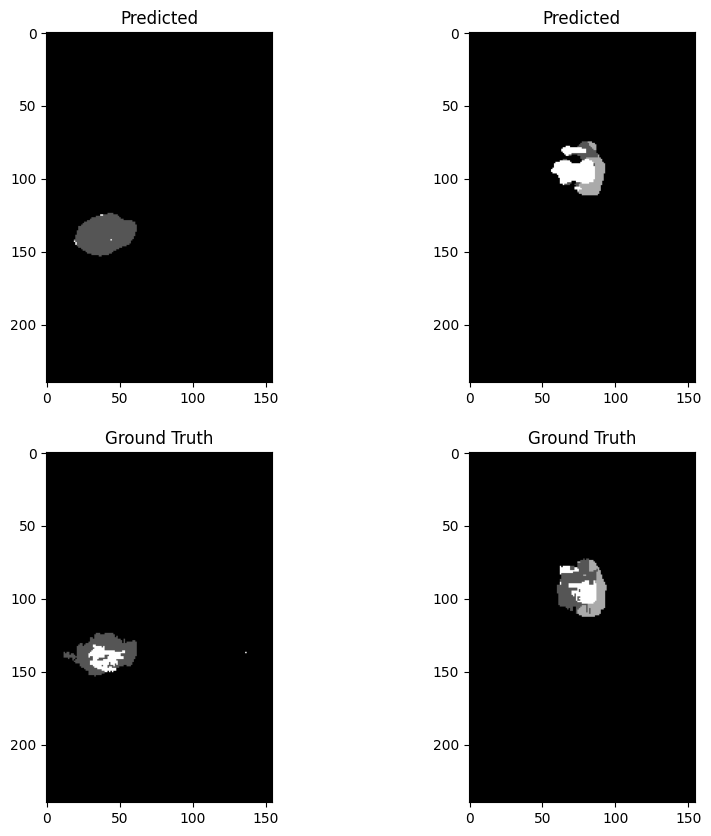

100%|██████████| 156/156 [20:16<00:00,  7.80s/it]



Average Training Loss: 0.022400144917460587

Average Training DSC: [0.99769996 0.65827215 0.83809026 0.56462967]
Average Training ASSD: [ 0.24422407 69.73601143 35.19992361 30.27759959]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


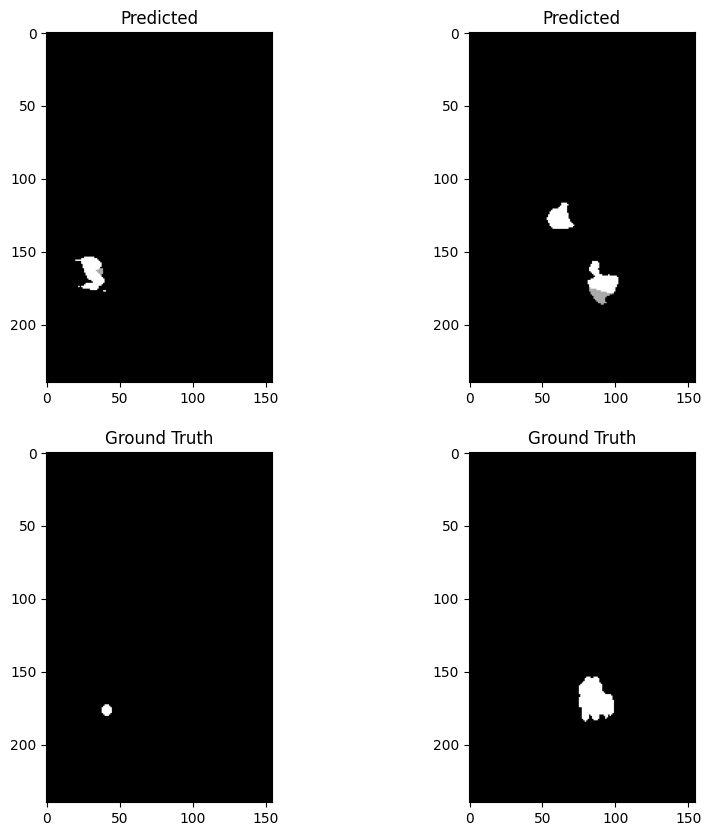

100%|██████████| 39/39 [05:14<00:00,  8.06s/it]


Average Validation Loss: 0.024484212008806374

Average Validation DSC: [0.99753588 0.60601882 0.76376046 0.56084078]
Average Validation ASSD: [ 0.25930702 92.25678837 56.76955197 21.7116922 ]
Epoch 25/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


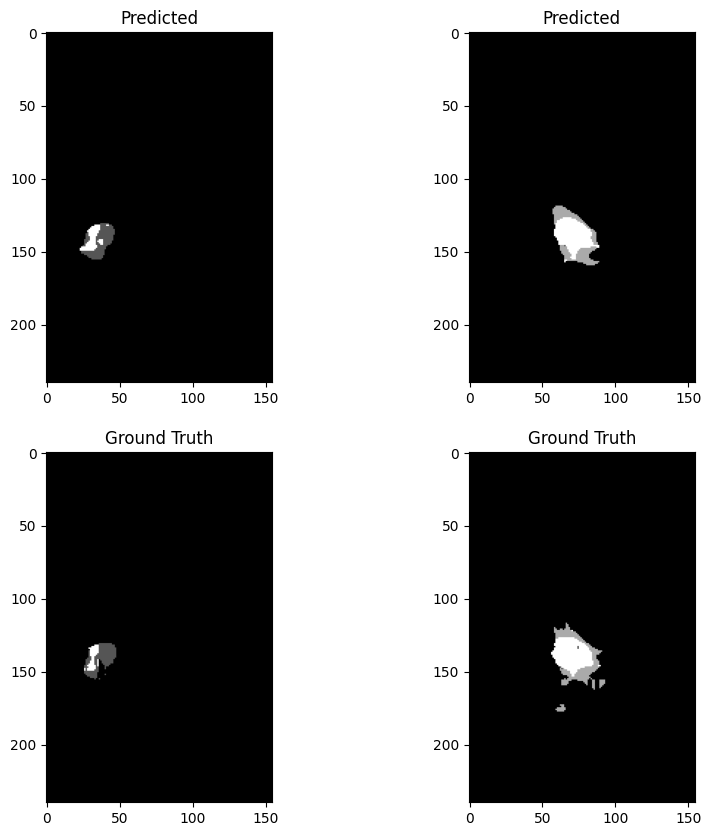

100%|██████████| 156/156 [20:05<00:00,  7.72s/it]



Average Training Loss: 0.02103721680573355

Average Training DSC: [0.99775749 0.70112312 0.85037066 0.57967313]
Average Training ASSD: [ 0.24393676 59.16542307 30.35020236 31.56833917]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


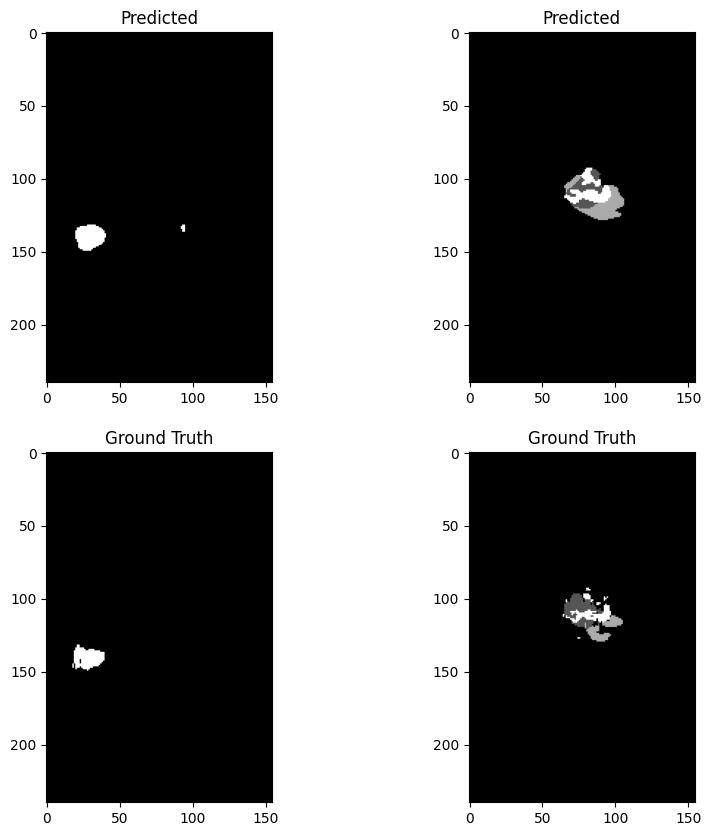

100%|██████████| 39/39 [05:05<00:00,  7.83s/it]


Average Validation Loss: 0.022482080194048393

Average Validation DSC: [0.99765106 0.70428716 0.79012081 0.60346477]
Average Validation ASSD: [ 0.24965107 53.22037303 48.70170658 25.96700458]
Epoch 26/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


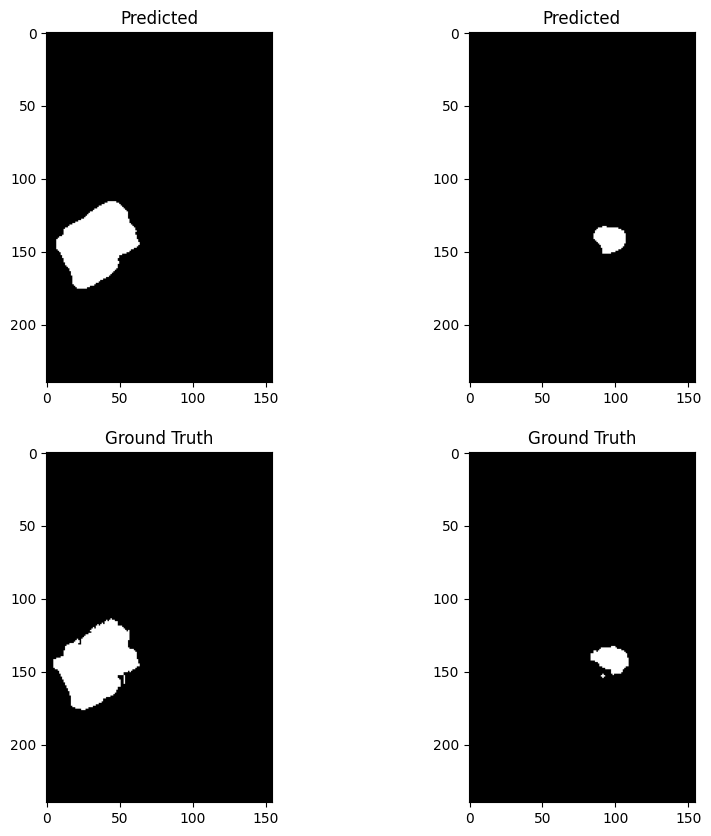

100%|██████████| 156/156 [20:26<00:00,  7.86s/it]



Average Training Loss: 0.019667498618125532

Average Training DSC: [0.99785869 0.72604686 0.85876946 0.59315319]
Average Training ASSD: [ 0.22684103 52.34033534 28.56320477 30.91523022]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


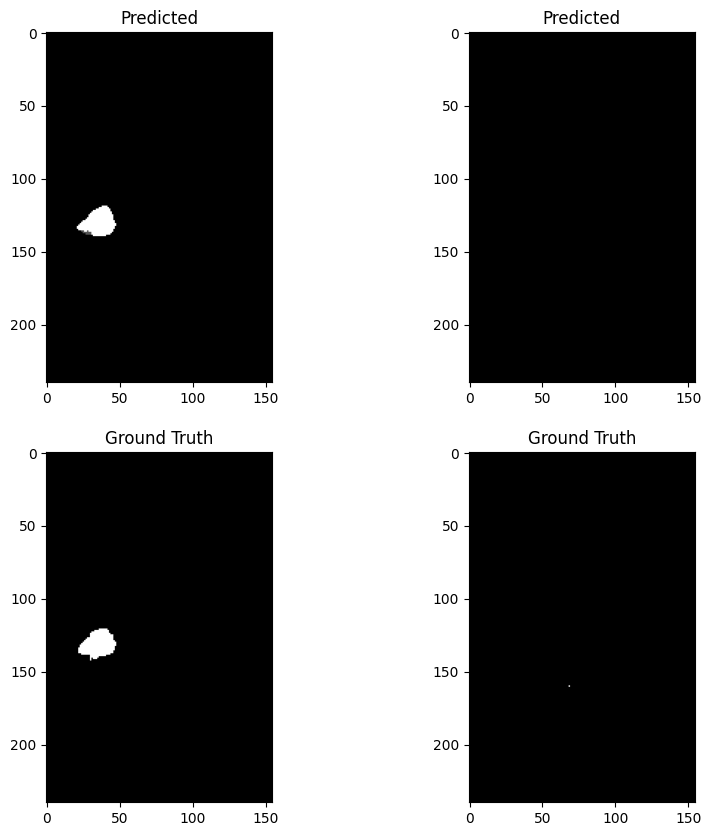

100%|██████████| 39/39 [04:29<00:00,  6.90s/it]


Average Validation Loss: 0.023067781295722876

Average Validation DSC: [0.99768602 0.71335104 0.86837173 0.61657717]
Average Validation ASSD: [ 0.23754869 39.06217646 23.64021869 25.57510124]
Epoch 27/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


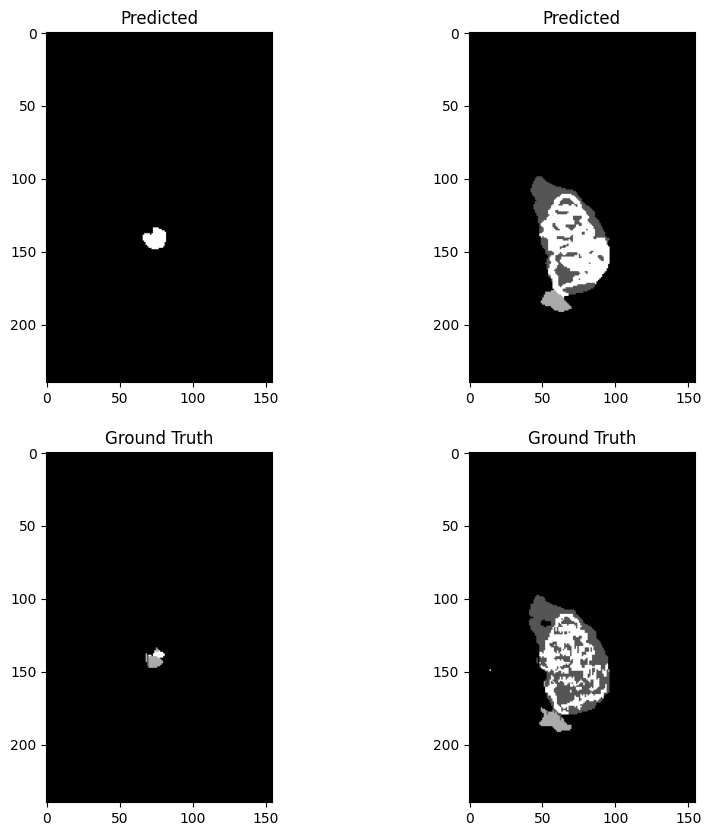

100%|██████████| 156/156 [20:50<00:00,  8.01s/it]



Average Training Loss: 0.018598393507254046

Average Training DSC: [0.99793599 0.74326774 0.8640469  0.60305932]
Average Training ASSD: [ 0.22063084 49.32770347 26.82761429 33.6323425 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


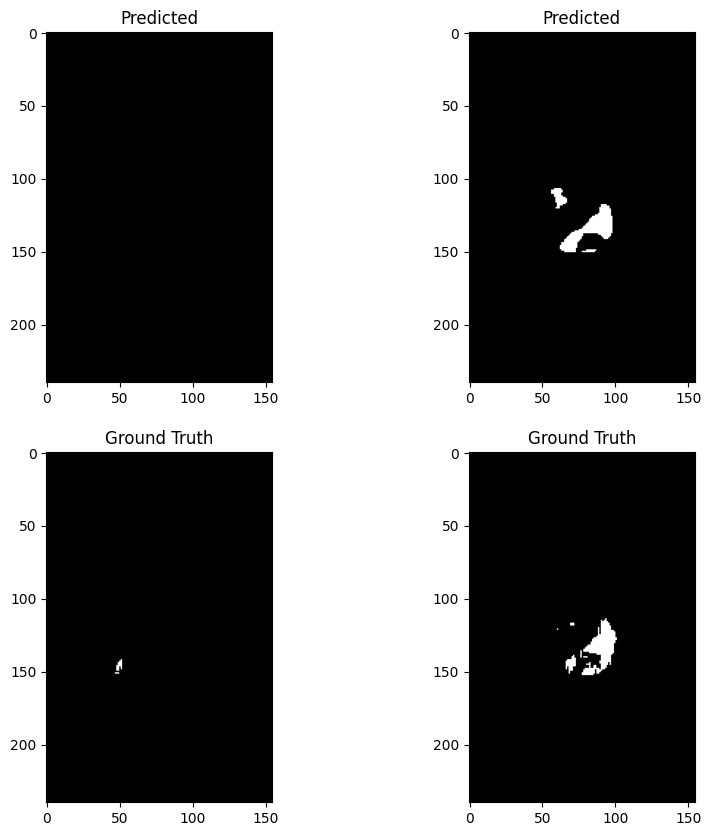

100%|██████████| 39/39 [04:57<00:00,  7.62s/it]


Average Validation Loss: 0.020302740546564262

Average Validation DSC: [0.99780296 0.70639394 0.86861656 0.62288573]
Average Validation ASSD: [ 0.23468931 58.4256172  22.94405035 24.10338083]
Epoch 28/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


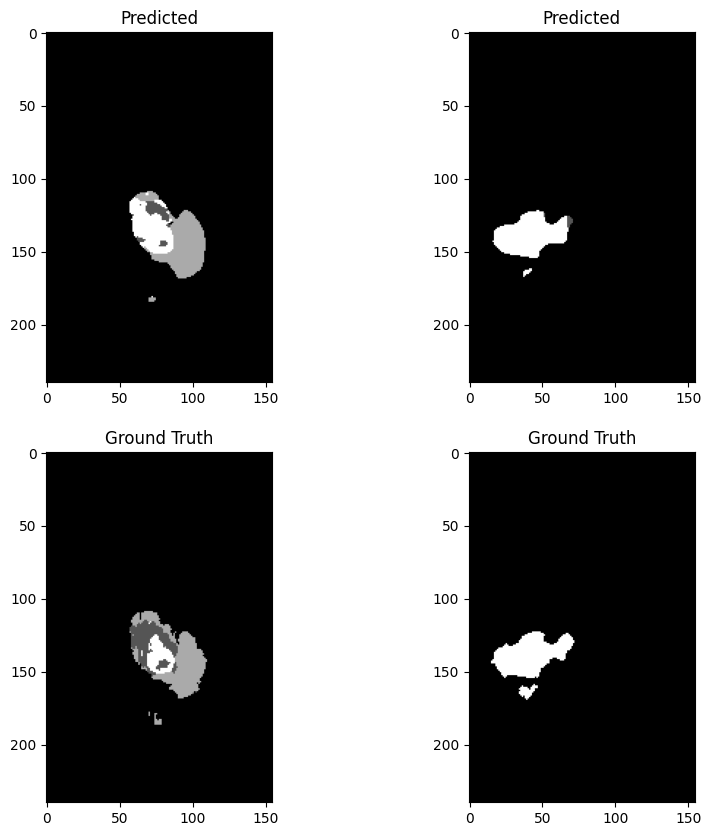

100%|██████████| 156/156 [20:38<00:00,  7.94s/it]



Average Training Loss: 0.017940570373470202

Average Training DSC: [0.9980103  0.76326479 0.86775794 0.6129157 ]
Average Training ASSD: [ 0.20861491 43.49464204 25.528205   33.75469552]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


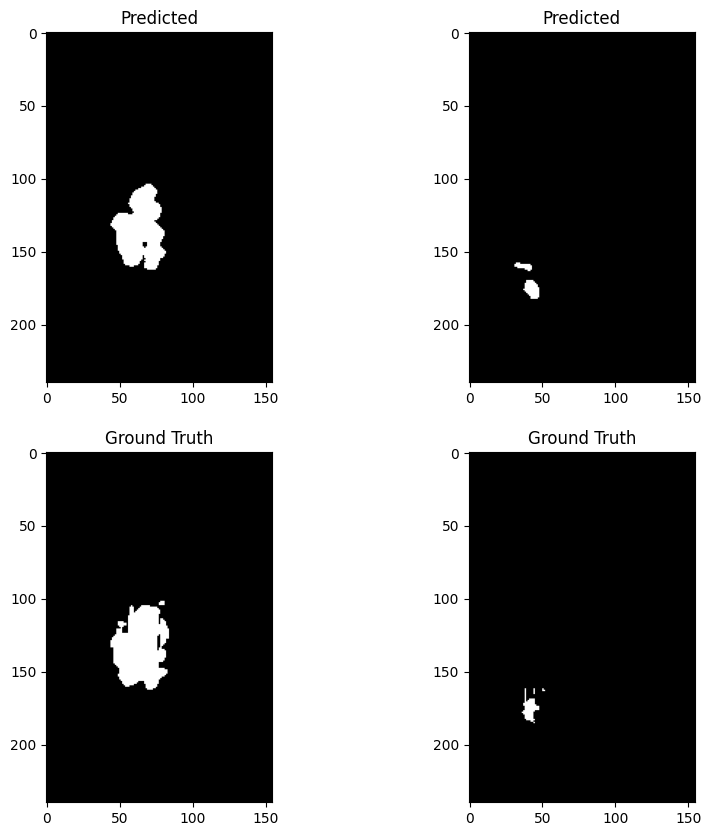

100%|██████████| 39/39 [05:18<00:00,  8.17s/it]


Average Validation Loss: 0.02340134734717699

Average Validation DSC: [0.99768037 0.73100468 0.86901186 0.60777092]
Average Validation ASSD: [ 0.24457397 35.24095026 21.31152429 25.95577855]
Epoch 29/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


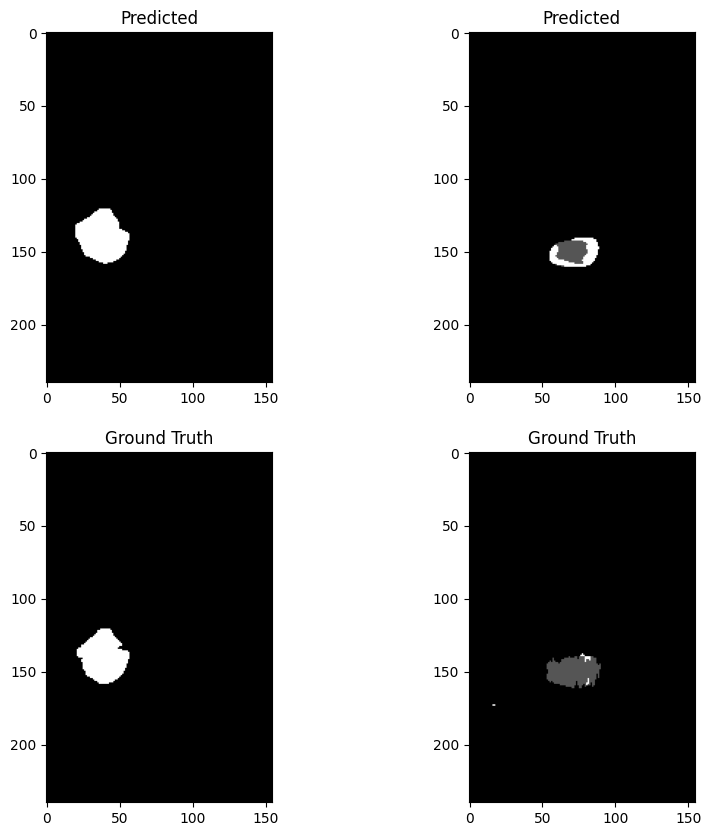

100%|██████████| 156/156 [20:18<00:00,  7.81s/it]



Average Training Loss: 0.01741333487921227

Average Training DSC: [0.99802436 0.77243283 0.87417844 0.61896952]
Average Training ASSD: [ 0.20893828 40.00705898 23.78294542 35.96438293]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


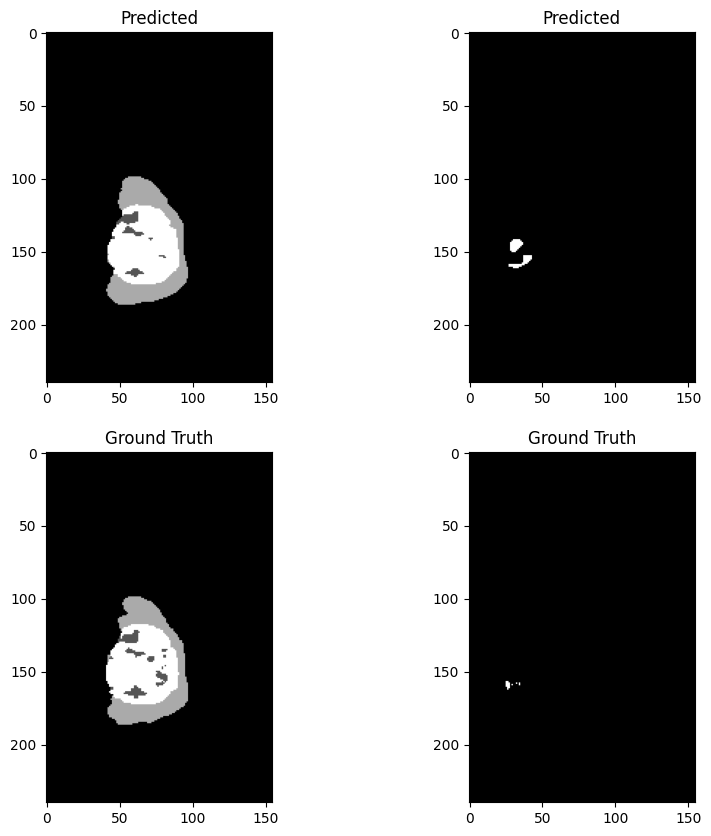

100%|██████████| 39/39 [04:56<00:00,  7.59s/it]


Average Validation Loss: 0.018241887100231953

Average Validation DSC: [0.99796446 0.75563283 0.88023716 0.59641931]
Average Validation ASSD: [ 0.22244143 48.10566331 22.16601915 37.60239839]
Epoch 30/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


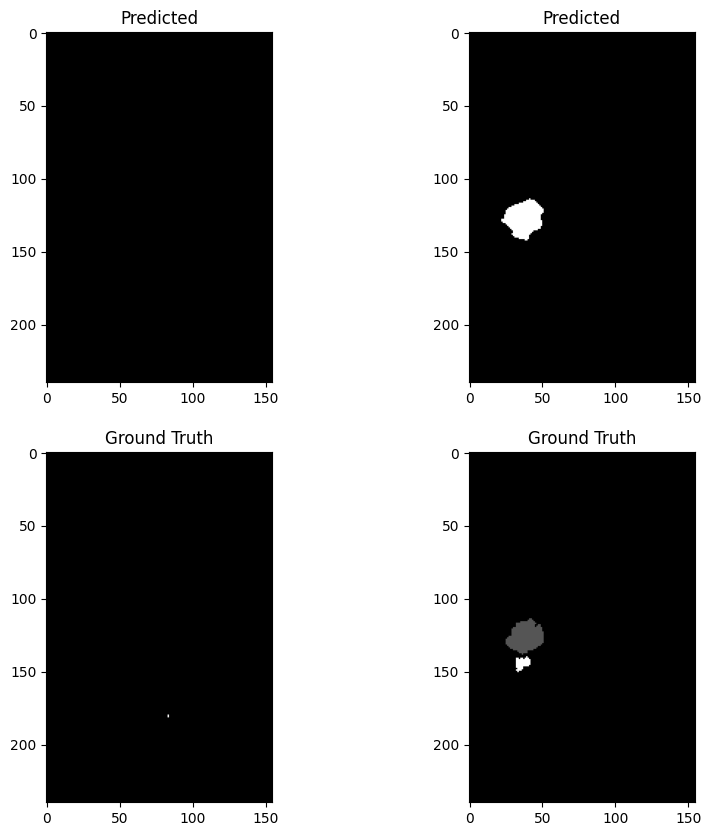

100%|██████████| 156/156 [20:02<00:00,  7.71s/it]



Average Training Loss: 0.015392177135277635

Average Training DSC: [0.99819903 0.81495349 0.89059736 0.64146075]
Average Training ASSD: [ 0.18574093 28.59525138 19.40368819 35.94719254]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


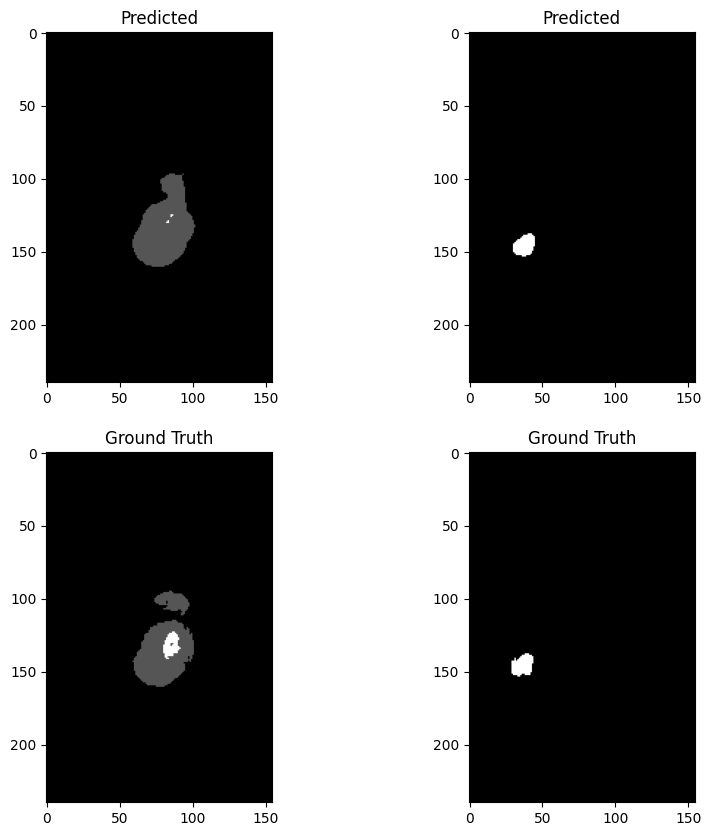

100%|██████████| 39/39 [05:08<00:00,  7.90s/it]


Average Validation Loss: 0.018611752165433686

Average Validation DSC: [0.99801884 0.77740639 0.89666827 0.5841036 ]
Average Validation ASSD: [ 0.22388032 39.58902812 17.93280433 41.09120969]
Epoch 31/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


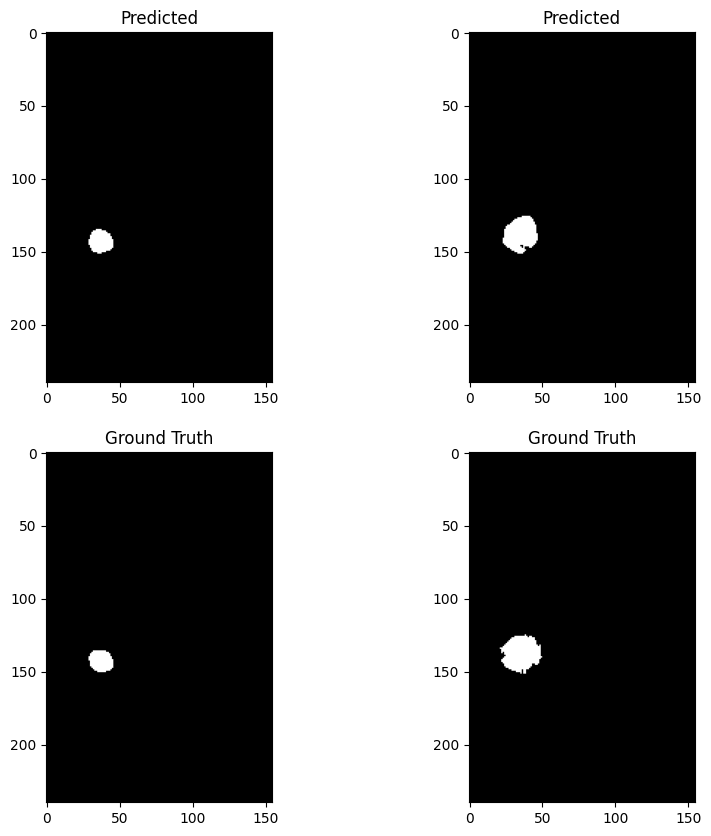

100%|██████████| 156/156 [21:04<00:00,  8.11s/it]



Average Training Loss: 0.015415385717717119

Average Training DSC: [0.99823849 0.81308962 0.88961534 0.64255806]
Average Training ASSD: [ 0.18598196 29.34898768 19.51180976 36.0720079 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


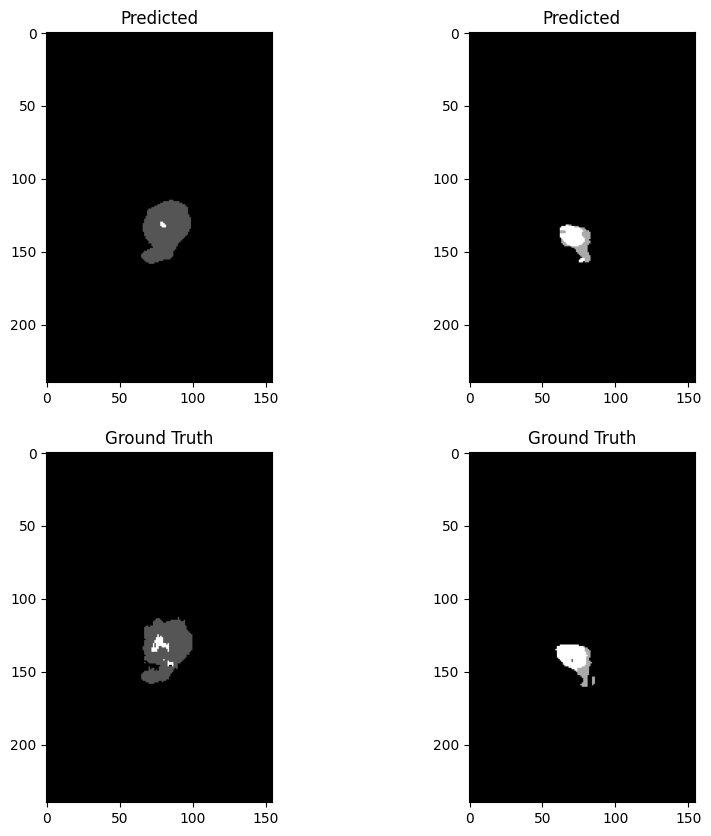

100%|██████████| 39/39 [04:46<00:00,  7.35s/it]


Average Validation Loss: 0.01902596299082805

Average Validation DSC: [0.99800177 0.6495046  0.82468766 0.56972181]
Average Validation ASSD: [ 0.21107773 88.24424636 41.1117967  46.29981125]
Epoch 32/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


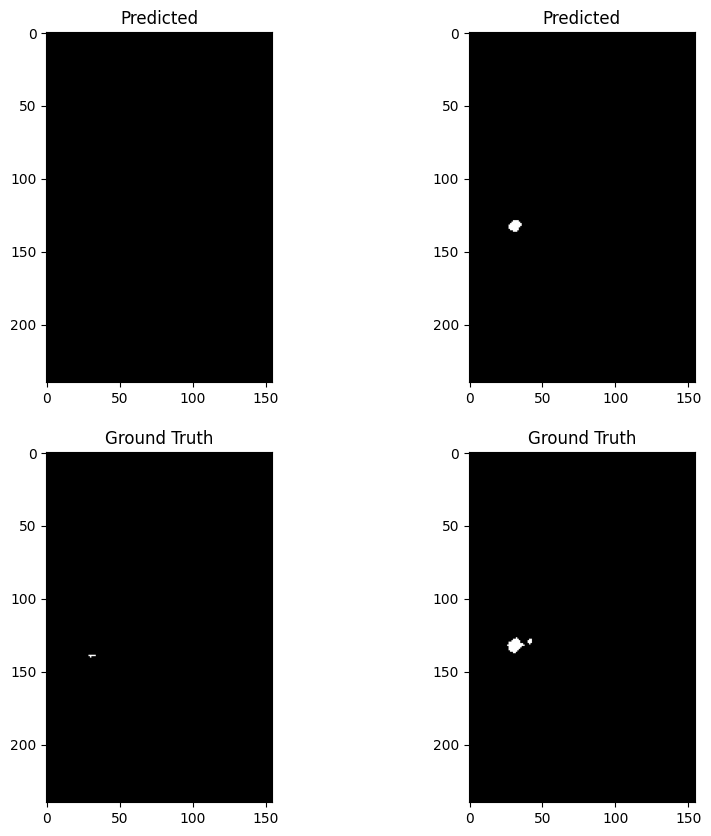

100%|██████████| 156/156 [20:57<00:00,  8.06s/it]



Average Training Loss: 0.014929664816755133

Average Training DSC: [0.99825181 0.82022322 0.88939816 0.65049101]
Average Training ASSD: [ 0.17966425 27.69857062 20.16205438 36.20338118]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


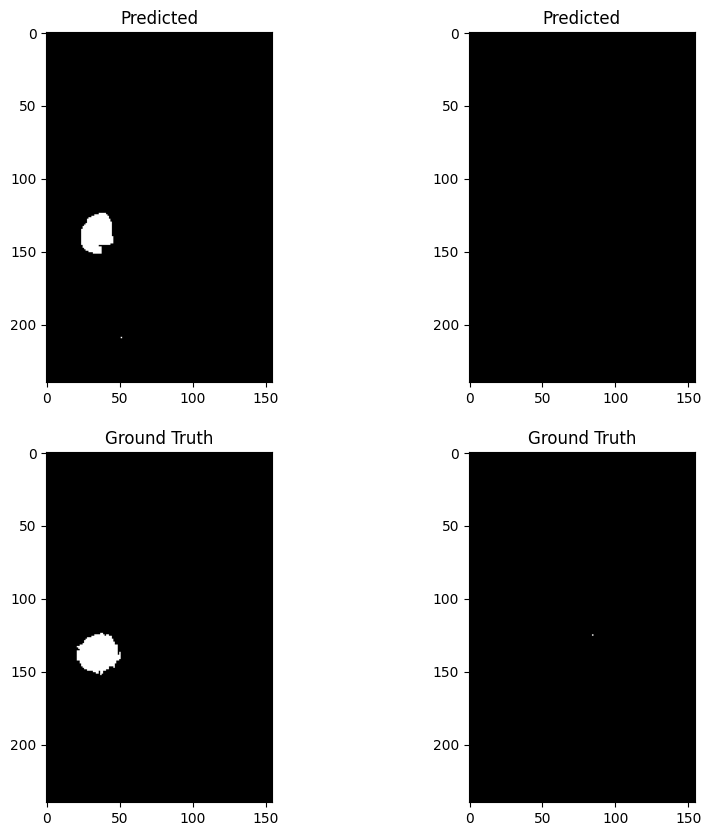

100%|██████████| 39/39 [05:18<00:00,  8.16s/it]


Average Validation Loss: 0.016084499346713226

Average Validation DSC: [0.99815095 0.79004698 0.89344308 0.65532228]
Average Validation ASSD: [ 0.18963804 39.62375644 18.28849507 26.03509446]
Epoch 33/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


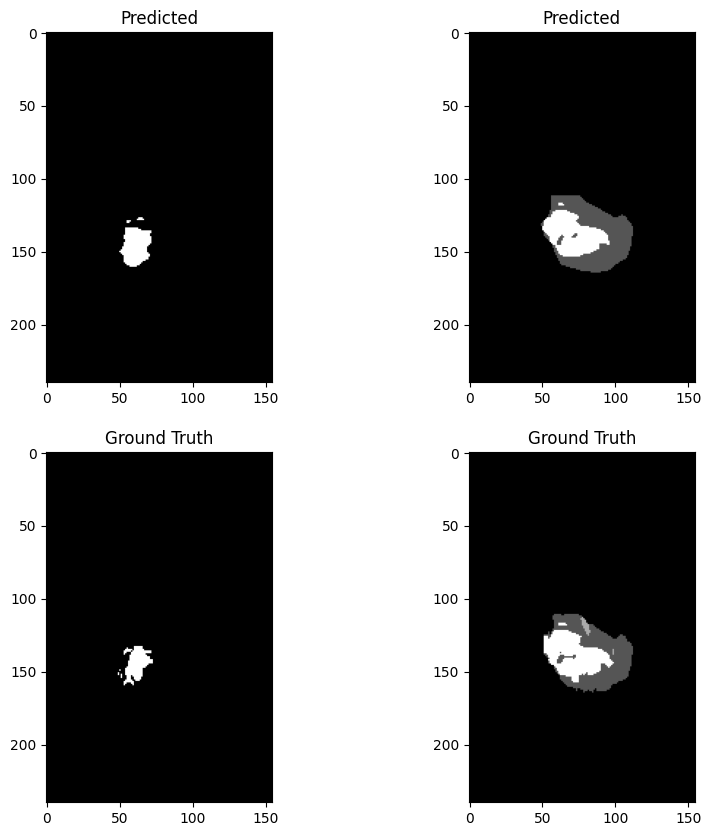

100%|██████████| 156/156 [21:15<00:00,  8.18s/it]



Average Training Loss: 0.013884998398283735

Average Training DSC: [0.99836493 0.8339432  0.89915075 0.66499251]
Average Training ASSD: [ 0.16557244 24.68085492 17.23427566 35.46315865]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


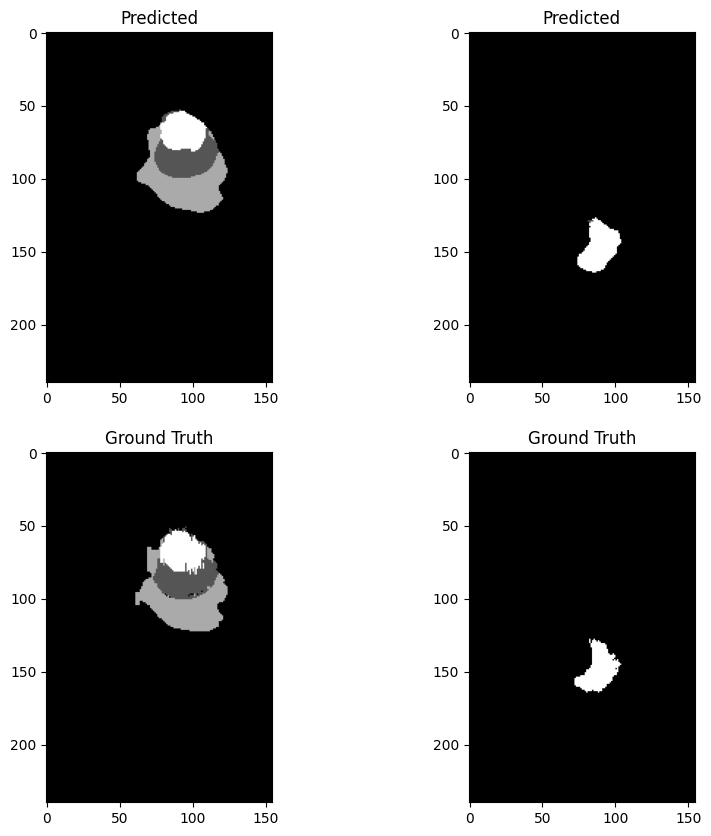

100%|██████████| 39/39 [04:35<00:00,  7.08s/it]


Average Validation Loss: 0.015405606239652023

Average Validation DSC: [0.99829583 0.83828941 0.90512232 0.67967916]
Average Validation ASSD: [ 0.18344205 20.18997023 16.26569338 31.77140431]
Epoch 34/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


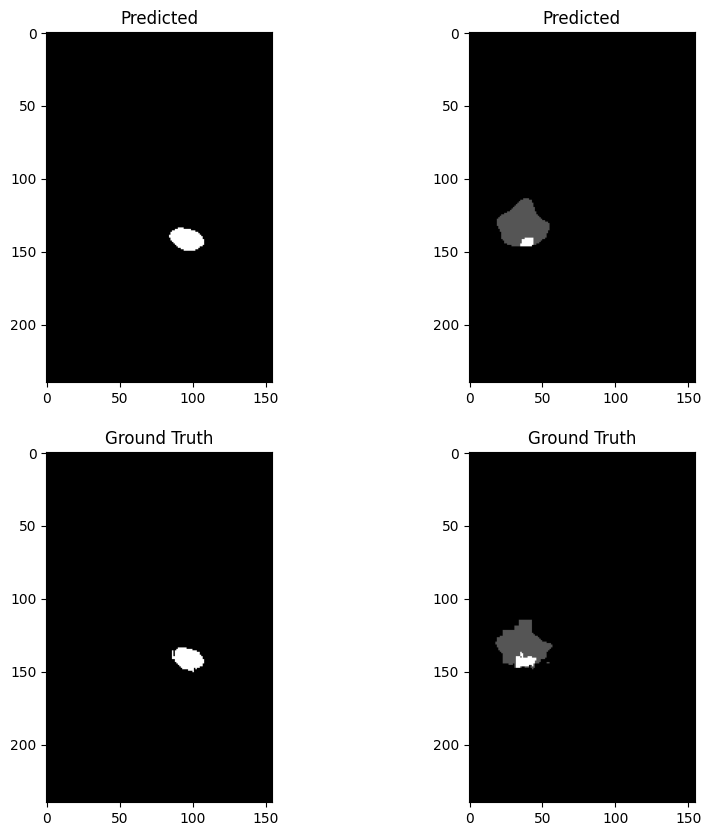

100%|██████████| 156/156 [20:29<00:00,  7.88s/it]



Average Training Loss: 0.01313163154424192

Average Training DSC: [0.99841263 0.85464515 0.90086898 0.67673057]
Average Training ASSD: [ 0.16191596 19.49522817 16.88963113 38.03827358]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


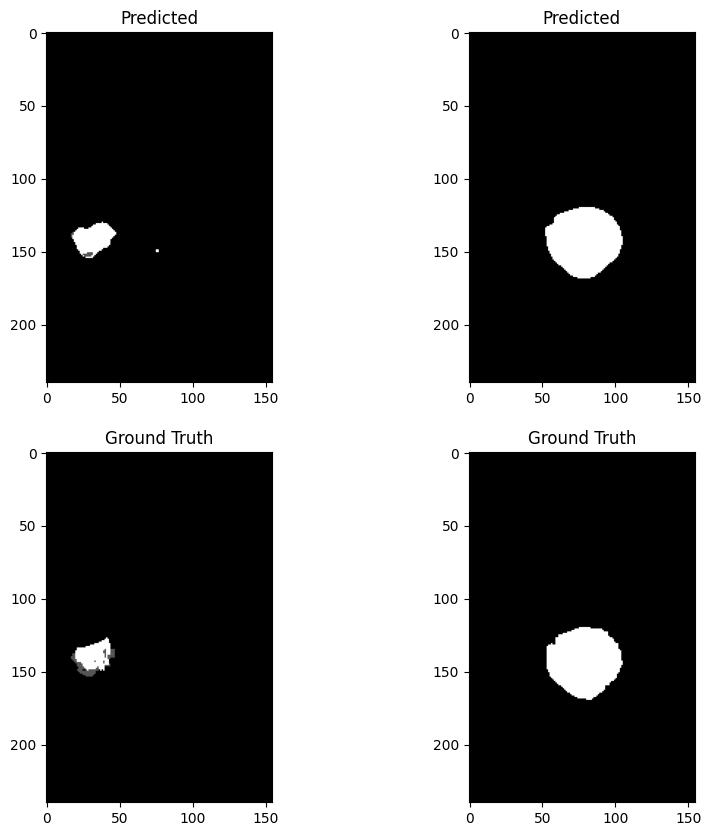

100%|██████████| 39/39 [04:51<00:00,  7.48s/it]


Average Validation Loss: 0.027980850245325994

Average Validation DSC: [0.99667928 0.75038289 0.8617759  0.60317415]
Average Validation ASSD: [ 0.44283558 36.31558584 24.0185724   8.16511866]
Epoch 35/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


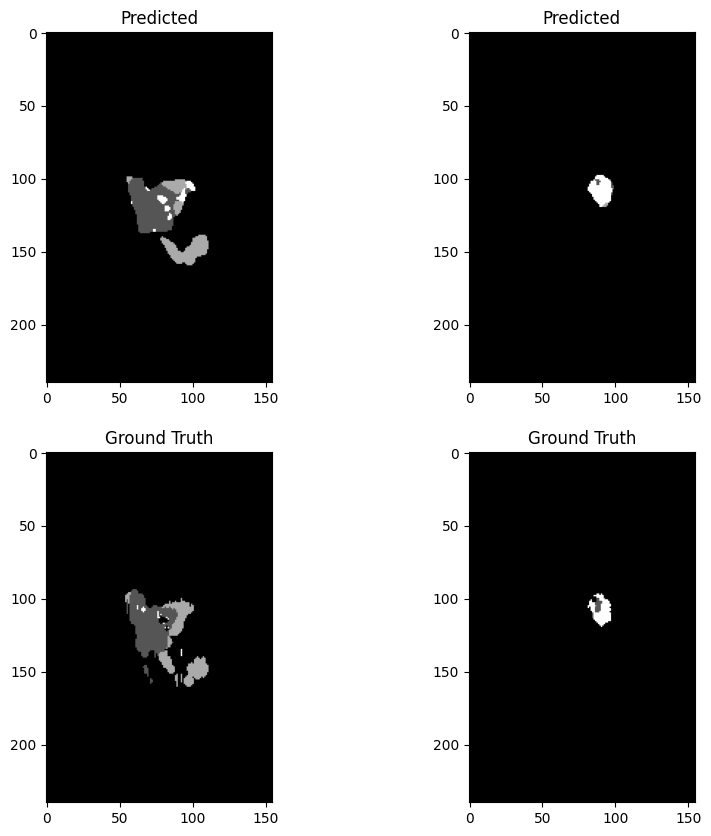

100%|██████████| 156/156 [20:36<00:00,  7.92s/it]



Average Training Loss: 0.014618166961157933

Average Training DSC: [0.99828439 0.82314925 0.88834829 0.65732522]
Average Training ASSD: [ 0.18155242 27.46365165 20.16264079 37.77843605]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


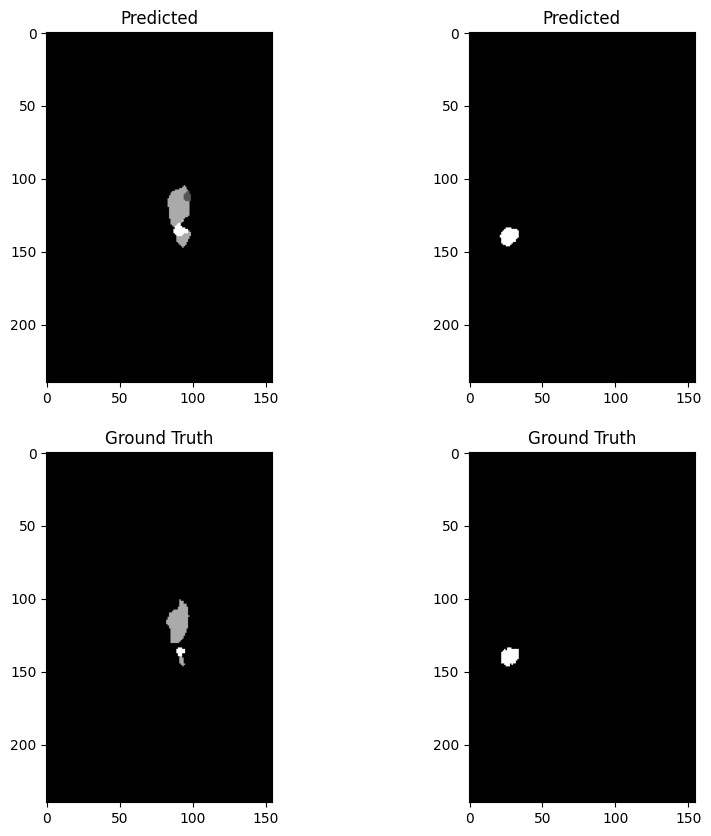

100%|██████████| 39/39 [04:47<00:00,  7.37s/it]


Average Validation Loss: 0.016371924955493364

Average Validation DSC: [0.99805724 0.81340507 0.89992718 0.65700369]
Average Validation ASSD: [ 0.21136352 30.67803598 16.55410939 31.81186694]
Epoch 36/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


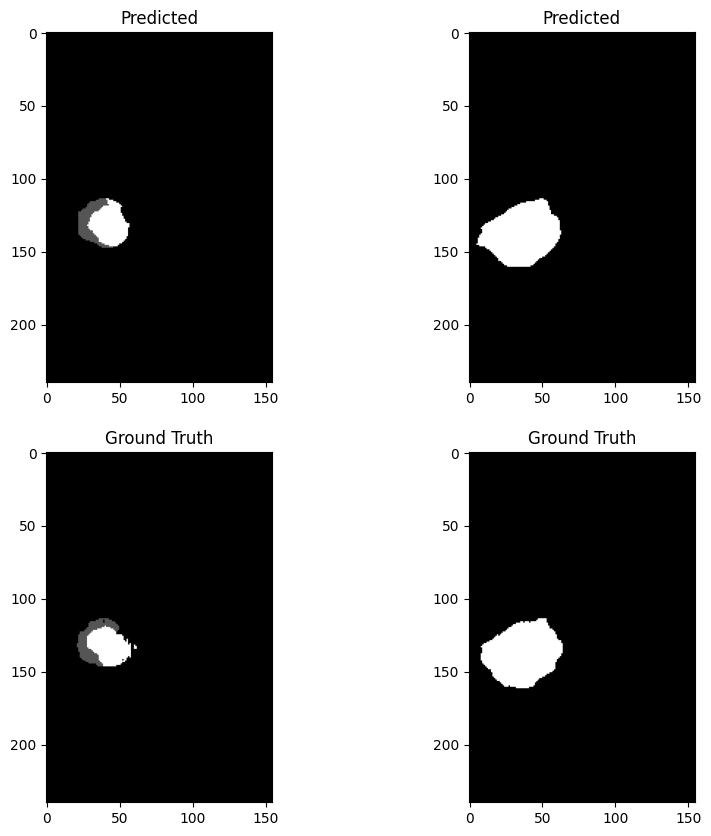

100%|██████████| 156/156 [20:55<00:00,  8.05s/it]



Average Training Loss: 0.013190681287923302

Average Training DSC: [0.99844208 0.84963051 0.8977392  0.67764365]
Average Training ASSD: [ 0.15840317 20.93874297 17.08309765 36.17157369]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


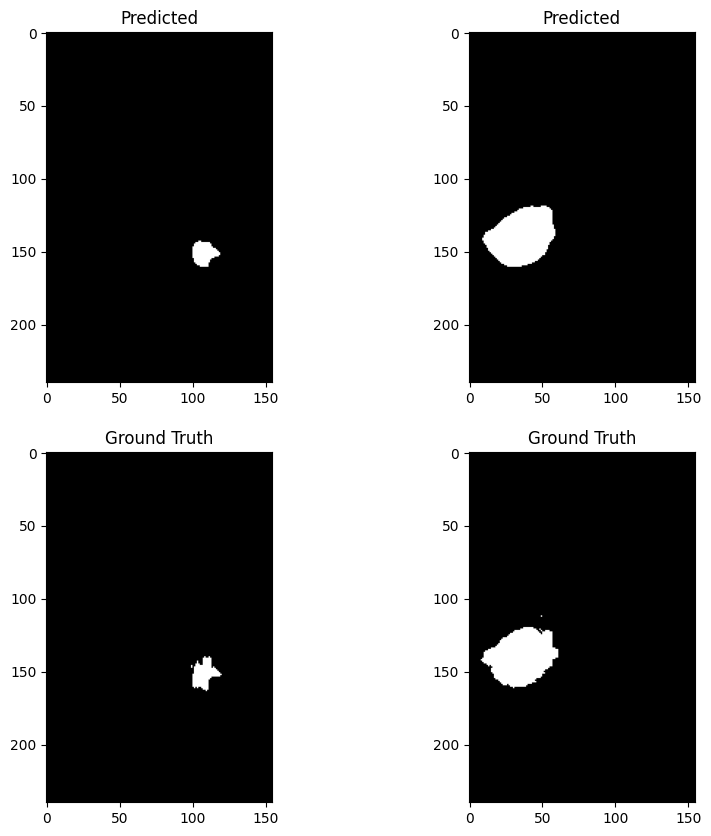

100%|██████████| 39/39 [05:31<00:00,  8.50s/it]


Average Validation Loss: 0.013979275066118974

Average Validation DSC: [0.99839083 0.81273207 0.90936075 0.6699255 ]
Average Validation ASSD: [ 0.1682276  36.60744273 14.63548462 37.72713536]
Epoch 37/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


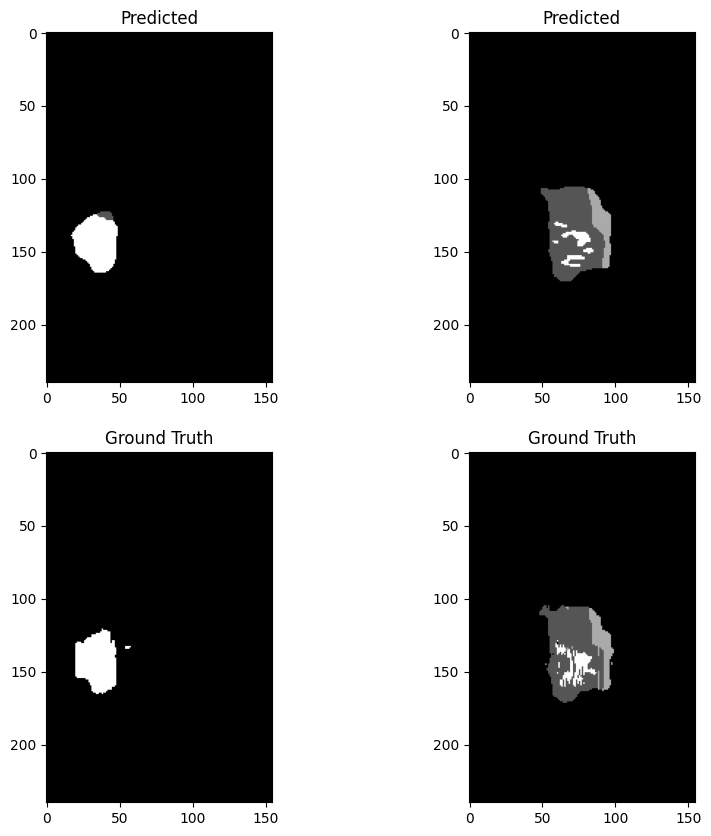

100%|██████████| 156/156 [20:28<00:00,  7.87s/it]



Average Training Loss: 0.012292412584289335

Average Training DSC: [0.99854765 0.85923879 0.90783309 0.68672208]
Average Training ASSD: [ 0.14667947 19.04588903 15.30827676 37.60384274]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


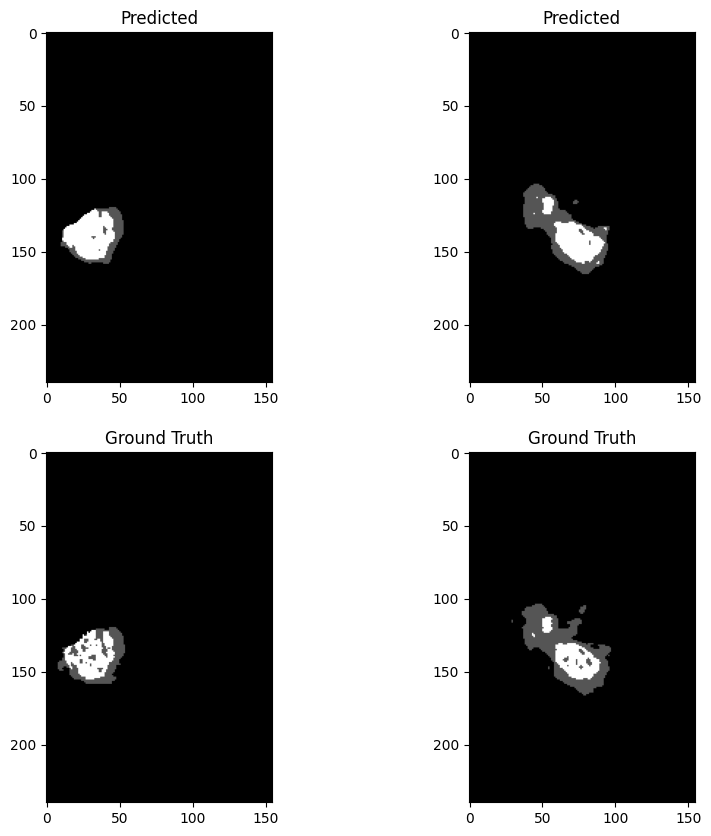

100%|██████████| 39/39 [05:00<00:00,  7.71s/it]


Average Validation Loss: 0.016271451894098368

Average Validation DSC: [0.99817243 0.84188965 0.91173238 0.66574648]
Average Validation ASSD: [ 0.2088965  19.31820195 13.74915603 32.38339268]
Epoch 38/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


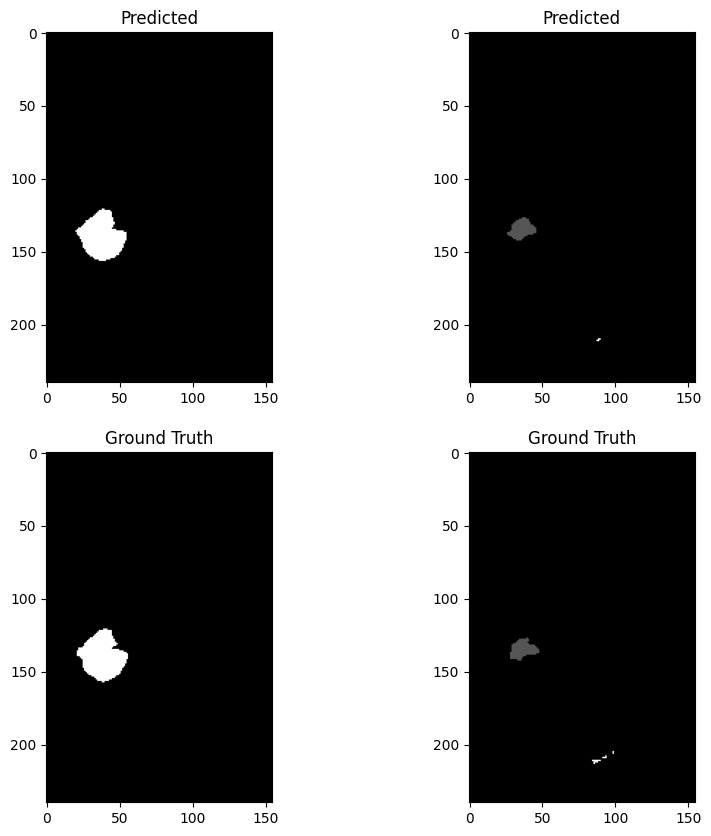

100%|██████████| 156/156 [20:32<00:00,  7.90s/it]



Average Training Loss: 0.012284298149797205

Average Training DSC: [0.99854761 0.85883113 0.90672668 0.68880563]
Average Training ASSD: [ 0.14592786 19.03343937 15.56628488 37.74574504]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


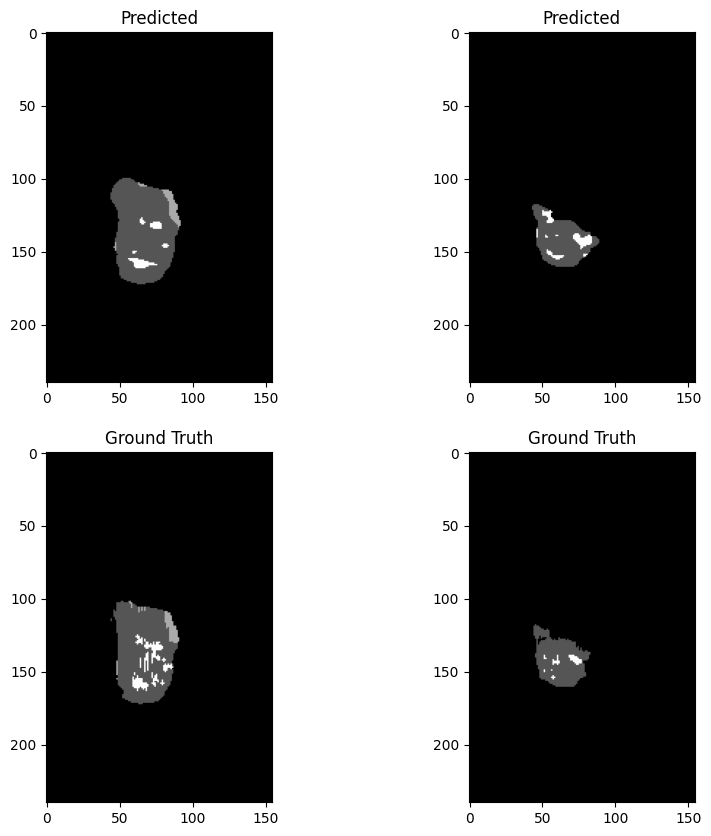

100%|██████████| 39/39 [04:59<00:00,  7.68s/it]


Average Validation Loss: 0.017378780107276563

Average Validation DSC: [0.997795   0.82636231 0.84198141 0.66855099]
Average Validation ASSD: [ 0.23768959 28.91846601 33.53554247 19.73331327]
Epoch 39/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


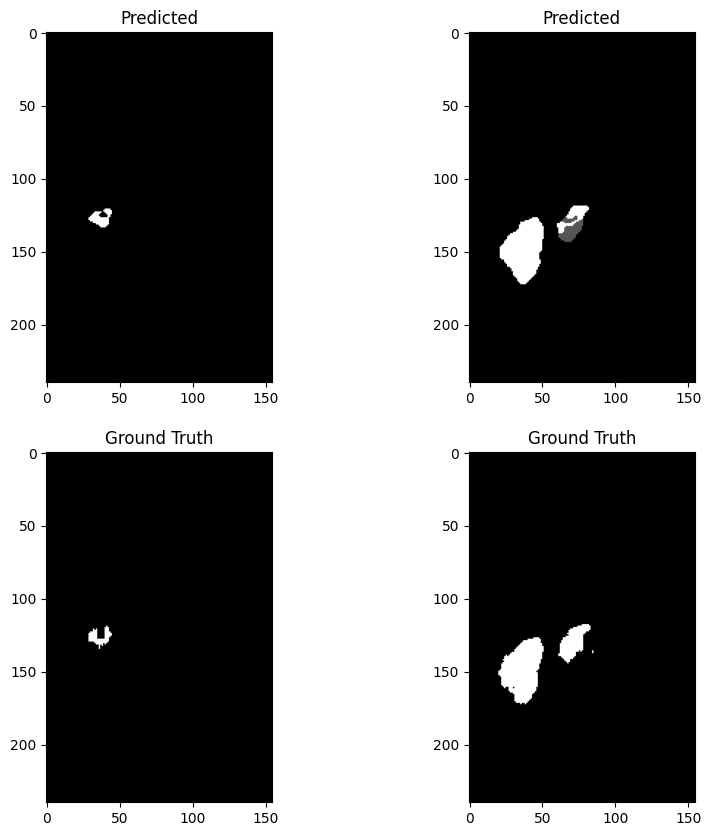

100%|██████████| 156/156 [20:57<00:00,  8.06s/it]



Average Training Loss: 0.011213137807014087

Average Training DSC: [0.99864953 0.88175059 0.91197934 0.70276472]
Average Training ASSD: [ 0.13523824 13.60160601 14.56759745 37.2084794 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


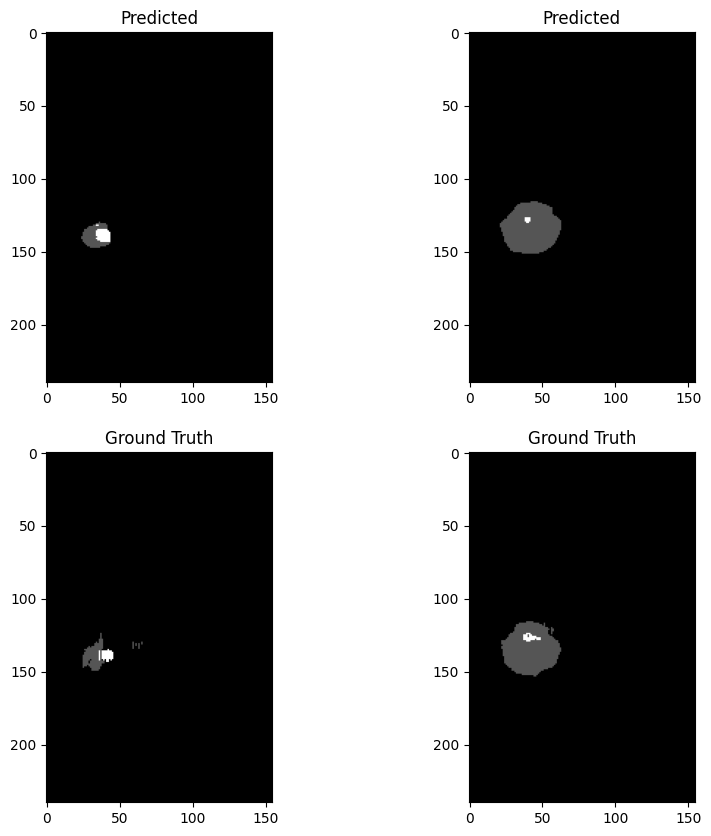

100%|██████████| 39/39 [04:58<00:00,  7.66s/it]


Average Validation Loss: 0.014494565267784473

Average Validation DSC: [0.99836751 0.84334979 0.86236606 0.69417771]
Average Validation ASSD: [ 0.16436676 25.28717775 27.72538262 27.52685606]
Epoch 40/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


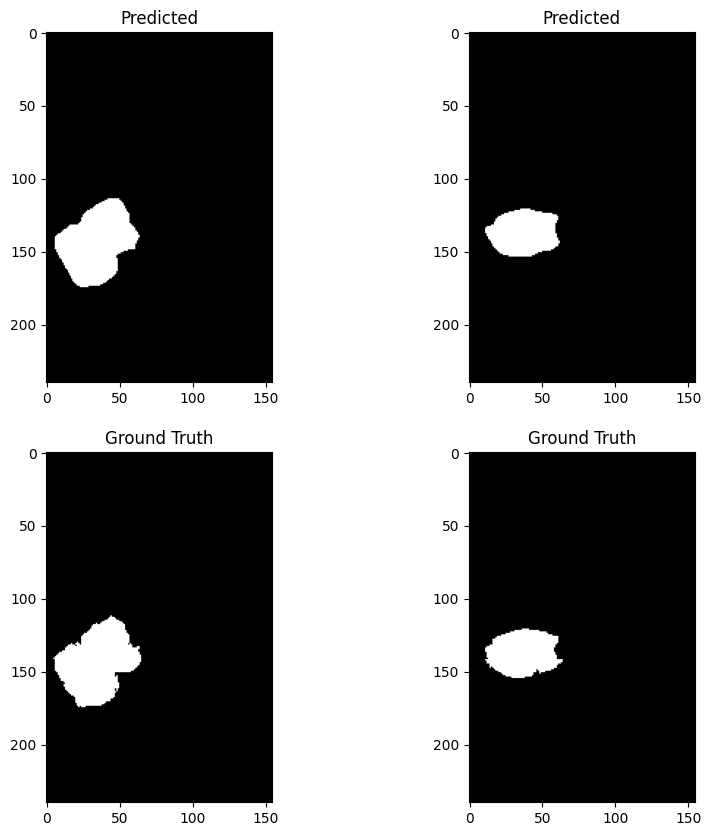

100%|██████████| 156/156 [20:40<00:00,  7.95s/it]



Average Training Loss: 0.010836117897922985

Average Training DSC: [0.99870035 0.88606826 0.91520039 0.70861954]
Average Training ASSD: [ 0.12994615 12.20169966 13.67061838 36.92169277]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


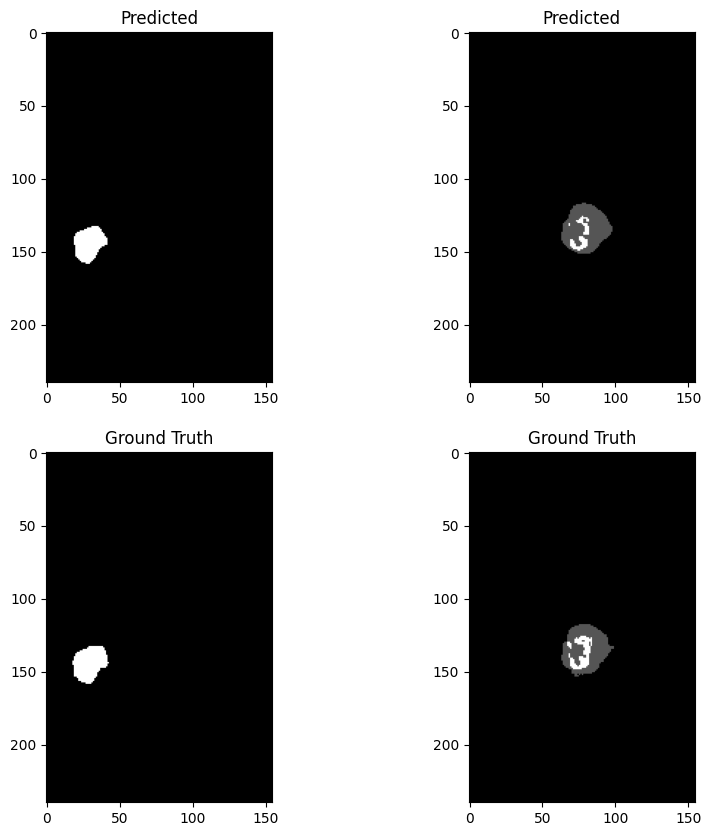

100%|██████████| 39/39 [04:59<00:00,  7.67s/it]


Average Validation Loss: 0.01326345236828694

Average Validation DSC: [0.99851668 0.86277626 0.91620607 0.6856539 ]
Average Validation ASSD: [ 0.15789753 20.15166942 12.65193081 34.73605278]
Epoch 41/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


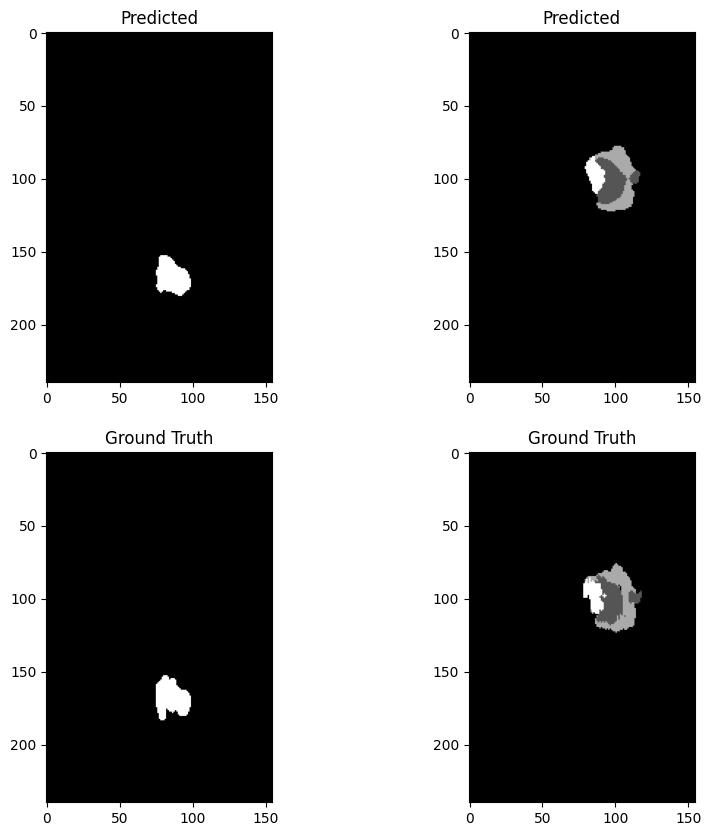

100%|██████████| 156/156 [20:13<00:00,  7.78s/it]



Average Training Loss: 0.011301484821626965

Average Training DSC: [0.99863684 0.8727908  0.91502238 0.70805909]
Average Training ASSD: [ 0.1367438  16.02552059 13.6667895  34.38659434]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


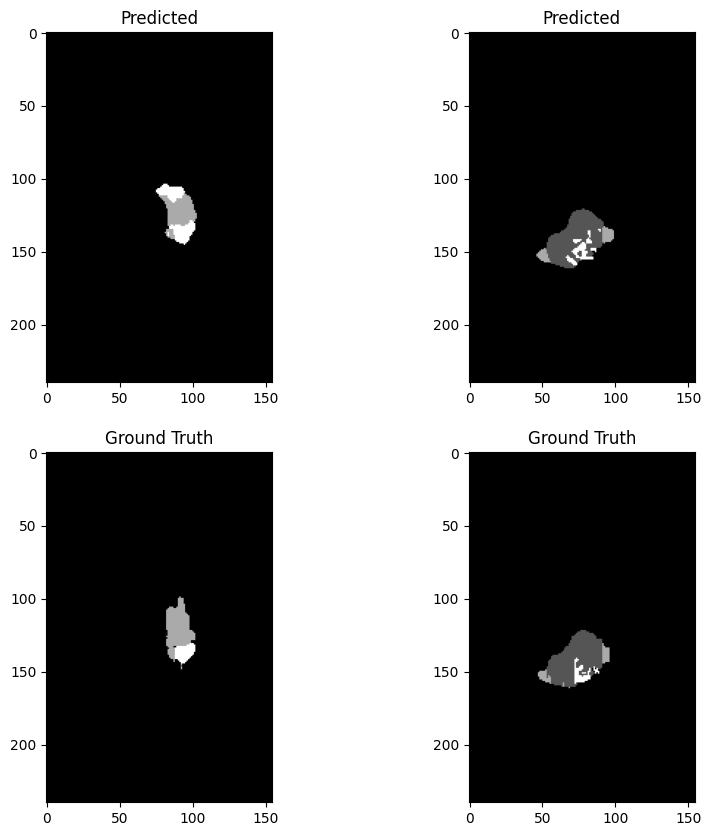

100%|██████████| 39/39 [04:53<00:00,  7.53s/it]


Average Validation Loss: 0.015054544624991907

Average Validation DSC: [0.99832749 0.81168355 0.89864539 0.69774235]
Average Validation ASSD: [ 0.17899343 36.15423958 18.26042138 19.22763393]
Epoch 42/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


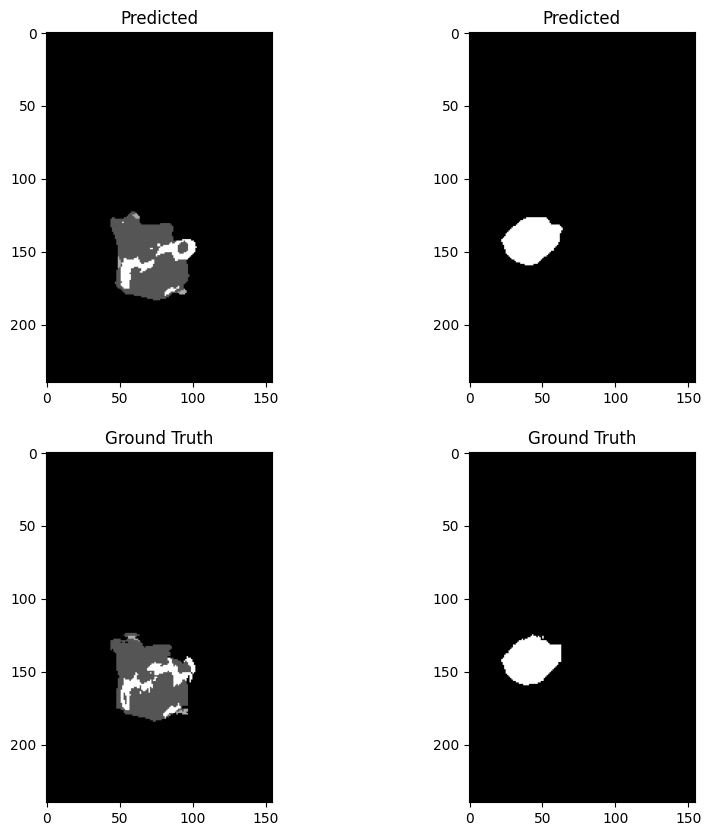

100%|██████████| 156/156 [20:23<00:00,  7.84s/it]



Average Training Loss: 0.010673389549199969

Average Training DSC: [0.99873764 0.88374303 0.92061644 0.71268987]
Average Training ASSD: [ 0.12391792 12.78687757 12.08316216 36.64014668]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


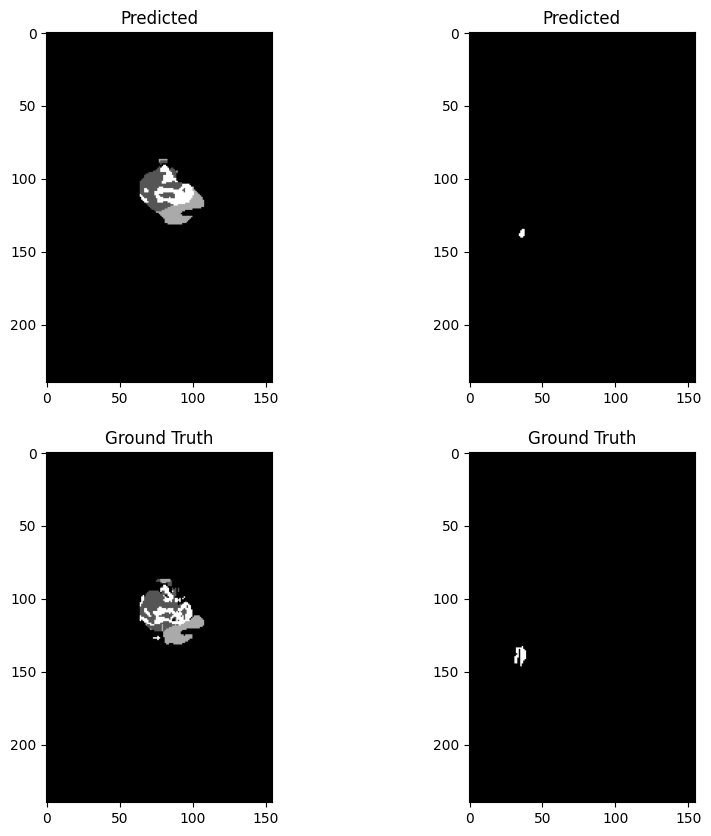

100%|██████████| 39/39 [04:55<00:00,  7.58s/it]


Average Validation Loss: 0.0126993837646949

Average Validation DSC: [0.99858737 0.8594555  0.91720562 0.7035266 ]
Average Validation ASSD: [ 0.14234341 23.43309395 12.28996523 29.61831808]
Epoch 43/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


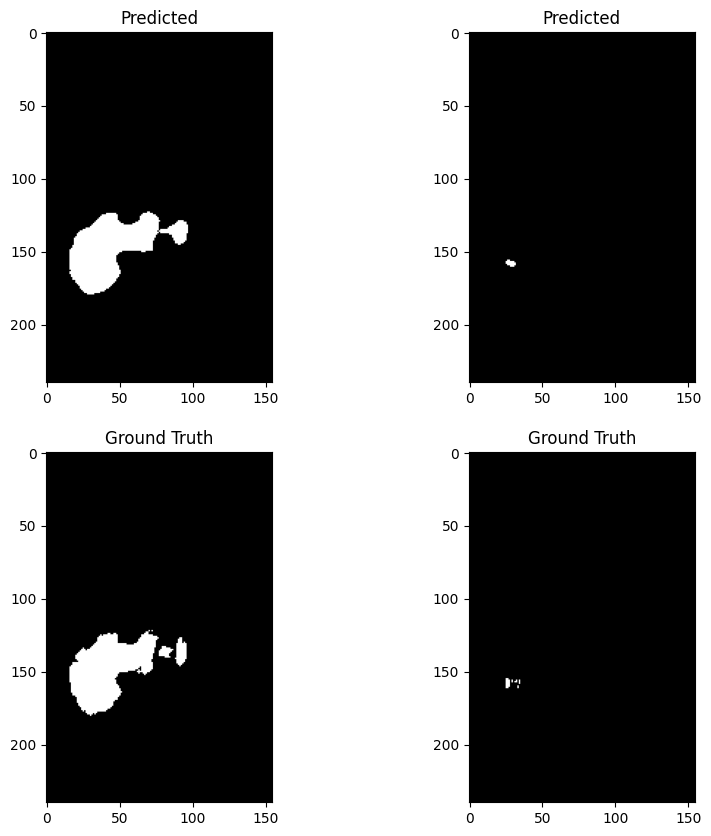

100%|██████████| 156/156 [20:12<00:00,  7.77s/it]



Average Training Loss: 0.009850302508148627

Average Training DSC: [0.99881724 0.89981779 0.92273336 0.72822855]
Average Training ASSD: [ 0.11555366  9.83452413 12.11871122 34.56268987]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


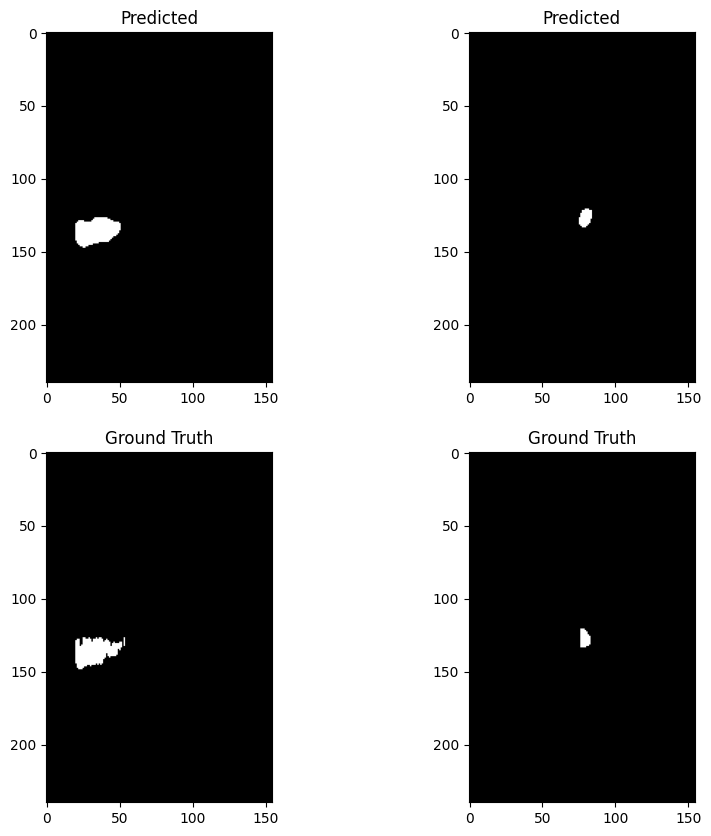

100%|██████████| 39/39 [05:04<00:00,  7.82s/it]


Average Validation Loss: 0.013515490799760208

Average Validation DSC: [0.99864457 0.86720311 0.92137852 0.72190612]
Average Validation ASSD: [ 0.13967448 14.84047697 11.9800573  18.76686755]
Epoch 44/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


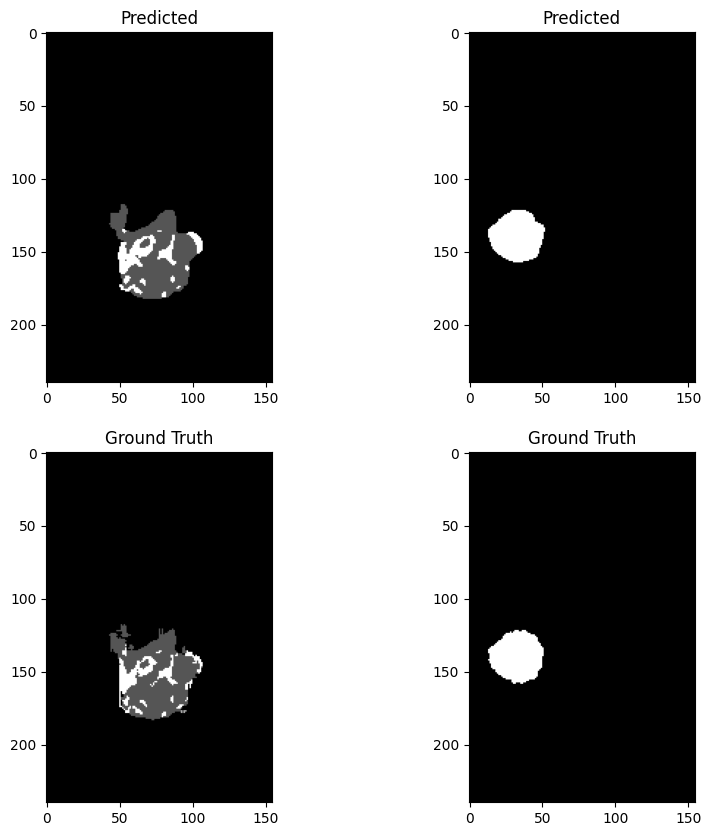

100%|██████████| 156/156 [20:54<00:00,  8.04s/it]



Average Training Loss: 0.009724115576738348

Average Training DSC: [0.99885157 0.89642131 0.92288114 0.72689373]
Average Training ASSD: [ 0.11281273 11.99593958 11.7451779  35.98434178]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


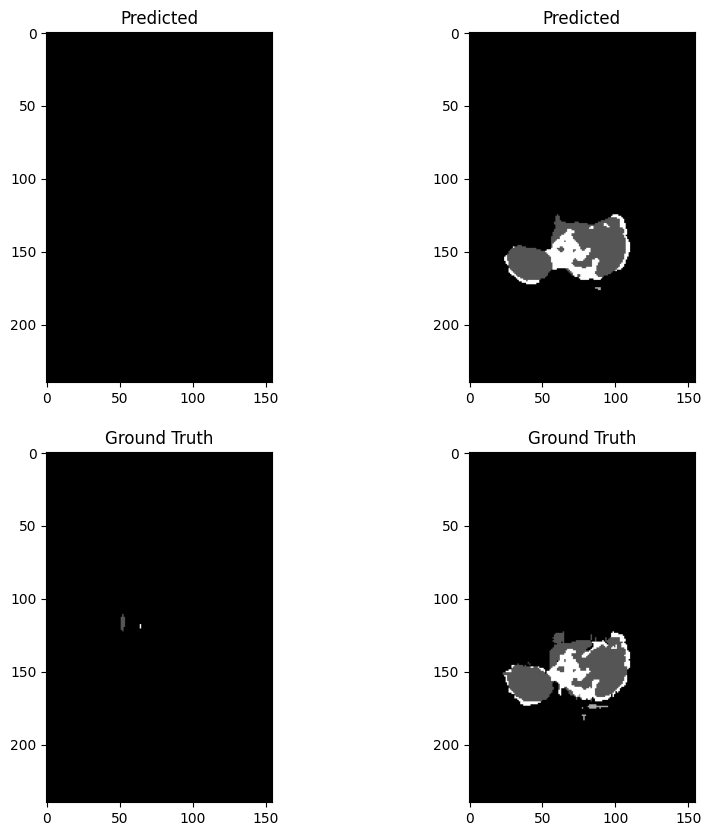

100%|██████████| 39/39 [04:56<00:00,  7.60s/it]


Average Validation Loss: 0.013273755757090373

Average Validation DSC: [0.99854495 0.86834572 0.92017675 0.70970743]
Average Validation ASSD: [ 0.16194042 15.42123056 11.96508603 29.32371383]
Epoch 45/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


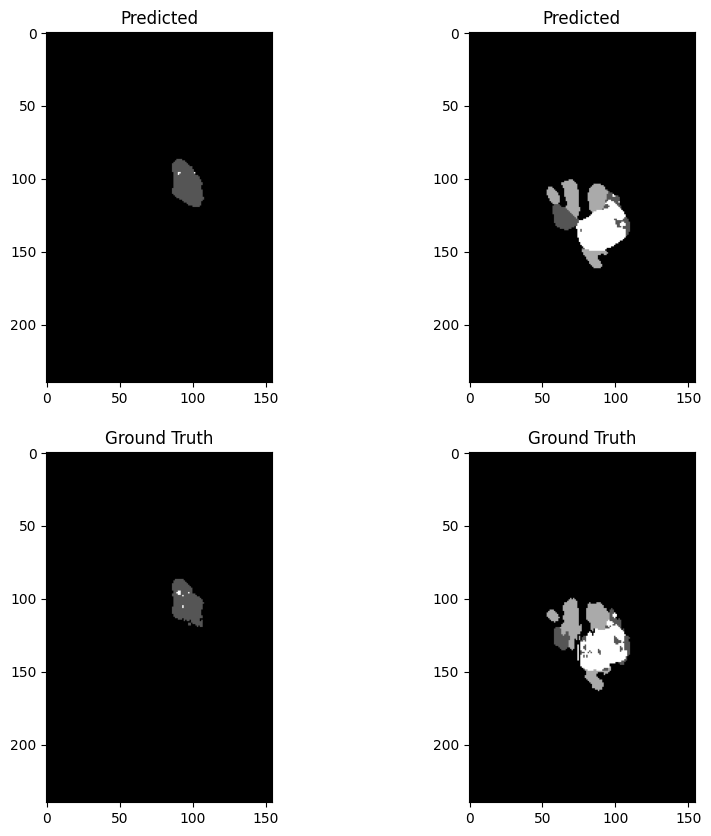

100%|██████████| 156/156 [21:10<00:00,  8.14s/it]



Average Training Loss: 0.009620654939984282

Average Training DSC: [0.99887249 0.89682925 0.92219444 0.73204797]
Average Training ASSD: [ 0.11232591 11.27579851 12.55981345 35.26521813]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


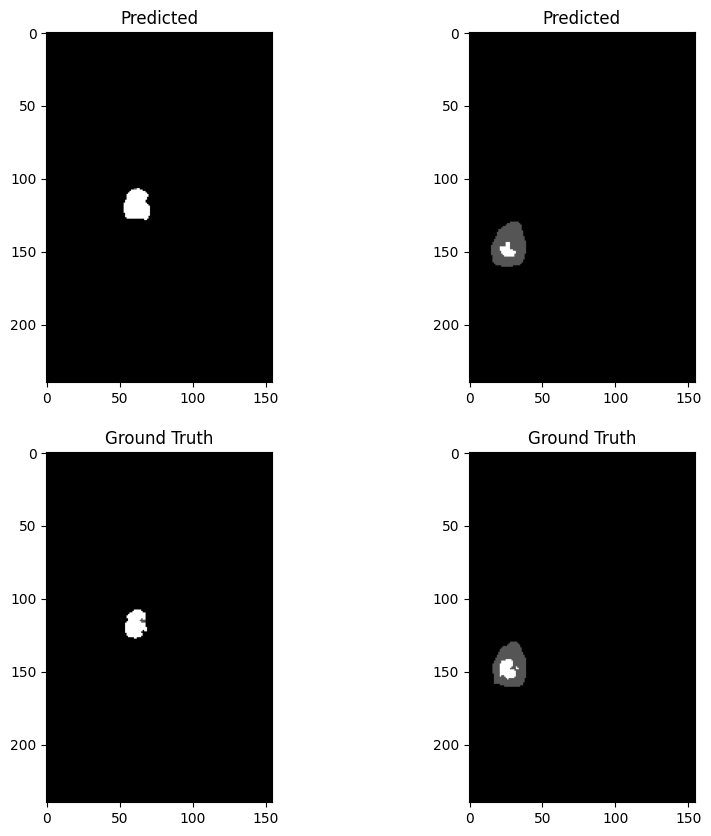

100%|██████████| 39/39 [05:00<00:00,  7.70s/it]


Average Validation Loss: 0.014255164358287286

Average Validation DSC: [0.99854448 0.79435071 0.90595928 0.66797729]
Average Validation ASSD: [ 0.14411736 43.58439605 16.34600328 36.06220022]
Epoch 46/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


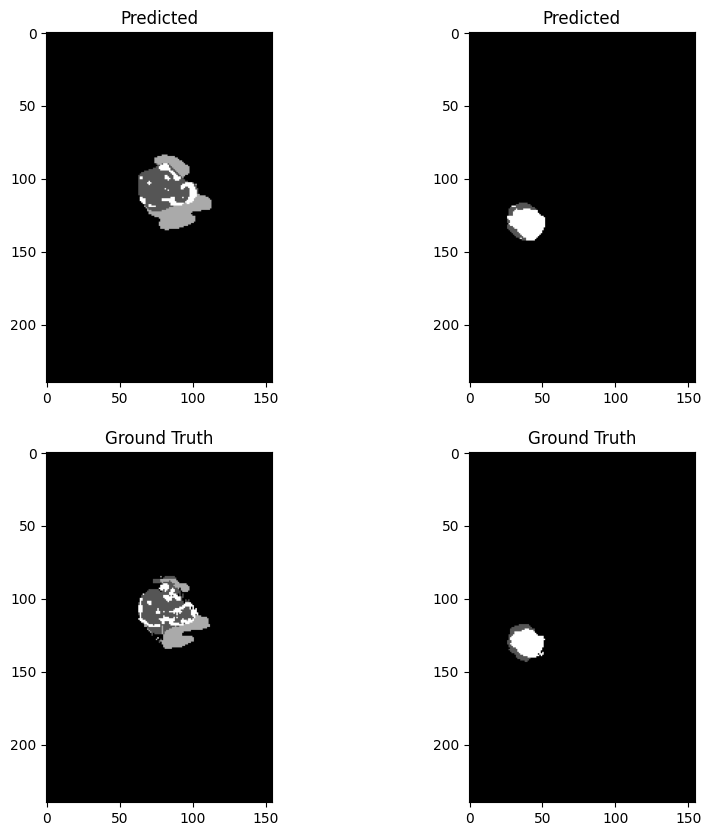

100%|██████████| 156/156 [20:28<00:00,  7.87s/it]



Average Training Loss: 0.009598072451085616

Average Training DSC: [0.99887673 0.89800139 0.92376851 0.73076247]
Average Training ASSD: [ 0.10850005 10.69686221 11.6742341  33.24713753]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


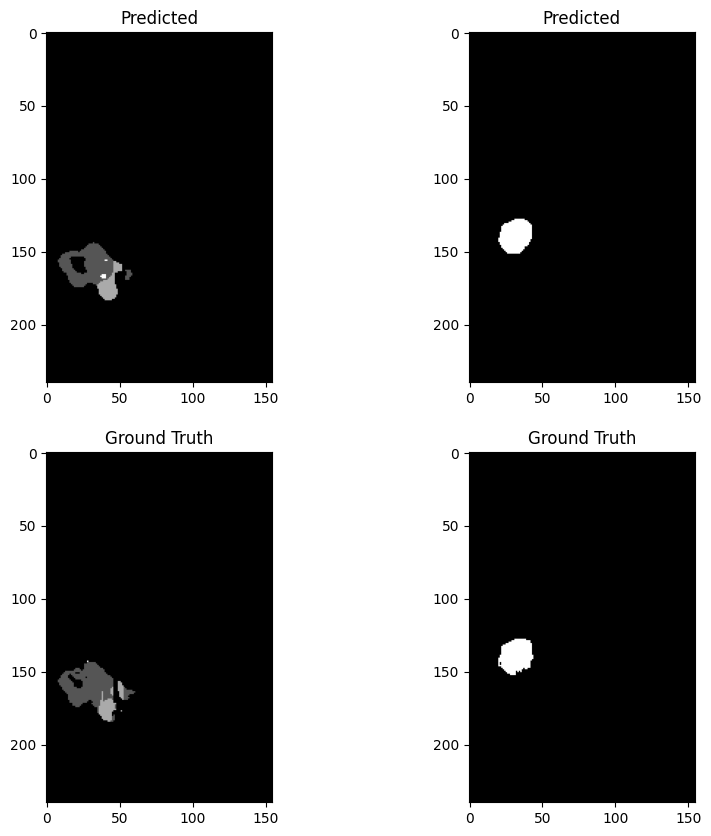

100%|██████████| 39/39 [05:11<00:00,  7.97s/it]


Average Validation Loss: 0.012319489561307888

Average Validation DSC: [0.99870054 0.8500547  0.92308175 0.72060534]
Average Validation ASSD: [ 0.12684601 26.37485561 11.07760878 27.04942182]
Epoch 47/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


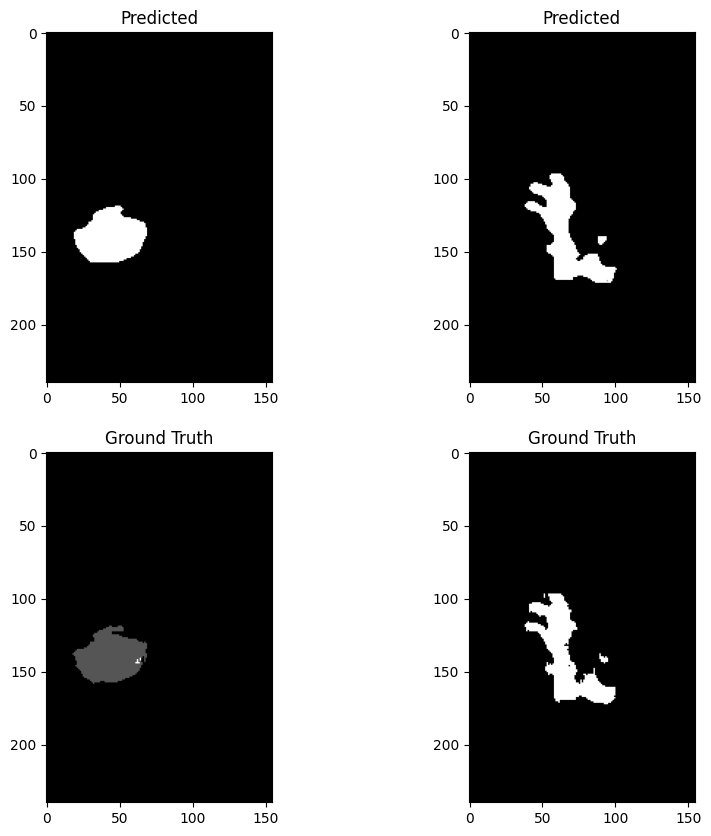

100%|██████████| 156/156 [21:16<00:00,  8.18s/it]



Average Training Loss: 0.009707413685436431

Average Training DSC: [0.99886178 0.89246743 0.92089951 0.72988179]
Average Training ASSD: [ 0.11078847 12.96958859 12.9773663  33.1079698 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


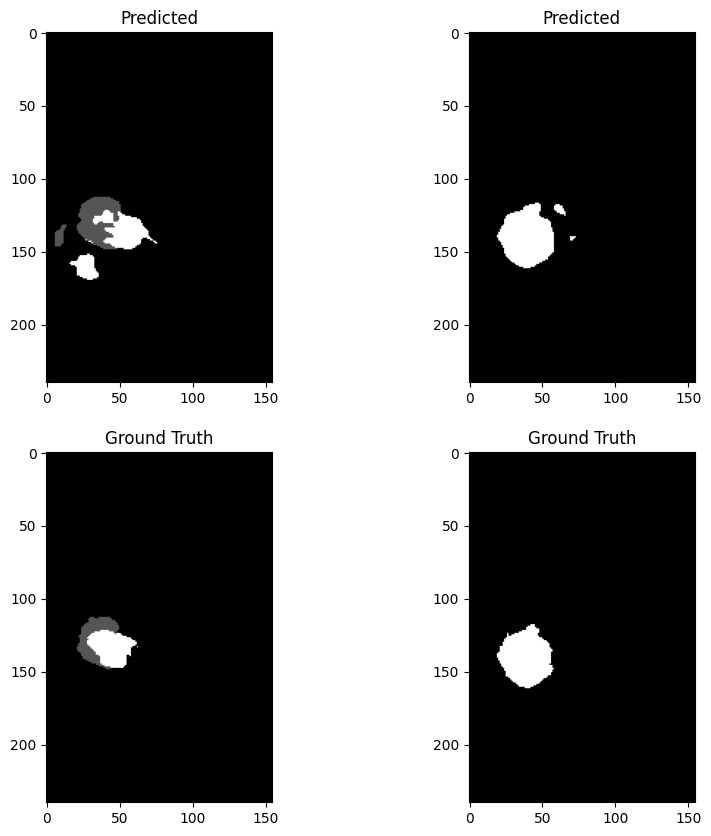

100%|██████████| 39/39 [05:12<00:00,  8.00s/it]


Average Validation Loss: 0.0188189114515598

Average Validation DSC: [0.99777673 0.76538774 0.8965036  0.6447895 ]
Average Validation ASSD: [ 0.38133106 52.22078292 19.59754    15.82662903]
Epoch 48/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


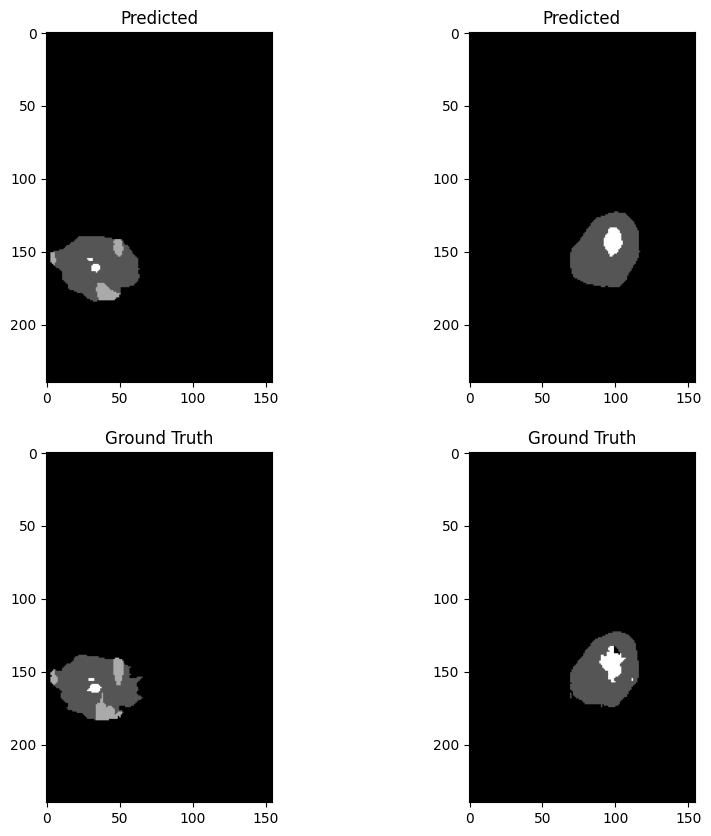

100%|██████████| 156/156 [20:57<00:00,  8.06s/it]



Average Training Loss: 0.00918507113909492

Average Training DSC: [0.99892413 0.90266144 0.92700071 0.73832153]
Average Training ASSD: [ 0.10633019 10.23160505 11.25354667 33.00890386]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


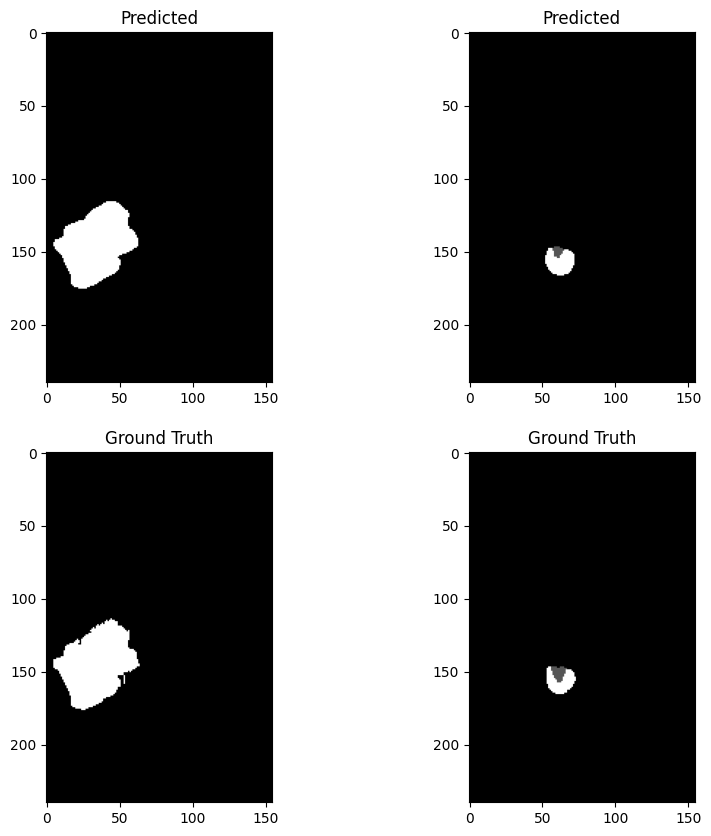

100%|██████████| 39/39 [05:10<00:00,  7.97s/it]


Average Validation Loss: 0.017759520321702346

Average Validation DSC: [0.99861482 0.78681779 0.91784274 0.66592483]
Average Validation ASSD: [ 0.14849931 22.45669    11.67761639 24.7812971 ]
Epoch 49/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


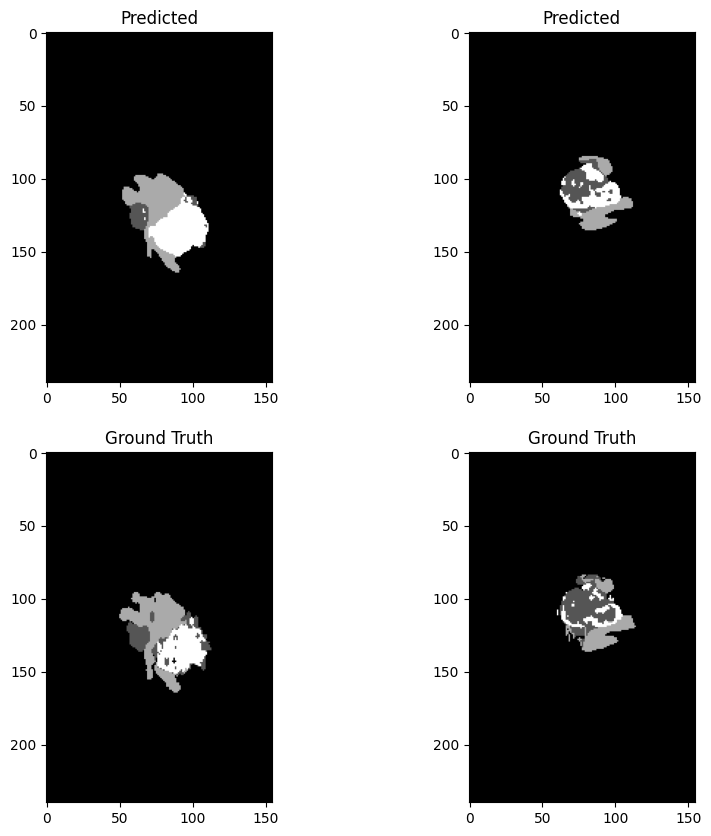

100%|██████████| 156/156 [20:36<00:00,  7.93s/it]



Average Training Loss: 0.009200832134900758

Average Training DSC: [0.99894407 0.9008409  0.92597472 0.74023508]
Average Training ASSD: [ 0.10139207 10.67289659 11.47884795 31.93448437]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


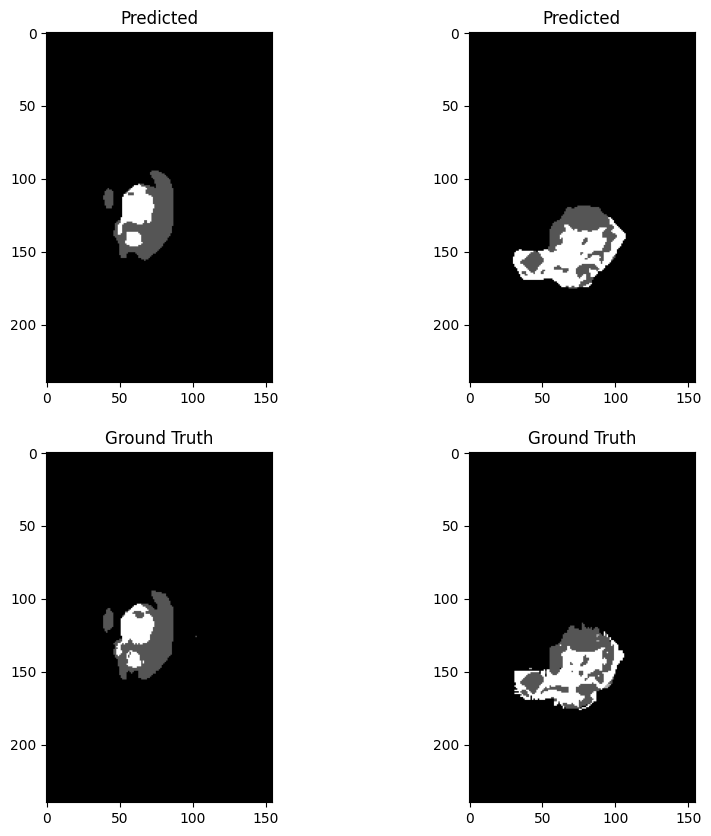

100%|██████████| 39/39 [05:05<00:00,  7.84s/it]


Average Validation Loss: 0.011713751257421115

Average Validation DSC: [0.99873149 0.87109328 0.92493779 0.72424587]
Average Validation ASSD: [ 0.13913815 18.82954848 11.91217255 30.82341295]
Epoch 50/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


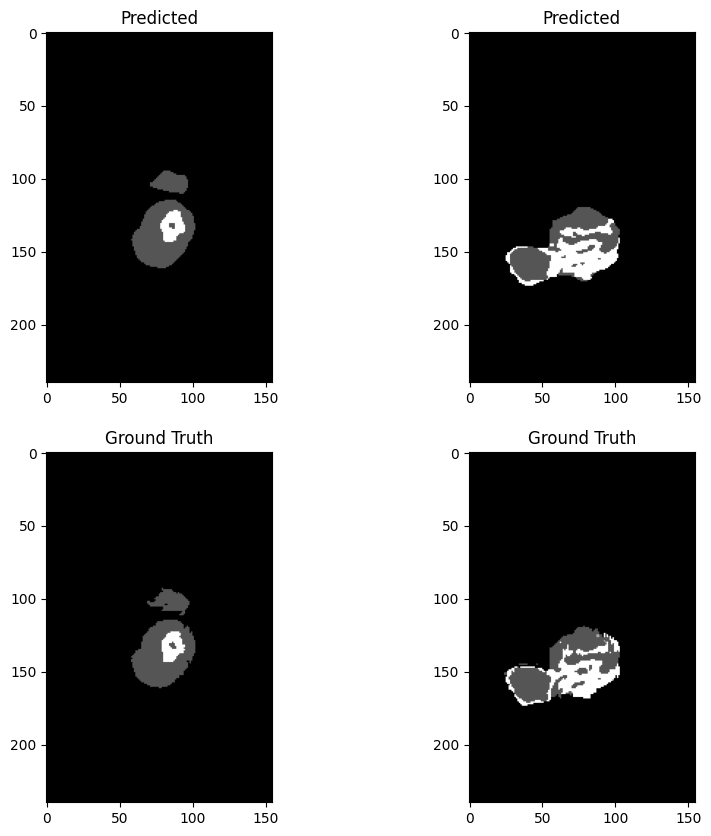

100%|██████████| 156/156 [20:24<00:00,  7.85s/it]



Average Training Loss: 0.009727675763245385

Average Training DSC: [0.99889534 0.88418474 0.92293198 0.73265998]
Average Training ASSD: [ 0.10997323 15.42199505 12.17412493 33.32934918]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


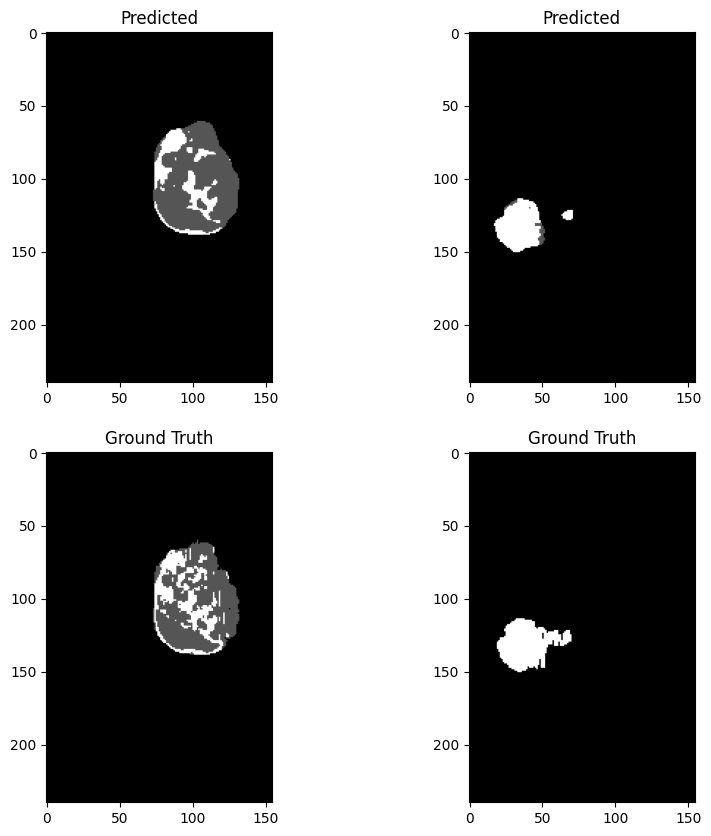

100%|██████████| 39/39 [05:18<00:00,  8.17s/it]


Average Validation Loss: 0.013340187760499807

Average Validation DSC: [0.99869046 0.86218305 0.92173207 0.68296503]
Average Validation ASSD: [ 0.14597463 20.04654207 12.22828441 35.67399955]
Epoch 51/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


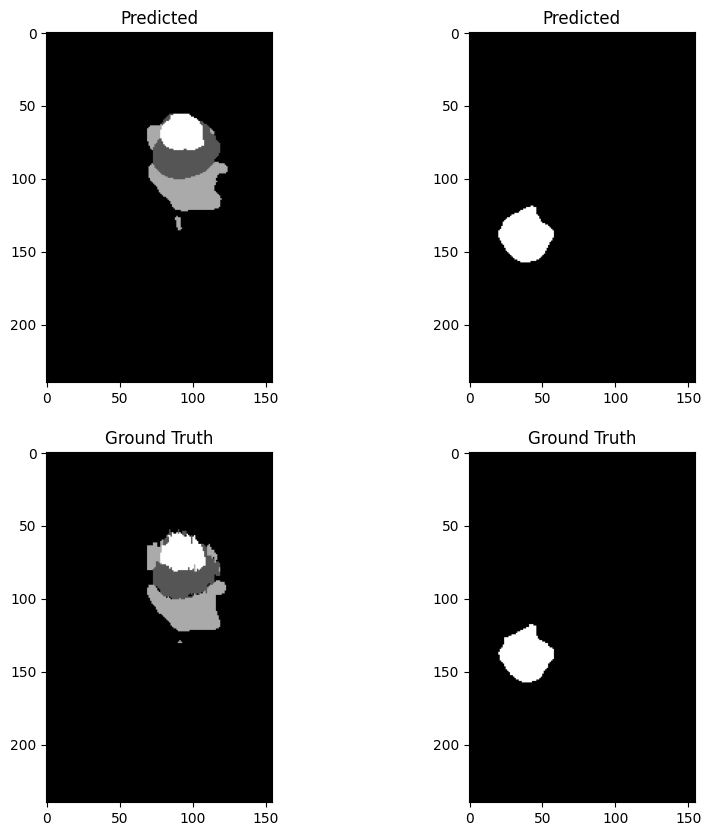

100%|██████████| 156/156 [20:20<00:00,  7.82s/it]



Average Training Loss: 0.0089660140637977

Average Training DSC: [0.99897154 0.9012158  0.92633192 0.74094536]
Average Training ASSD: [ 0.10142643 10.96330191 12.39786508 33.02544814]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


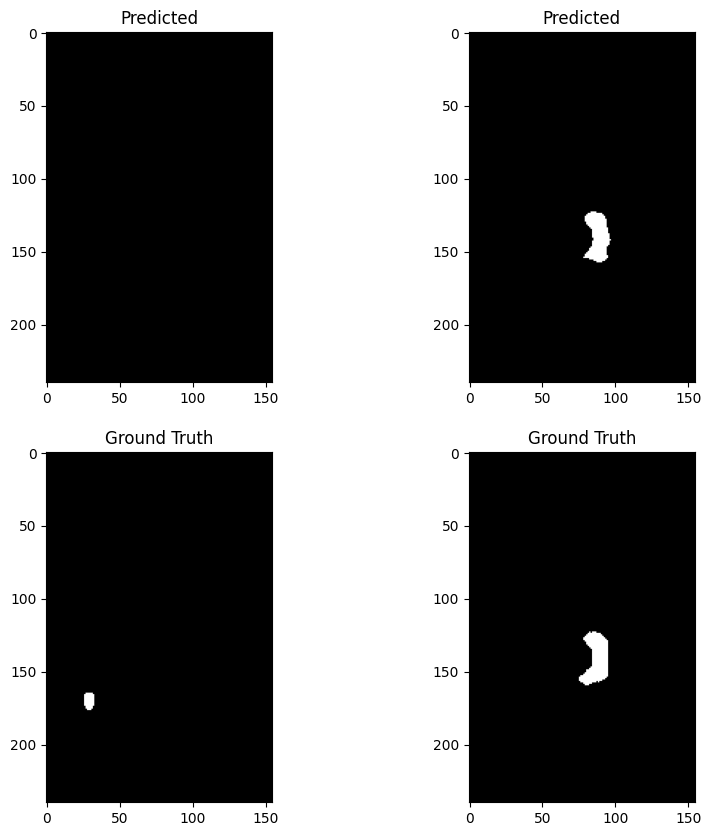

100%|██████████| 39/39 [04:51<00:00,  7.47s/it]


Average Validation Loss: 0.01272713415659009

Average Validation DSC: [0.99866781 0.85875945 0.90193361 0.71997306]
Average Validation ASSD: [ 0.1448778  23.34118248 16.75040474 27.20888315]
Epoch 52/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


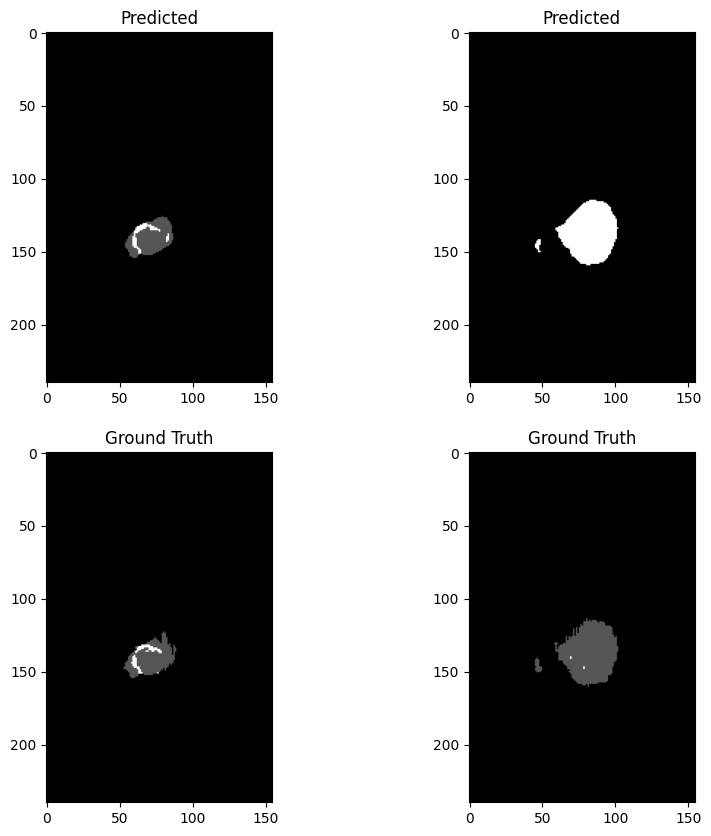

100%|██████████| 156/156 [19:53<00:00,  7.65s/it]



Average Training Loss: 0.008657373520784462

Average Training DSC: [0.99899082 0.91170389 0.92714933 0.74820025]
Average Training ASSD: [ 0.09989036  8.13494923 12.02077542 32.81132727]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


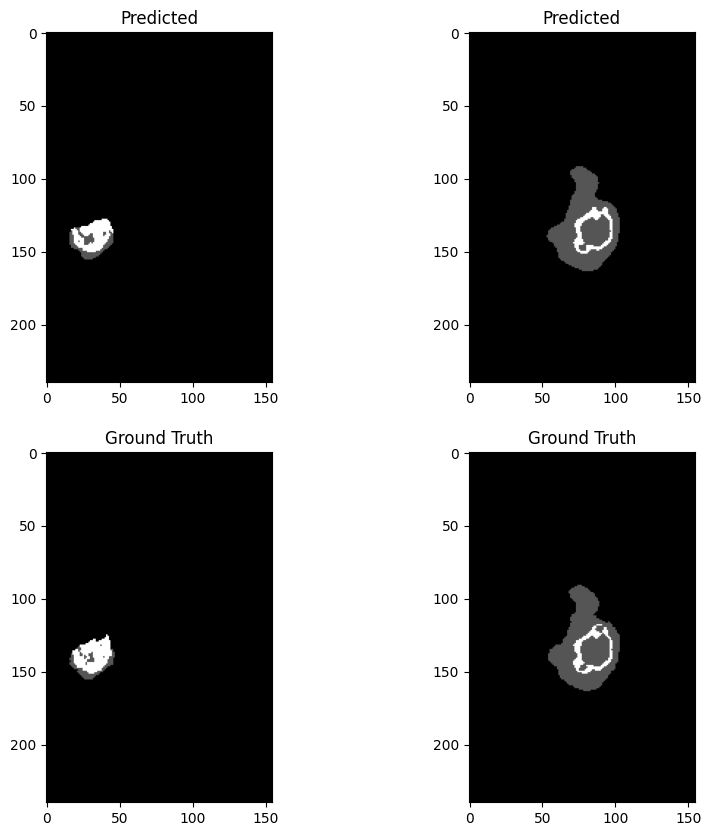

100%|██████████| 39/39 [04:59<00:00,  7.69s/it]


Average Validation Loss: 0.01101542876746792

Average Validation DSC: [0.99884931 0.89261057 0.93441176 0.74718899]
Average Validation ASSD: [ 0.1183316  14.9544457   8.71708295 24.9225671 ]
Epoch 53/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


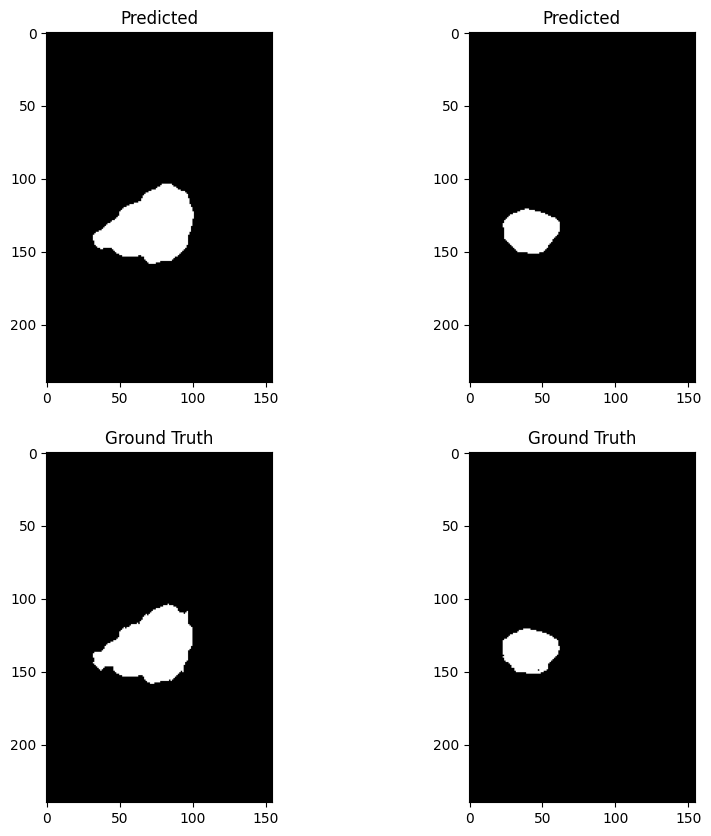

100%|██████████| 156/156 [20:45<00:00,  7.98s/it]



Average Training Loss: 0.007760126839200847

Average Training DSC: [0.99909859 0.925725   0.93832723 0.76588665]
Average Training ASSD: [ 0.0861494   4.95622855  8.78460319 31.93560659]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


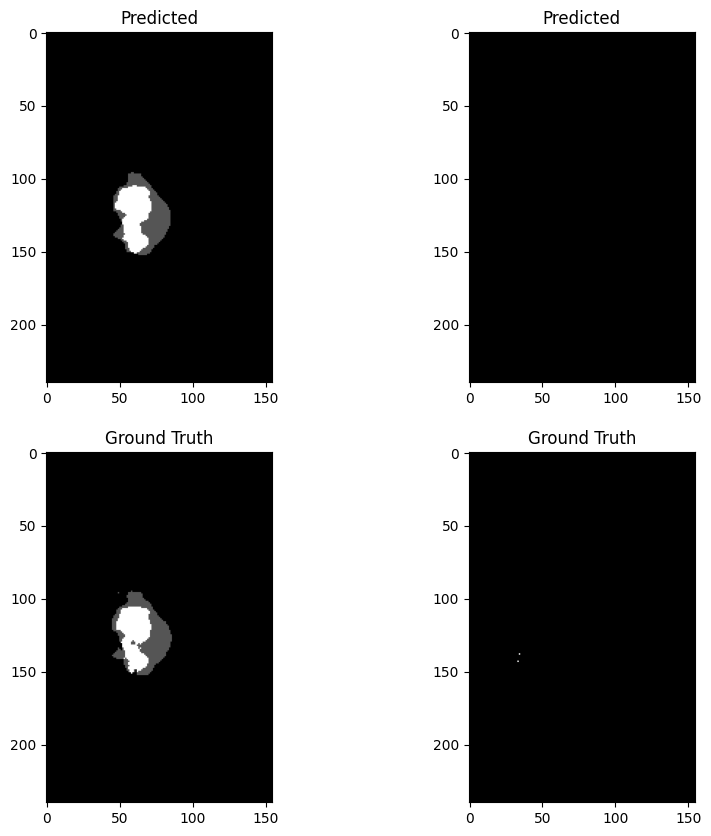

100%|██████████| 39/39 [05:07<00:00,  7.88s/it]


Average Validation Loss: 0.010927759982549991

Average Validation DSC: [0.99889051 0.88779599 0.93532102 0.74948096]
Average Validation ASSD: [ 0.12688124 16.99440438  7.8644279  28.75836235]
Epoch 54/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


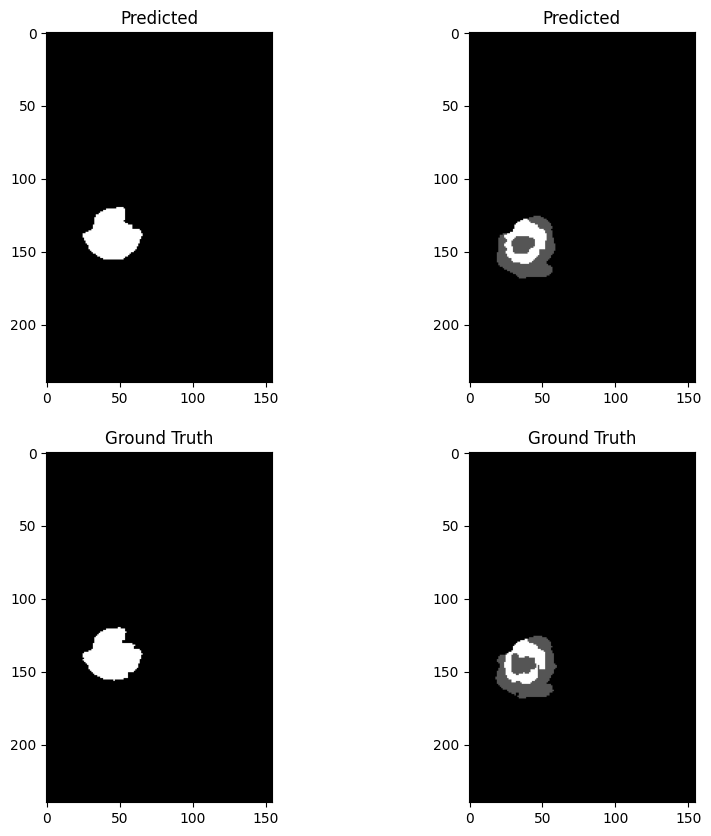

100%|██████████| 156/156 [20:23<00:00,  7.84s/it]



Average Training Loss: 0.0075758220389103275

Average Training DSC: [0.9991218  0.92696487 0.93975402 0.77160766]
Average Training ASSD: [ 0.08464457  5.08609844  8.85396822 32.46662439]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


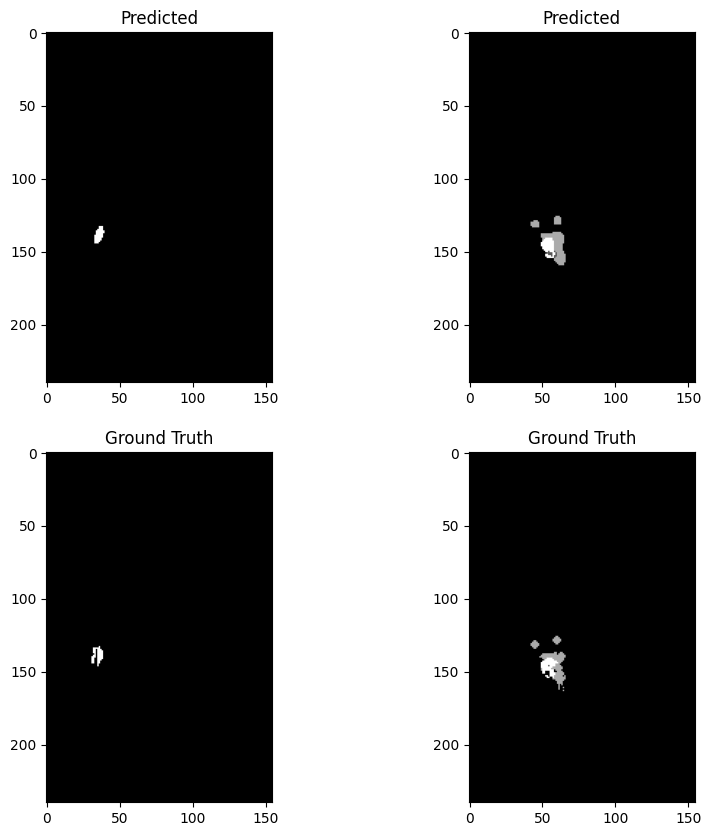

100%|██████████| 39/39 [05:16<00:00,  8.11s/it]


Average Validation Loss: 0.011009833011298608

Average Validation DSC: [0.99890916 0.89515078 0.93681223 0.7356253 ]
Average Validation ASSD: [ 0.12211493 15.20694376  8.67211698 33.31207134]
Epoch 55/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


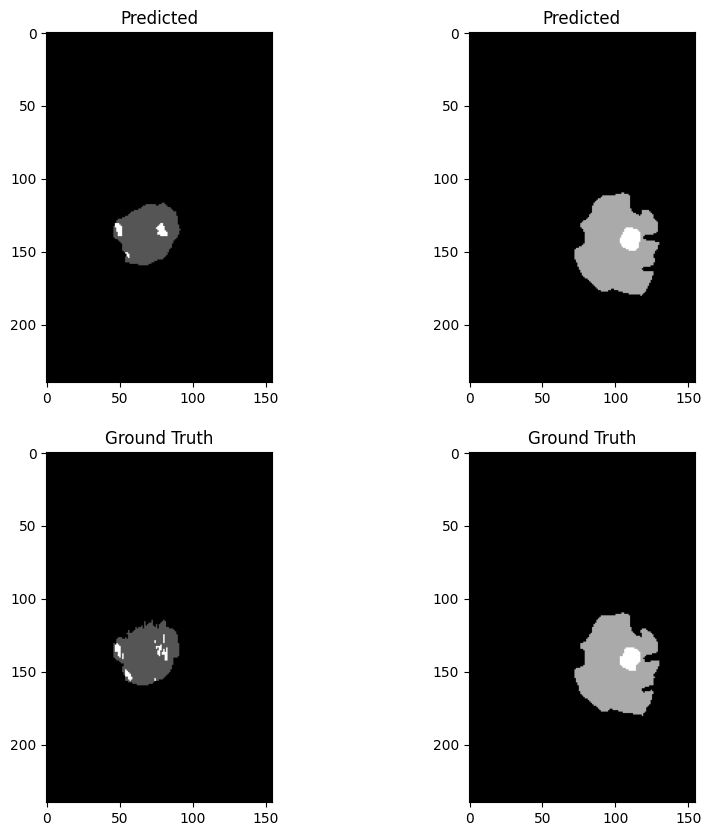

100%|██████████| 156/156 [22:19<00:00,  8.59s/it]



Average Training Loss: 0.007379248953209474

Average Training DSC: [0.99914718 0.92887018 0.93962013 0.77682293]
Average Training ASSD: [ 0.08196984  5.14068986  8.78071122 31.65248223]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


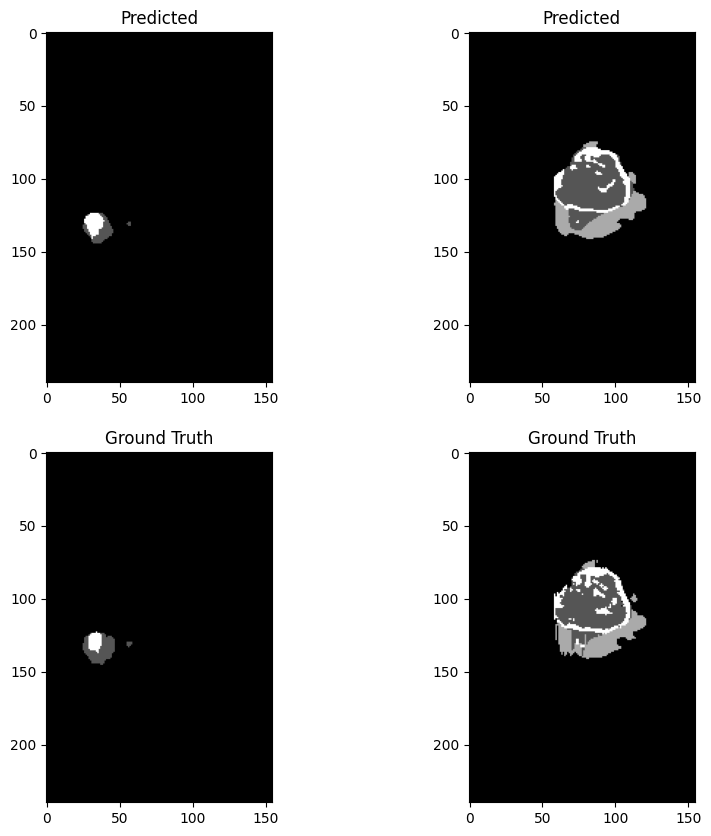

100%|██████████| 39/39 [04:56<00:00,  7.60s/it]


Average Validation Loss: 0.010771339126408864

Average Validation DSC: [0.99892996 0.8984028  0.93899325 0.74426084]
Average Validation ASSD: [ 0.10673977 14.90040536  8.1277463  26.27246038]
Epoch 56/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


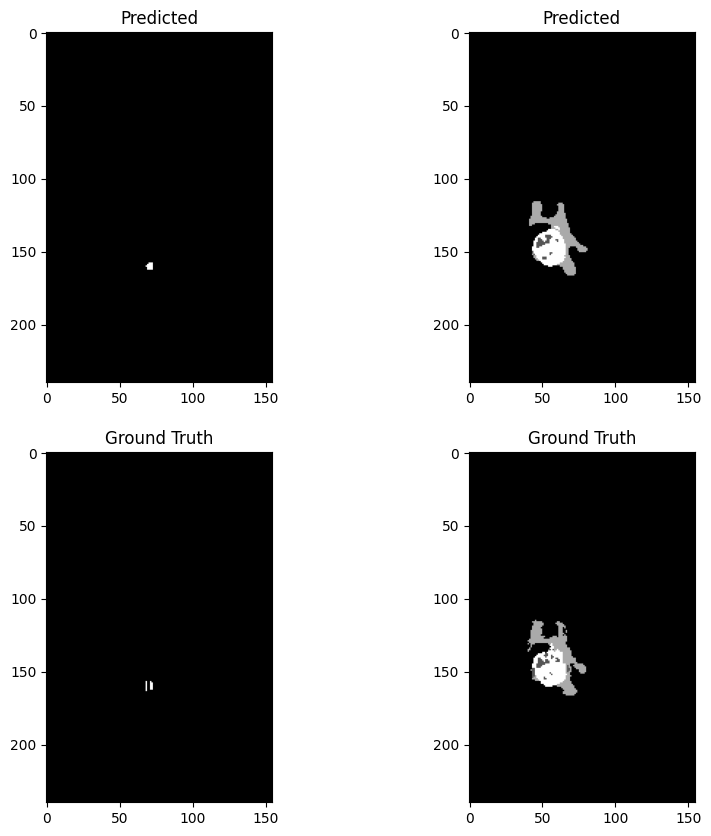

100%|██████████| 156/156 [20:45<00:00,  7.99s/it]



Average Training Loss: 0.007428905177407731

Average Training DSC: [0.99915725 0.92761244 0.93870308 0.77364654]
Average Training ASSD: [ 0.07964505  4.86428331  9.28511699 30.59733715]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


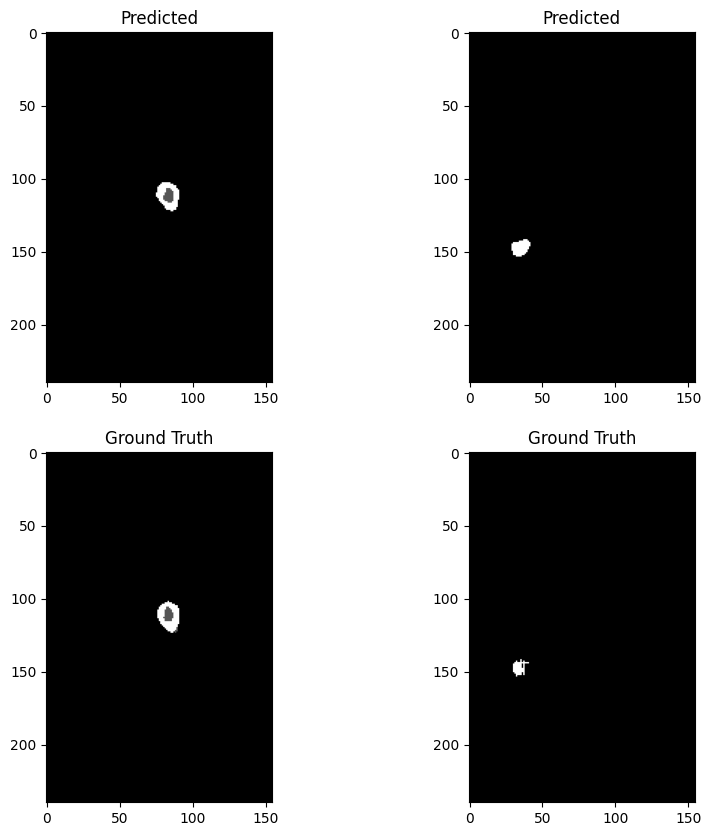

100%|██████████| 39/39 [04:54<00:00,  7.55s/it]


Average Validation Loss: 0.010624155915604953

Average Validation DSC: [0.99894612 0.88867267 0.93281861 0.74990161]
Average Validation ASSD: [ 0.10815107 17.9697029   9.04023631 26.51931799]
Epoch 57/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


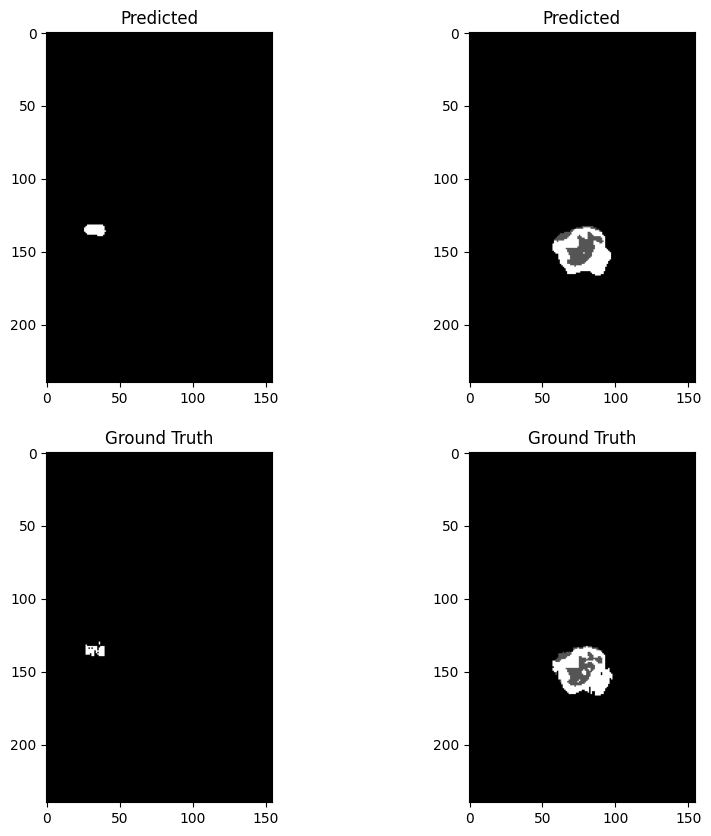

100%|██████████| 156/156 [20:41<00:00,  7.96s/it]



Average Training Loss: 0.007271015407660833

Average Training DSC: [0.99916347 0.93072427 0.93895633 0.77901244]
Average Training ASSD: [ 0.07858085  4.5655013   8.92913407 30.61660889]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


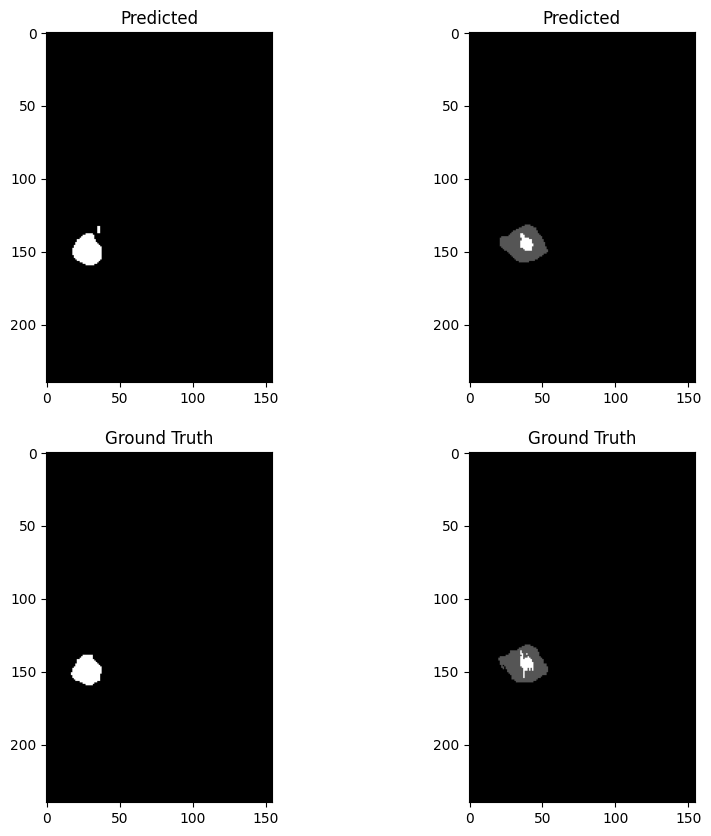

100%|██████████| 39/39 [04:59<00:00,  7.69s/it]


Average Validation Loss: 0.010750729113053054

Average Validation DSC: [0.9988796  0.89482626 0.93478367 0.75725914]
Average Validation ASSD: [ 0.11647834 13.18909805  9.57791869 25.34875448]
Epoch 58/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


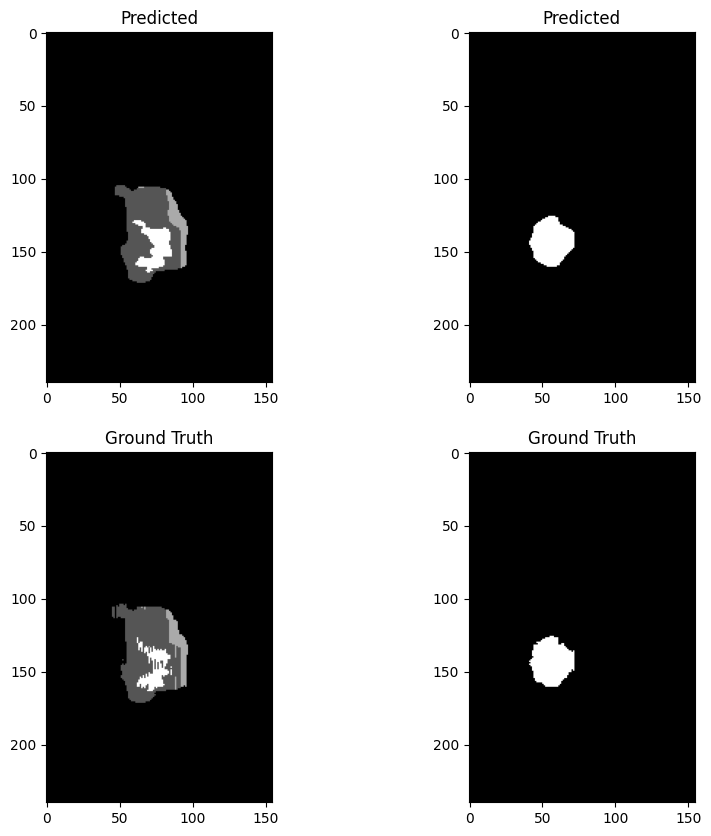

100%|██████████| 156/156 [20:14<00:00,  7.79s/it]



Average Training Loss: 0.007217937274477803

Average Training DSC: [0.99917374 0.93073555 0.94144553 0.77900365]
Average Training ASSD: [ 0.07822924  4.60830177  8.20571335 30.57125029]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


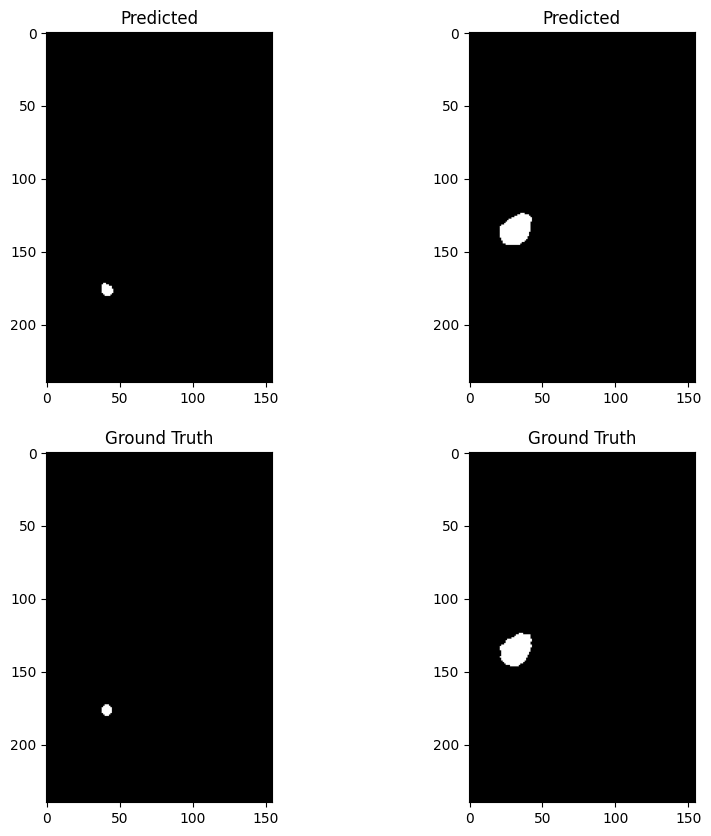

100%|██████████| 39/39 [05:07<00:00,  7.88s/it]


Average Validation Loss: 0.010548073667077681

Average Validation DSC: [0.99894656 0.88970479 0.9322979  0.75968091]
Average Validation ASSD: [ 0.10815753 16.70129064  9.5186611  22.77052496]
Epoch 59/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


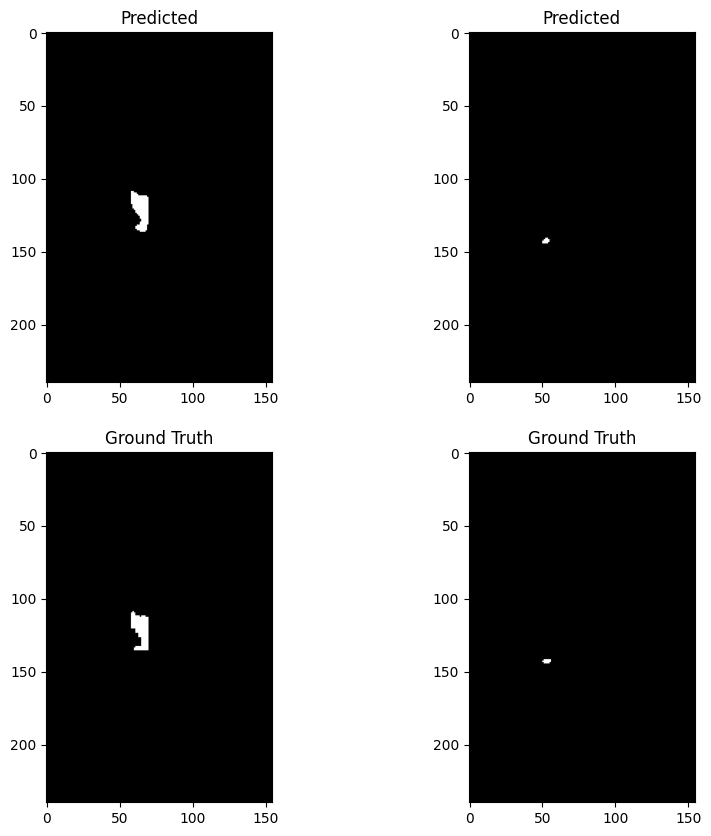

100%|██████████| 156/156 [20:55<00:00,  8.05s/it]



Average Training Loss: 0.00803696060887514

Average Training DSC: [0.99909264 0.90551528 0.92939011 0.76346352]
Average Training ASSD: [ 0.0874317  11.56823204 11.53981139 28.31143059]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


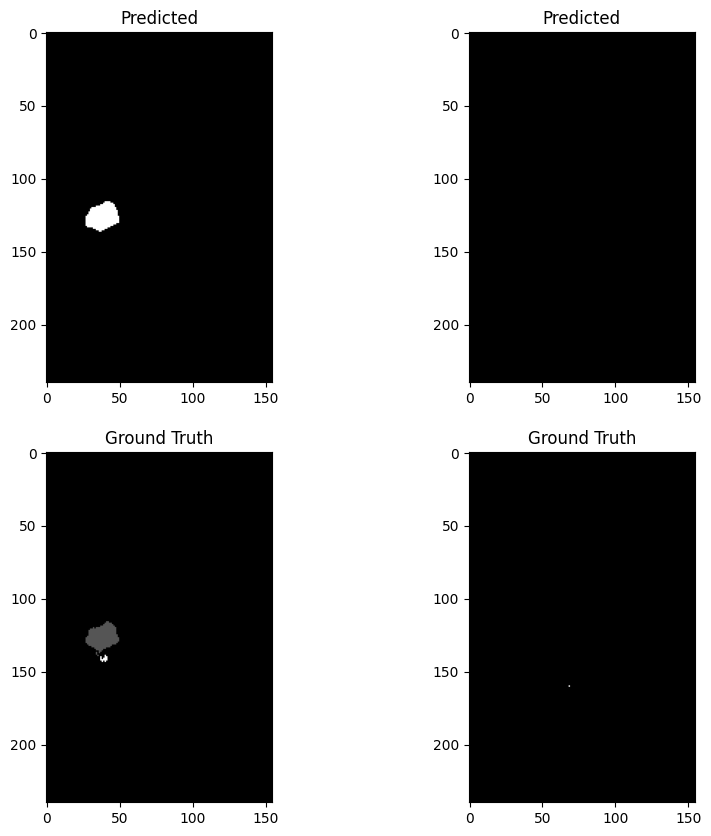

100%|██████████| 39/39 [04:41<00:00,  7.23s/it]


Average Validation Loss: 0.010884428169960395

Average Validation DSC: [0.99892228 0.88436974 0.93575568 0.74642526]
Average Validation ASSD: [ 0.11702848 17.63489683  8.4457088  27.92156556]
Epoch 60/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


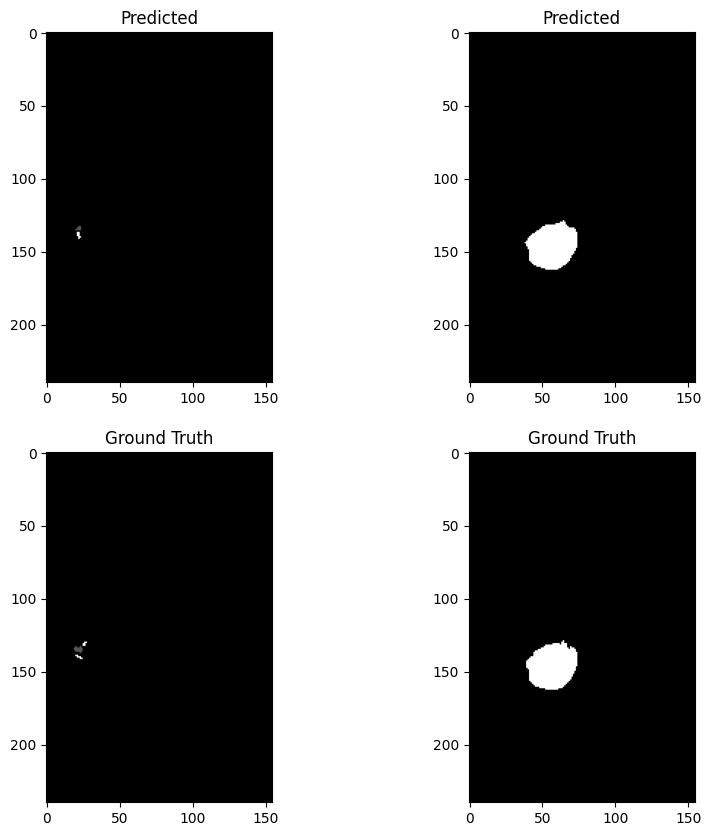

100%|██████████| 156/156 [20:58<00:00,  8.07s/it]



Average Training Loss: 0.00793005975608069

Average Training DSC: [0.99908304 0.90768305 0.93202127 0.76624976]
Average Training ASSD: [ 0.08873096 11.24042004 10.55761338 29.19788711]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


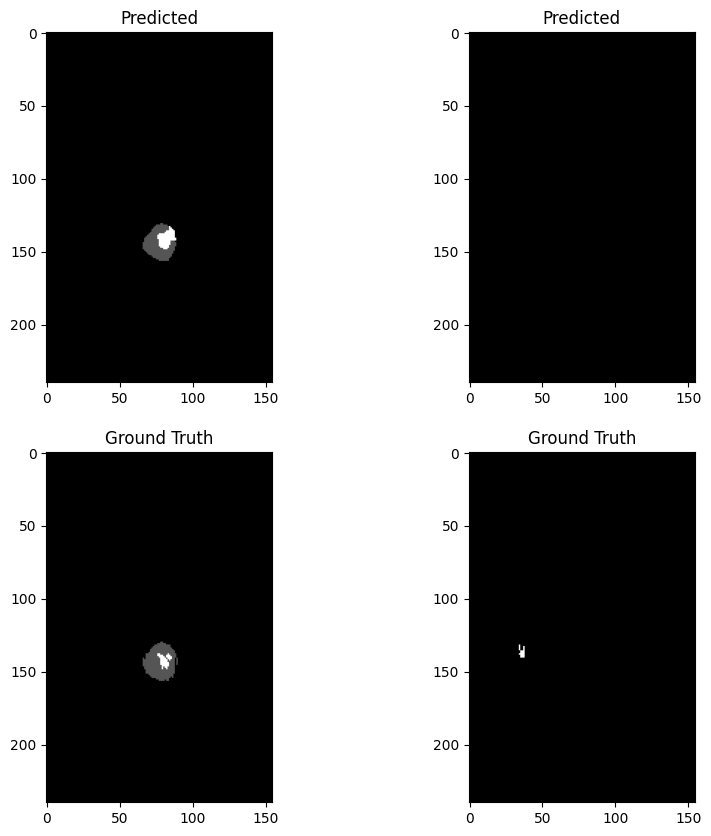

100%|██████████| 39/39 [05:22<00:00,  8.26s/it]


Average Validation Loss: 0.015113718401736174

Average Validation DSC: [0.99861395 0.84763251 0.91608797 0.71684742]
Average Validation ASSD: [ 0.14832449 17.76353823 12.84422935 22.58251119]
Epoch 61/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


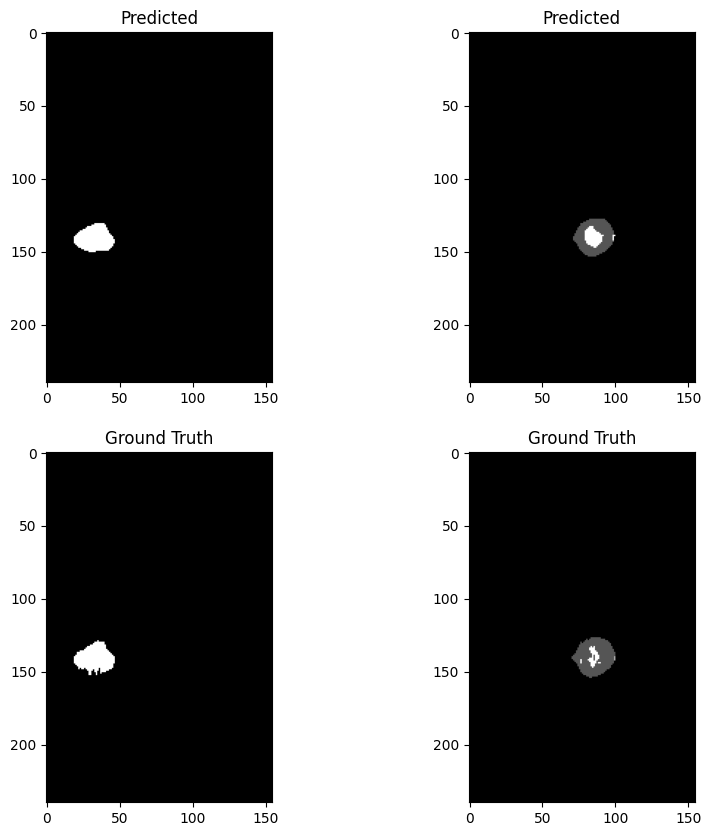

100%|██████████| 156/156 [20:47<00:00,  7.99s/it]



Average Training Loss: 0.00949123626252493

Average Training DSC: [0.99894653 0.87467363 0.91459794 0.73952878]
Average Training ASSD: [ 0.10658863 19.39410215 15.17431039 31.34124684]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


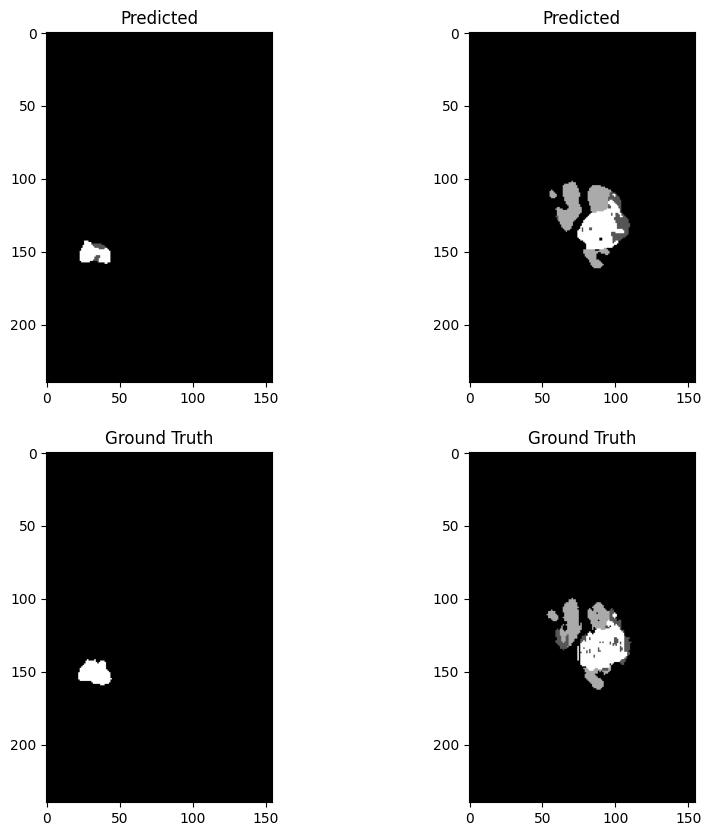

100%|██████████| 39/39 [04:46<00:00,  7.35s/it]


Average Validation Loss: 0.01339536658130013

Average Validation DSC: [0.99867784 0.85966601 0.91186659 0.71954928]
Average Validation ASSD: [ 0.1444351  21.69966119 14.38531964 25.43785843]
Epoch 62/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


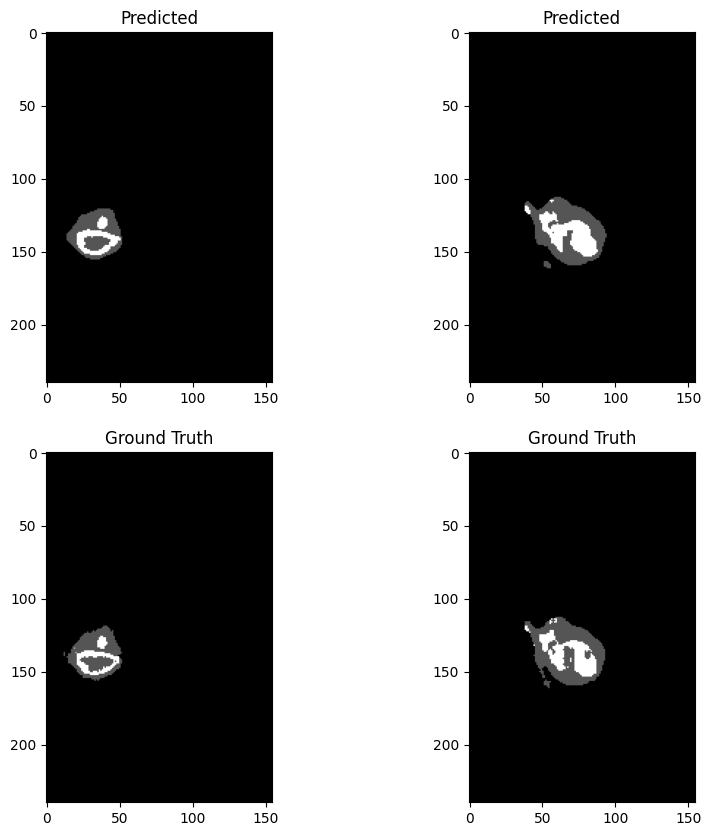

100%|██████████| 156/156 [20:19<00:00,  7.81s/it]



Average Training Loss: 0.009713186010813866

Average Training DSC: [0.99894925 0.88552139 0.90790847 0.73567072]
Average Training ASSD: [ 0.10717    15.61215307 16.73879437 31.7626241 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


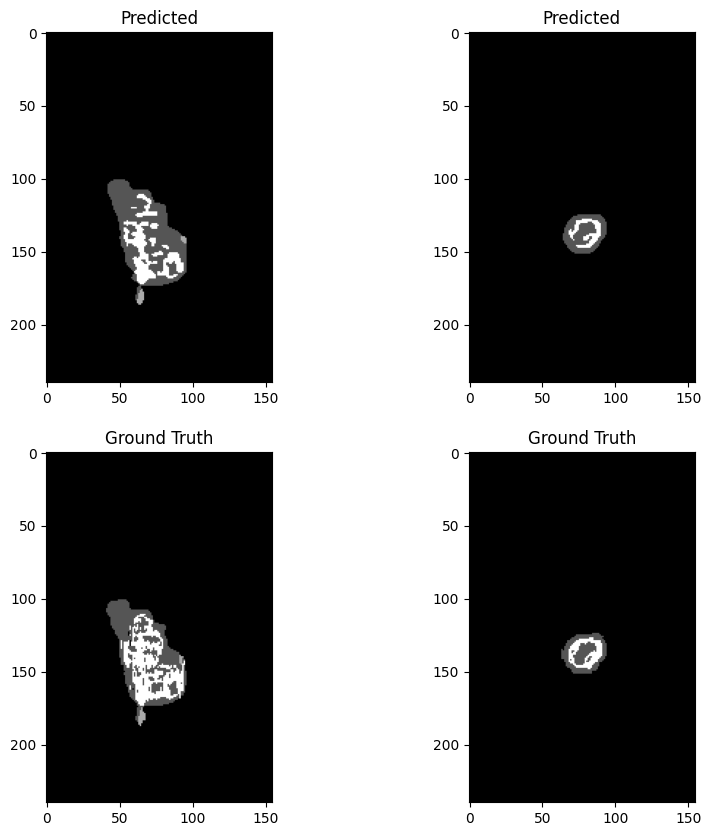

100%|██████████| 39/39 [05:07<00:00,  7.88s/it]


Average Validation Loss: 0.01490130597868791

Average Validation DSC: [0.99856336 0.67979079 0.81253034 0.65715397]
Average Validation ASSD: [ 0.16964833 85.21110743 48.59752554 35.87590298]
Epoch 63/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


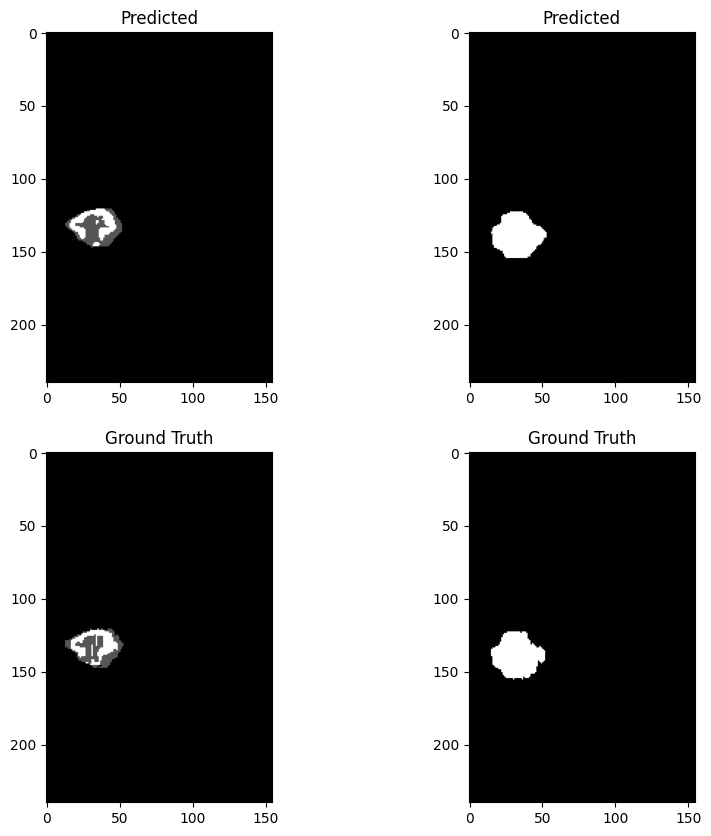

100%|██████████| 156/156 [20:14<00:00,  7.79s/it]



Average Training Loss: 0.008939339842002552

Average Training DSC: [0.99900855 0.89973478 0.91977189 0.75219895]
Average Training ASSD: [ 0.09978736 12.70416019 14.23337958 29.48727653]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


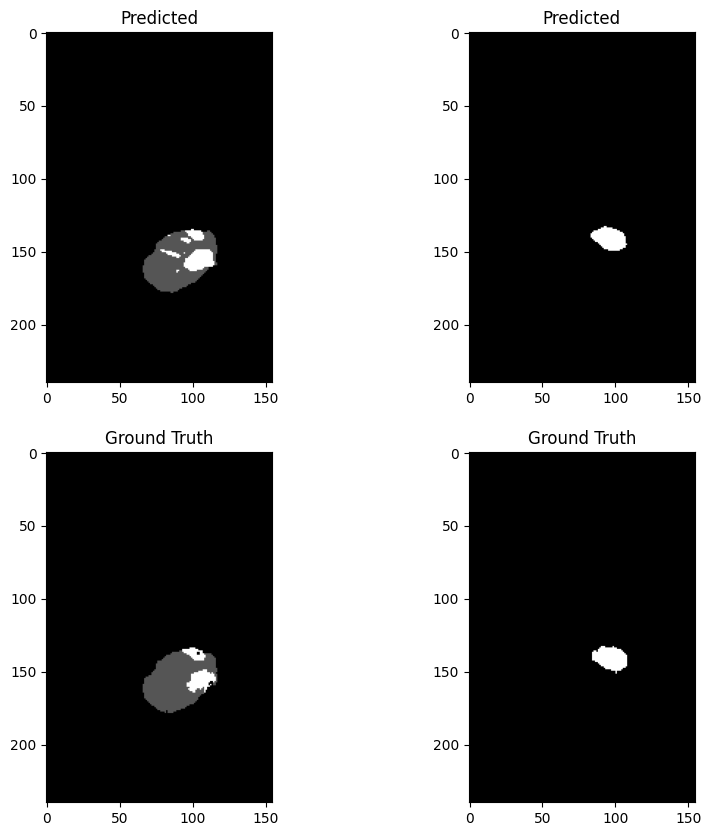

100%|██████████| 39/39 [05:00<00:00,  7.71s/it]


Average Validation Loss: 0.011564829947952276

Average Validation DSC: [0.99885249 0.84975055 0.91966015 0.74633658]
Average Validation ASSD: [ 0.12526293 28.13685803 14.78867628 23.44383698]
Epoch 64/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


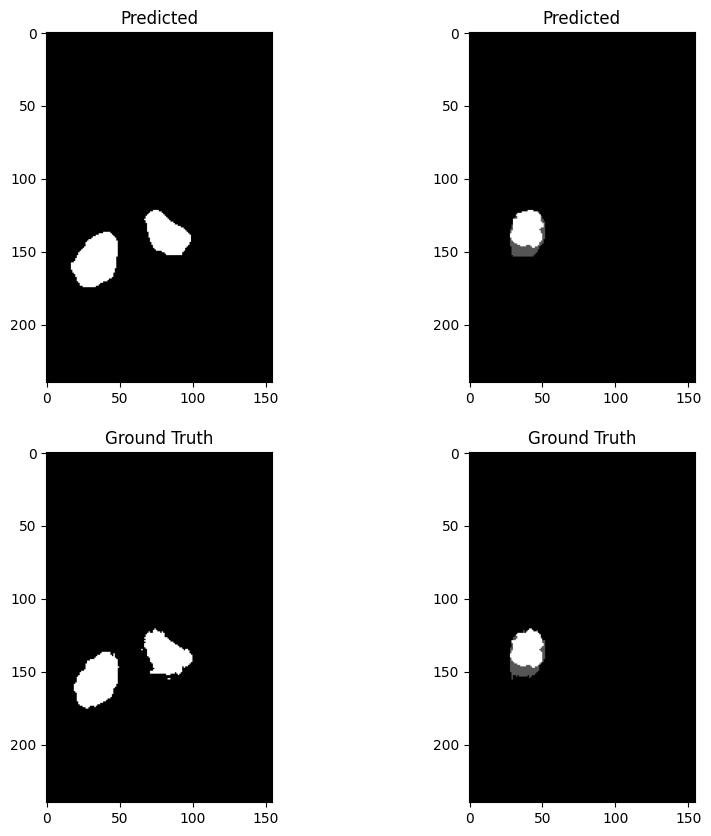

100%|██████████| 156/156 [20:29<00:00,  7.88s/it]



Average Training Loss: 0.007539910883702434

Average Training DSC: [0.99915078 0.91814313 0.93636671 0.77300187]
Average Training ASSD: [ 0.0820239   8.63841353  9.72364976 30.15296145]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


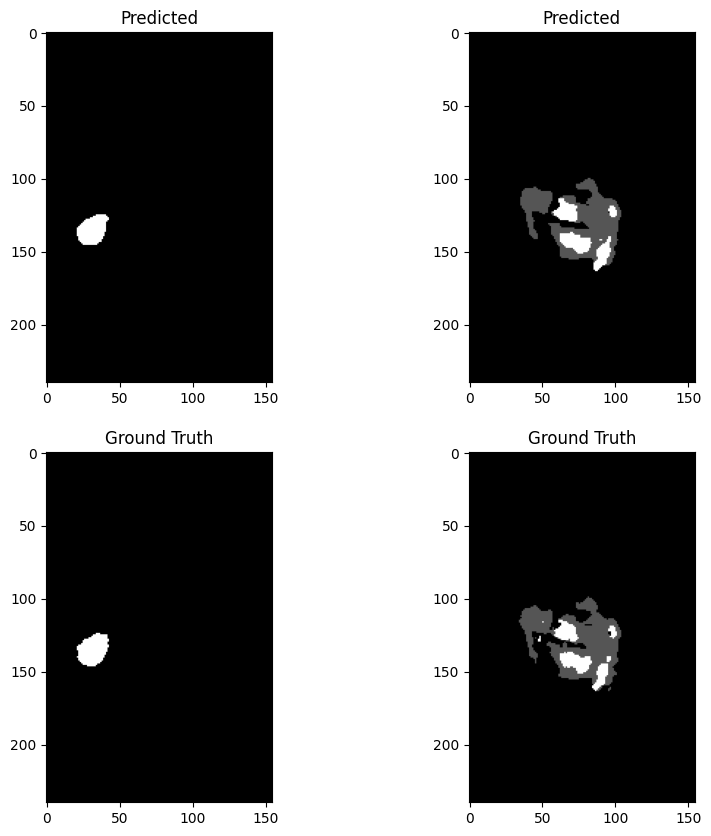

100%|██████████| 39/39 [04:49<00:00,  7.42s/it]


Average Validation Loss: 0.009996313124130934

Average Validation DSC: [0.99898706 0.89903118 0.9408321  0.76616745]
Average Validation ASSD: [ 0.10848397 14.02269166  7.21797603 26.23412154]
Epoch 65/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


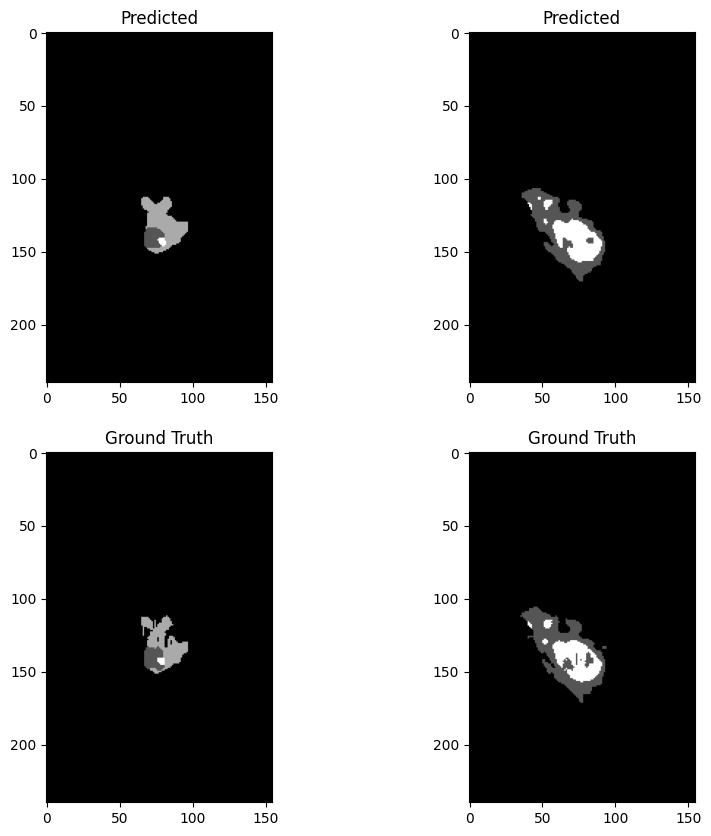

100%|██████████| 156/156 [20:44<00:00,  7.98s/it]



Average Training Loss: 0.006549142720476271

Average Training DSC: [0.99926092 0.93457547 0.94462813 0.79268902]
Average Training ASSD: [ 0.07099668  5.31827329  8.23088463 29.51957254]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


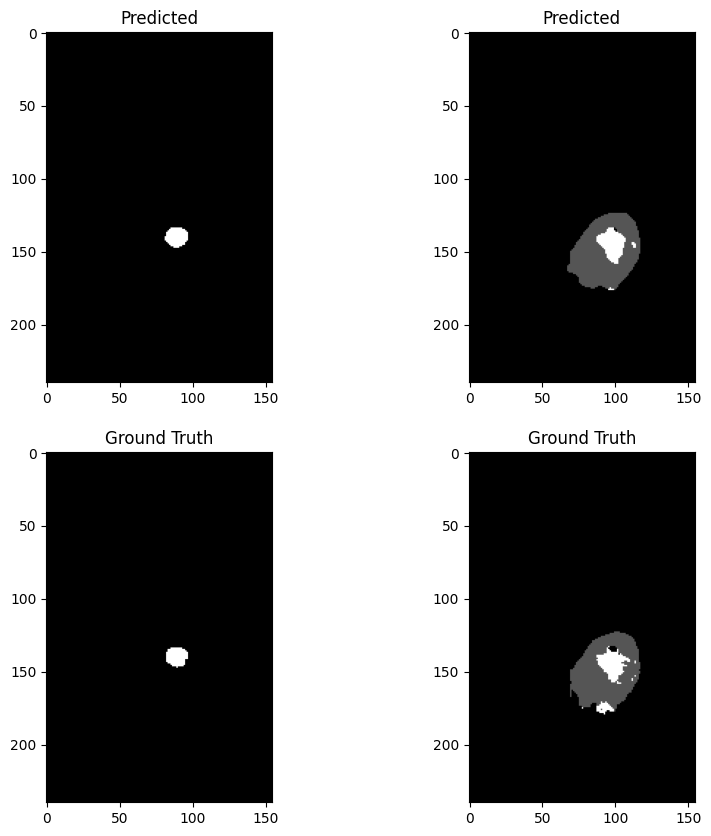

100%|██████████| 39/39 [04:48<00:00,  7.39s/it]


Average Validation Loss: 0.00974198593161045

Average Validation DSC: [0.99903649 0.90370933 0.94327413 0.77847312]
Average Validation ASSD: [ 0.1035751  13.99704595  6.92172135 24.89357894]
Epoch 66/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


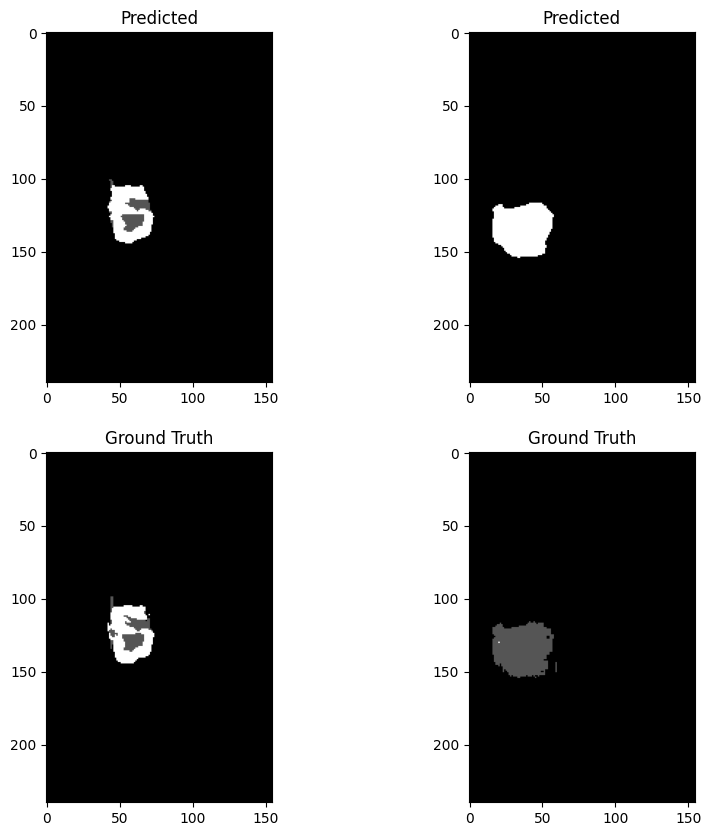

100%|██████████| 156/156 [20:46<00:00,  7.99s/it]



Average Training Loss: 0.006481014063748985

Average Training DSC: [0.99927337 0.93849398 0.94518106 0.79811545]
Average Training ASSD: [ 0.06848154  4.29505657  7.78536192 28.24410712]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


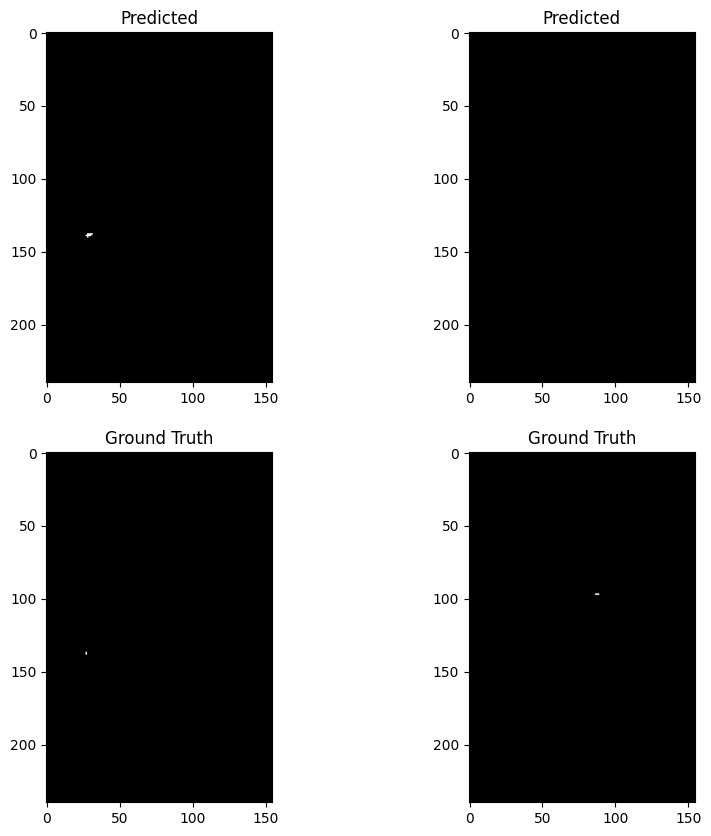

100%|██████████| 39/39 [05:14<00:00,  8.06s/it]


Average Validation Loss: 0.01021417359320017

Average Validation DSC: [0.9989107  0.86943102 0.93500733 0.76543344]
Average Validation ASSD: [ 0.11184619 24.57072188  9.6495232  20.4680888 ]
Epoch 67/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


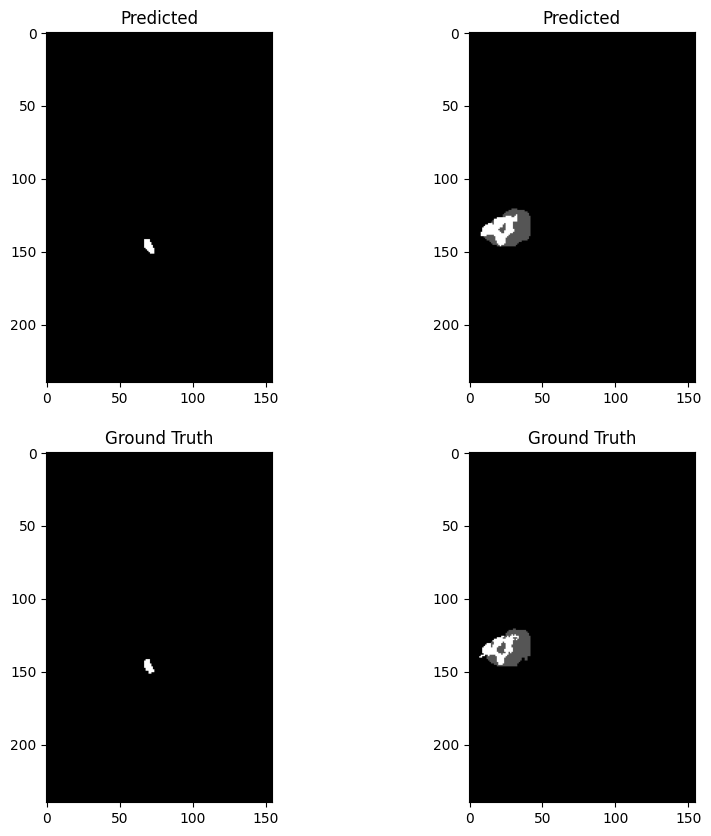

100%|██████████| 156/156 [20:48<00:00,  8.00s/it]



Average Training Loss: 0.006369602338124353

Average Training DSC: [0.99928305 0.93805247 0.94489375 0.79784026]
Average Training ASSD: [ 0.06689454  4.29630021  8.18102766 28.41133163]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


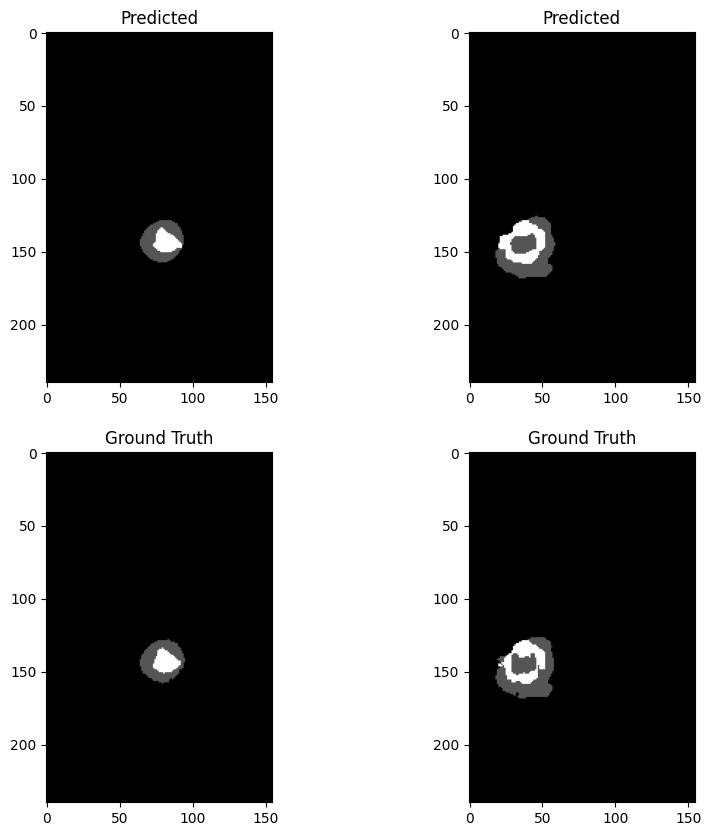

100%|██████████| 39/39 [05:21<00:00,  8.25s/it]


Average Validation Loss: 0.009435489248388853

Average Validation DSC: [0.99907235 0.90371293 0.94150669 0.78539642]
Average Validation ASSD: [ 0.09787456 14.32316926  7.76681731 22.87038439]
Epoch 68/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


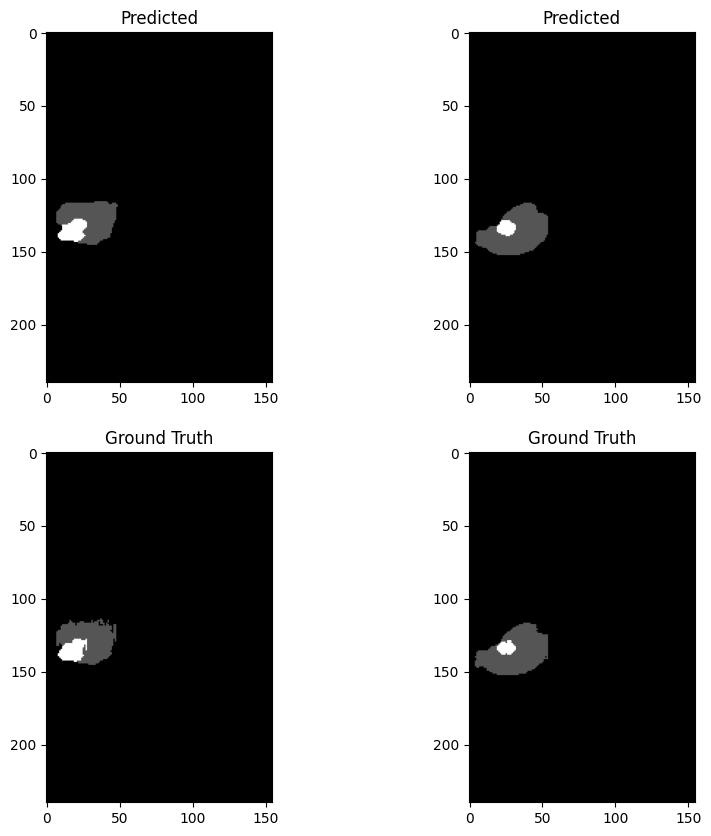

100%|██████████| 156/156 [20:04<00:00,  7.72s/it]



Average Training Loss: 0.00616819366442565

Average Training DSC: [0.99931328 0.94127629 0.94812447 0.80202362]
Average Training ASSD: [ 0.06522027  3.72728683  7.14752334 27.75300323]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


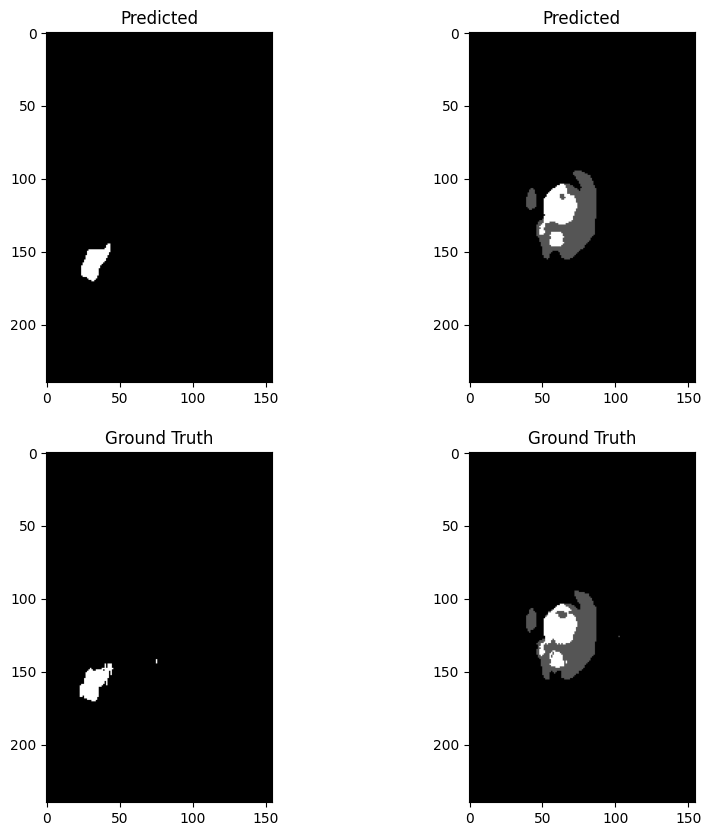

100%|██████████| 39/39 [05:21<00:00,  8.24s/it]


Average Validation Loss: 0.009470167092214793

Average Validation DSC: [0.99907482 0.90348518 0.94661734 0.78135629]
Average Validation ASSD: [ 0.10179027 15.74355011  6.57192512 25.74561785]
Epoch 69/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


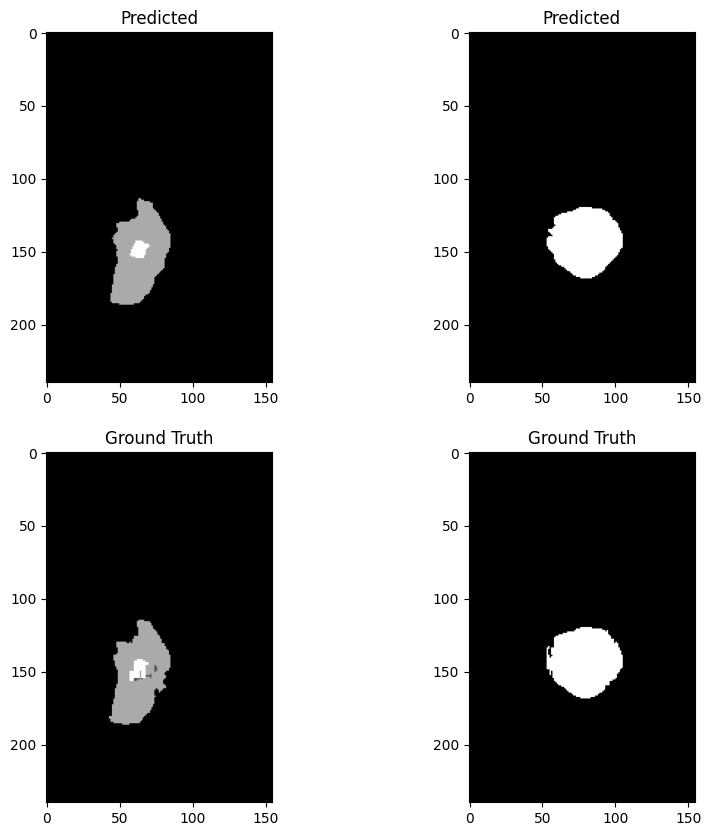

100%|██████████| 156/156 [21:22<00:00,  8.22s/it]



Average Training Loss: 0.006041023648905162

Average Training DSC: [0.99932091 0.94215892 0.94811539 0.80619789]
Average Training ASSD: [ 0.06288816  3.41059039  7.13812391 26.4823244 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


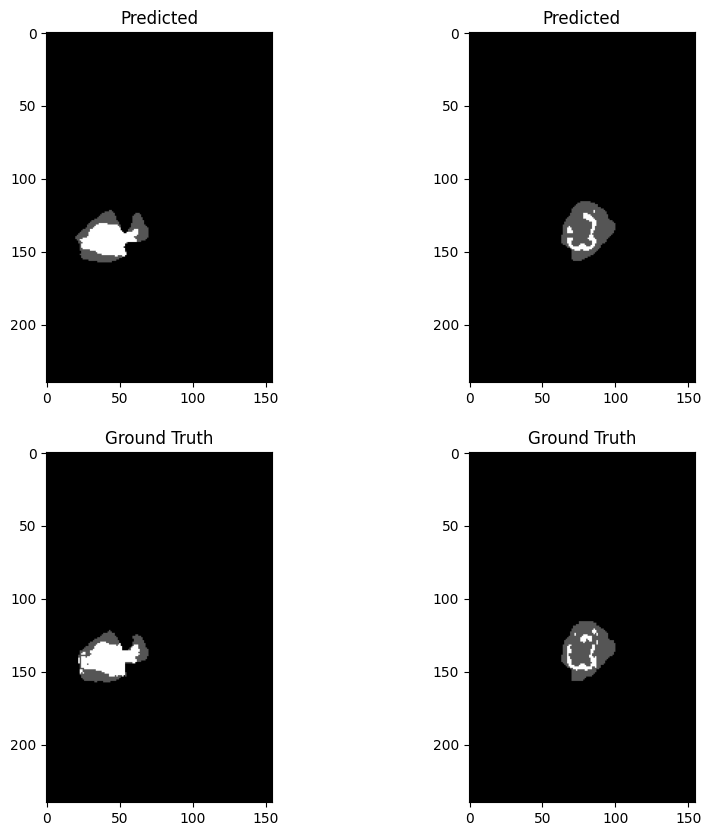

100%|██████████| 39/39 [05:03<00:00,  7.79s/it]


Average Validation Loss: 0.00941771520779301

Average Validation DSC: [0.99909519 0.90659258 0.94278757 0.77932888]
Average Validation ASSD: [ 0.09363576 13.50086922  8.63941408 25.37461257]
Epoch 70/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


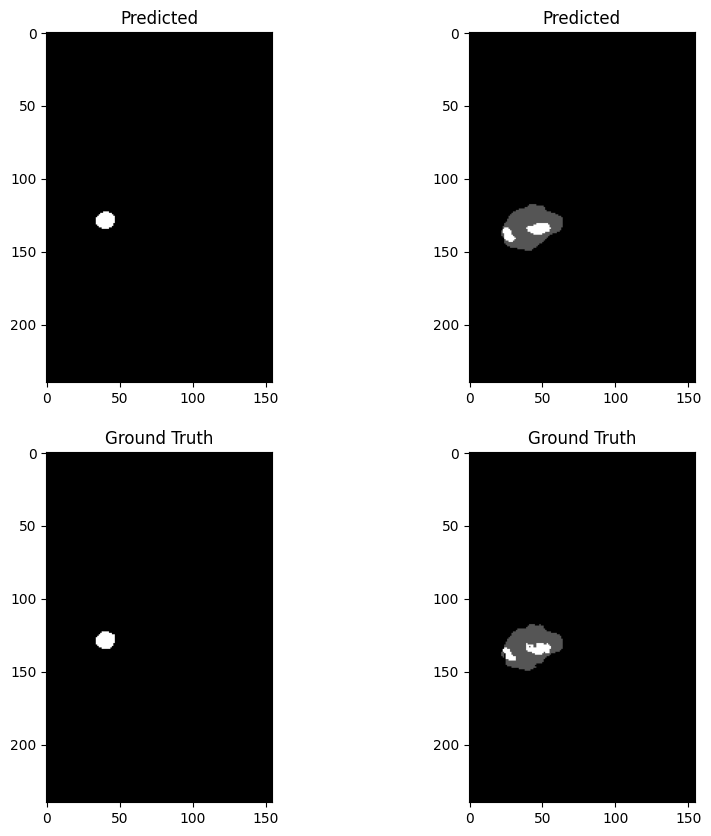

100%|██████████| 156/156 [21:12<00:00,  8.16s/it]



Average Training Loss: 0.005917792829374473

Average Training DSC: [0.99933971 0.94319224 0.94825877 0.80842616]
Average Training ASSD: [ 0.06212624  3.40941812  7.29470232 27.04909335]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


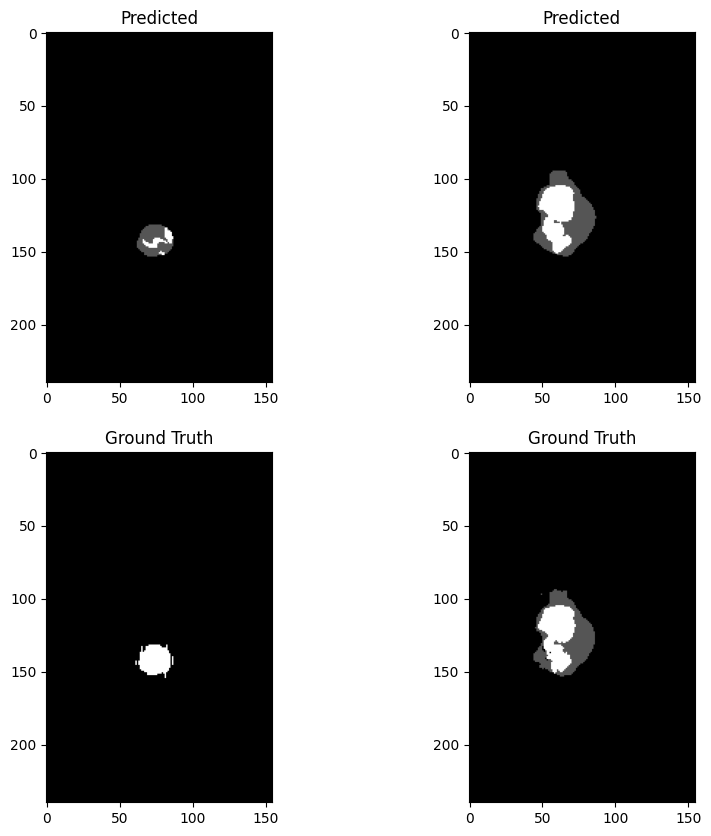

100%|██████████| 39/39 [05:20<00:00,  8.21s/it]


Average Validation Loss: 0.009848276236787057

Average Validation DSC: [0.99907586 0.90789206 0.94305197 0.77177642]
Average Validation ASSD: [ 0.0986123  14.26918154  8.0673563  26.64742599]
Epoch 71/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


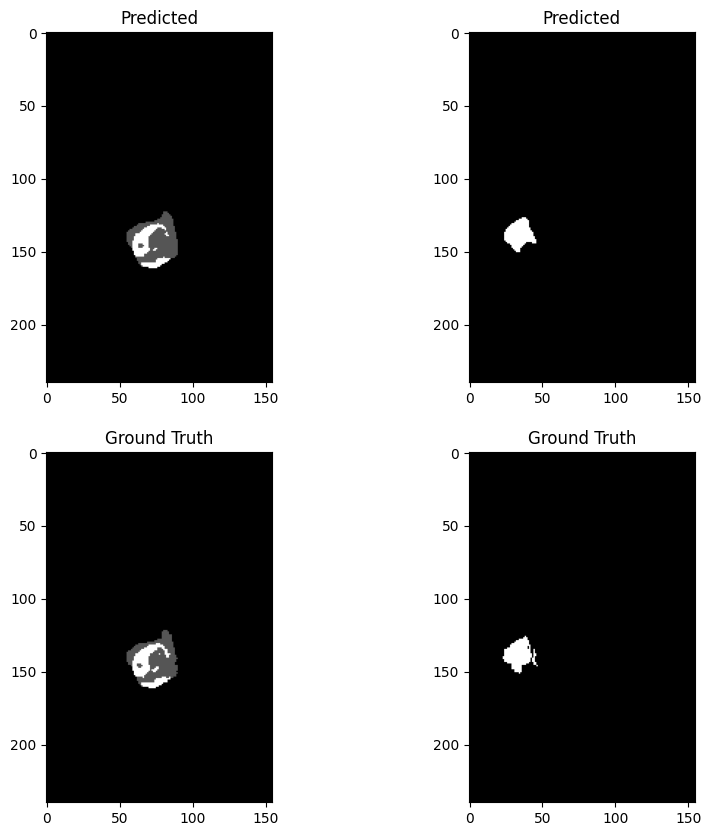

100%|██████████| 156/156 [21:12<00:00,  8.16s/it]



Average Training Loss: 0.005874959714651012

Average Training DSC: [0.99934342 0.94430132 0.94894688 0.80817849]
Average Training ASSD: [ 0.0619143   3.3295393   6.72430364 27.13028348]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


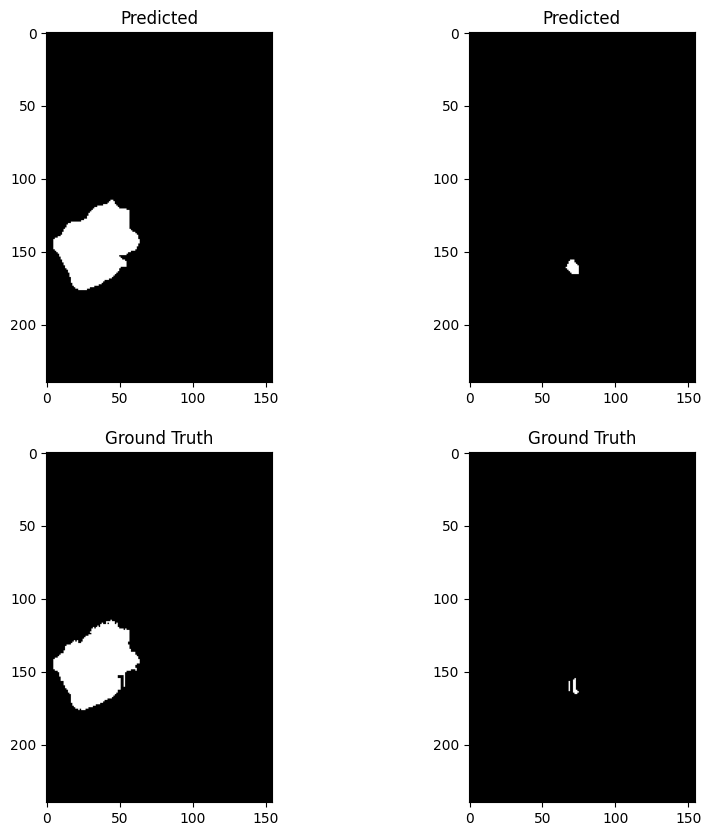

100%|██████████| 39/39 [05:01<00:00,  7.72s/it]


Average Validation Loss: 0.009393486755494123

Average Validation DSC: [0.99910188 0.90321883 0.94420569 0.79167593]
Average Validation ASSD: [ 0.09178397 15.45417361  8.60114953 20.15403108]
Epoch 72/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


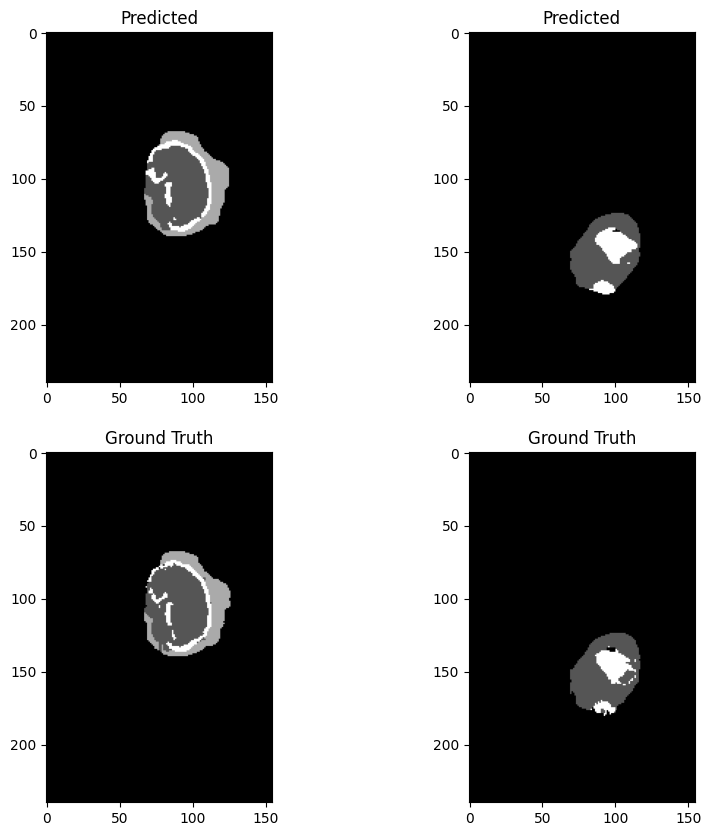

100%|██████████| 156/156 [20:28<00:00,  7.88s/it]



Average Training Loss: 0.005746486957949133

Average Training DSC: [0.99935468 0.94560469 0.94812617 0.81446115]
Average Training ASSD: [ 0.06006825  2.74738516  7.64316402 25.7080207 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


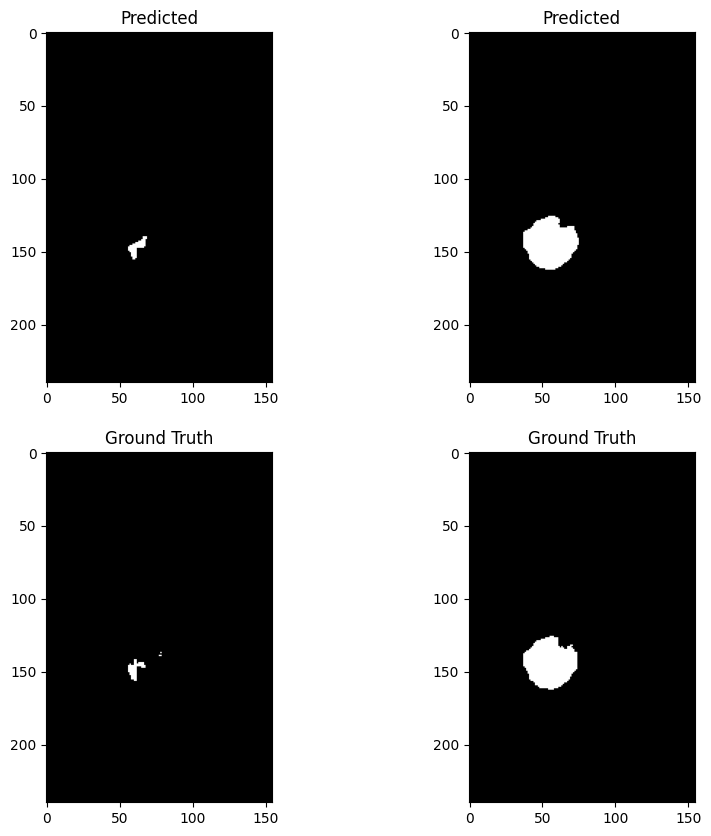

100%|██████████| 39/39 [05:00<00:00,  7.70s/it]


Average Validation Loss: 0.00959809358494404

Average Validation DSC: [0.99910138 0.9021985  0.94395567 0.78755112]
Average Validation ASSD: [ 0.09582491 16.57033997  7.21358813 23.15531342]
Epoch 73/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


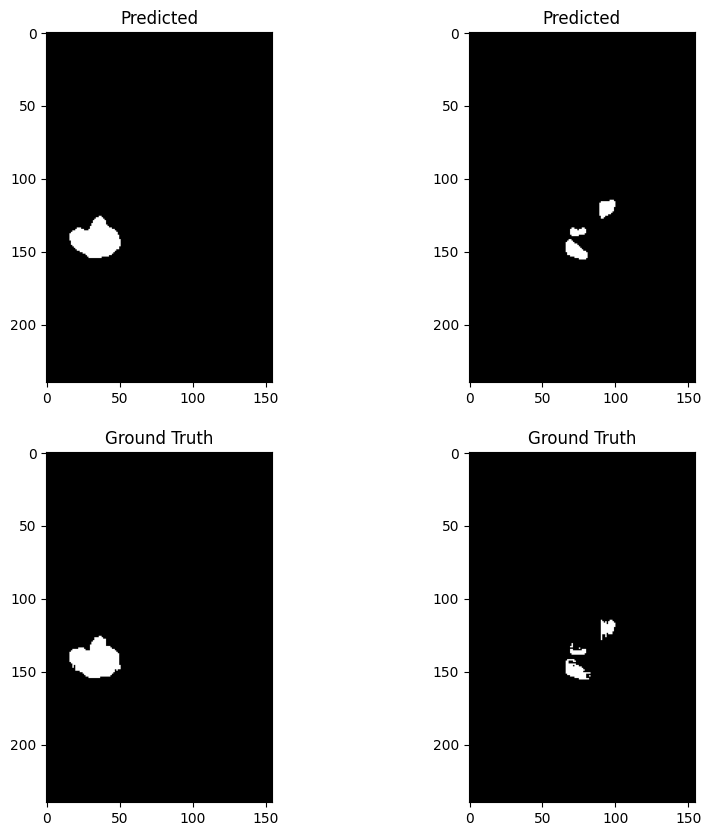

100%|██████████| 156/156 [20:08<00:00,  7.74s/it]



Average Training Loss: 0.005674229218409612

Average Training DSC: [0.99936301 0.94530325 0.94944825 0.81630664]
Average Training ASSD: [ 0.05961169  3.24761947  6.85005633 25.39775132]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


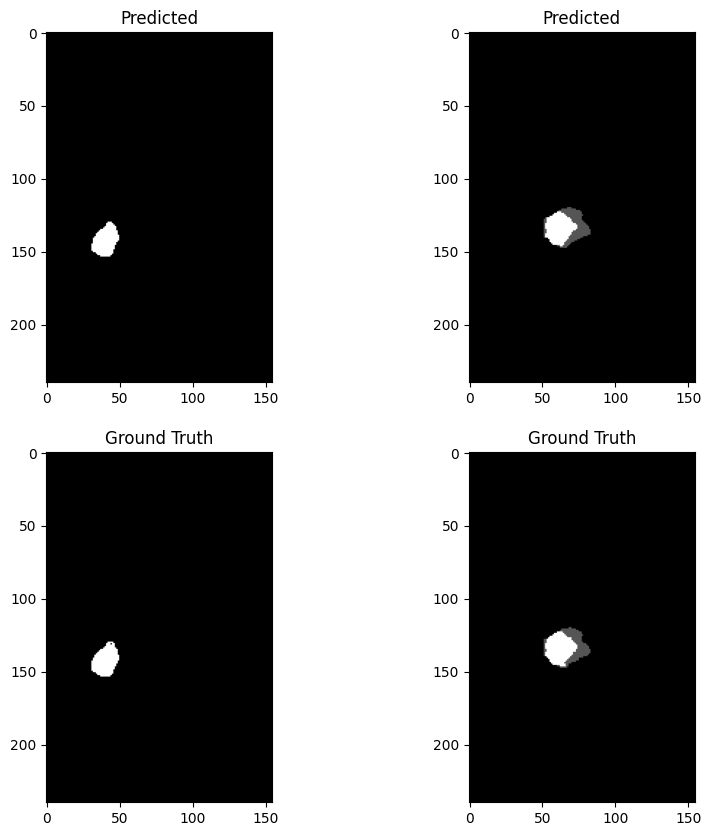

100%|██████████| 39/39 [05:16<00:00,  8.10s/it]


Average Validation Loss: 0.010225981366462432

Average Validation DSC: [0.99910266 0.89534407 0.9419507  0.76255634]
Average Validation ASSD: [ 0.09494525 16.36325004  8.65347773 26.04230167]
Epoch 74/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


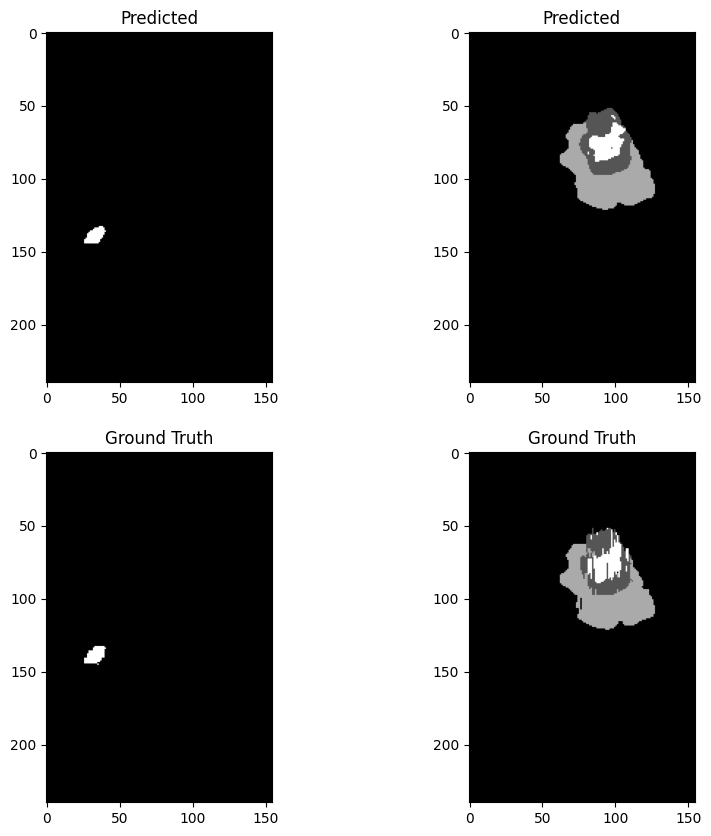

100%|██████████| 156/156 [20:03<00:00,  7.72s/it]



Average Training Loss: 0.005643373370194473

Average Training DSC: [0.99936015 0.94438136 0.95020739 0.81678766]
Average Training ASSD: [ 0.05932718  3.61041192  7.20487241 25.44166432]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


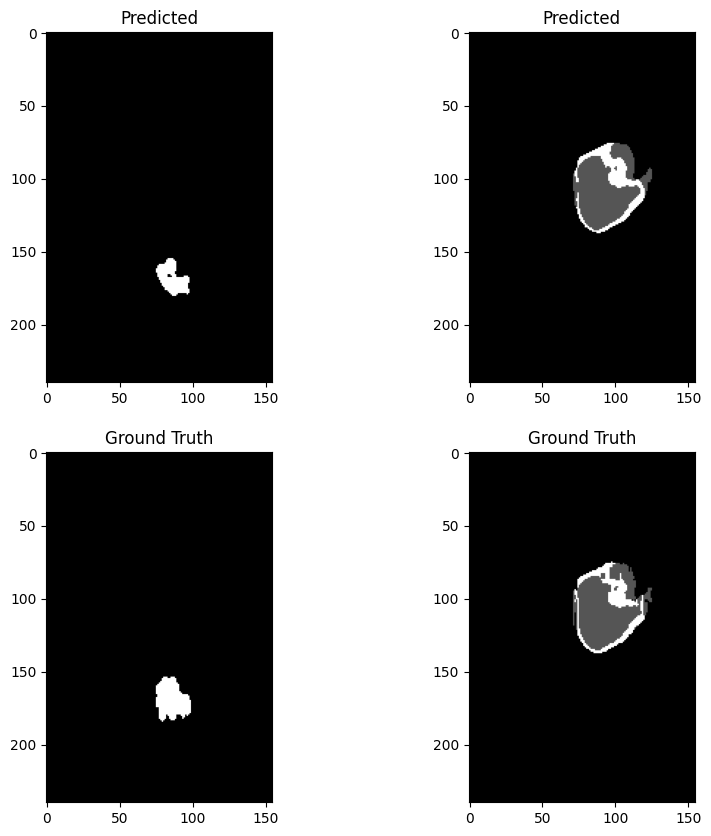

100%|██████████| 39/39 [05:02<00:00,  7.75s/it]


Average Validation Loss: 0.009635001253814269

Average Validation DSC: [0.99909923 0.90351825 0.94709928 0.77706323]
Average Validation ASSD: [ 0.10349882 15.99880628  7.1772261  27.6262528 ]
Epoch 75/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


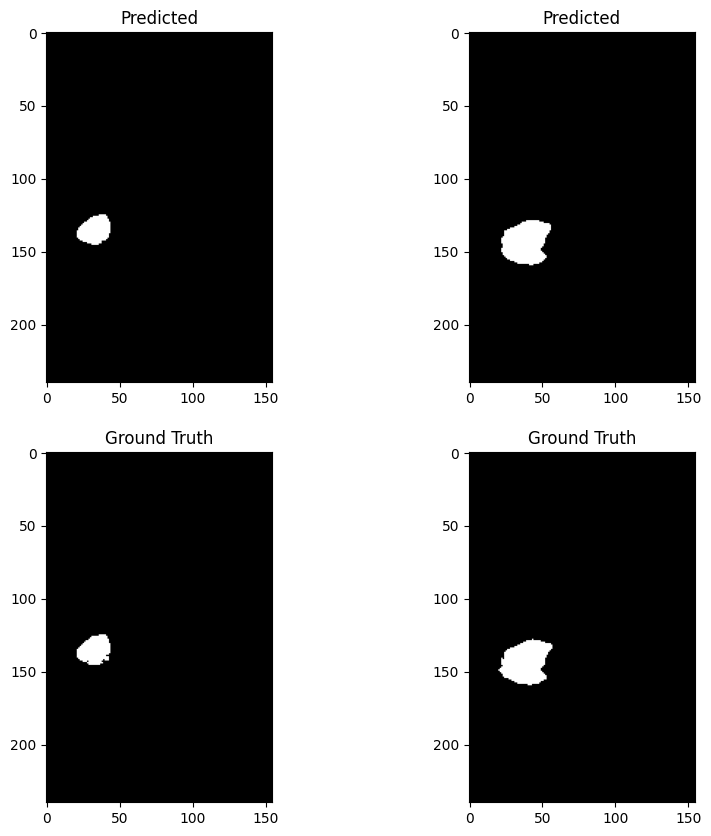

100%|██████████| 156/156 [20:07<00:00,  7.74s/it]



Average Training Loss: 0.005732326198202104

Average Training DSC: [0.99935352 0.94418822 0.94897075 0.81432984]
Average Training ASSD: [ 0.06053012  3.25391409  7.20586337 24.62922696]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


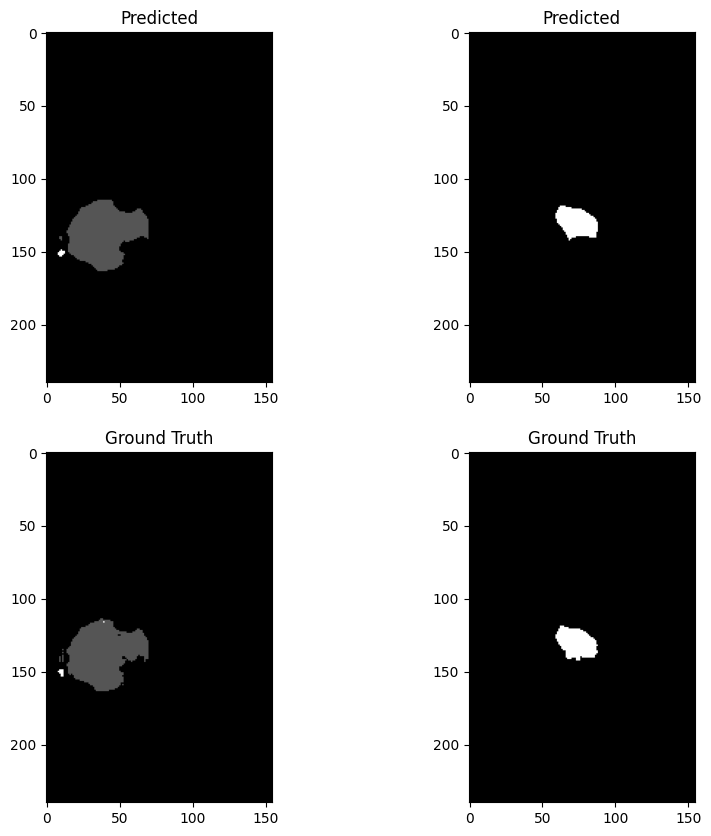

100%|██████████| 39/39 [05:00<00:00,  7.71s/it]


Average Validation Loss: 0.00992191395459649

Average Validation DSC: [0.99907778 0.89957855 0.93410552 0.78758166]
Average Validation ASSD: [ 0.09680852 14.91164944  9.5213971  15.2157593 ]
Epoch 76/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


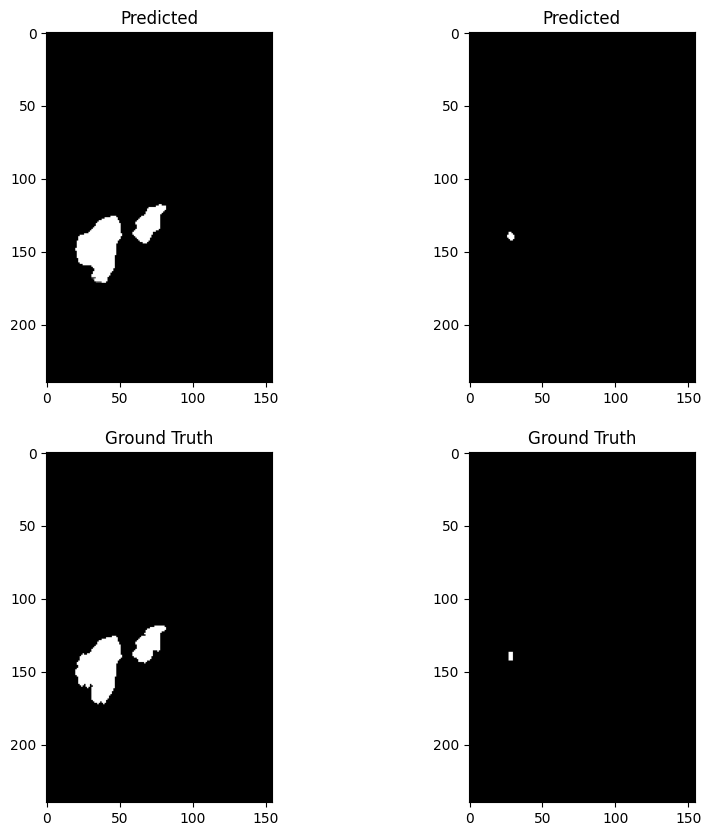

100%|██████████| 156/156 [20:41<00:00,  7.96s/it]



Average Training Loss: 0.005630784194904546

Average Training DSC: [0.99936009 0.94487269 0.9466902  0.81884831]
Average Training ASSD: [ 0.06029912  3.70801164  7.88487573 23.9684984 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


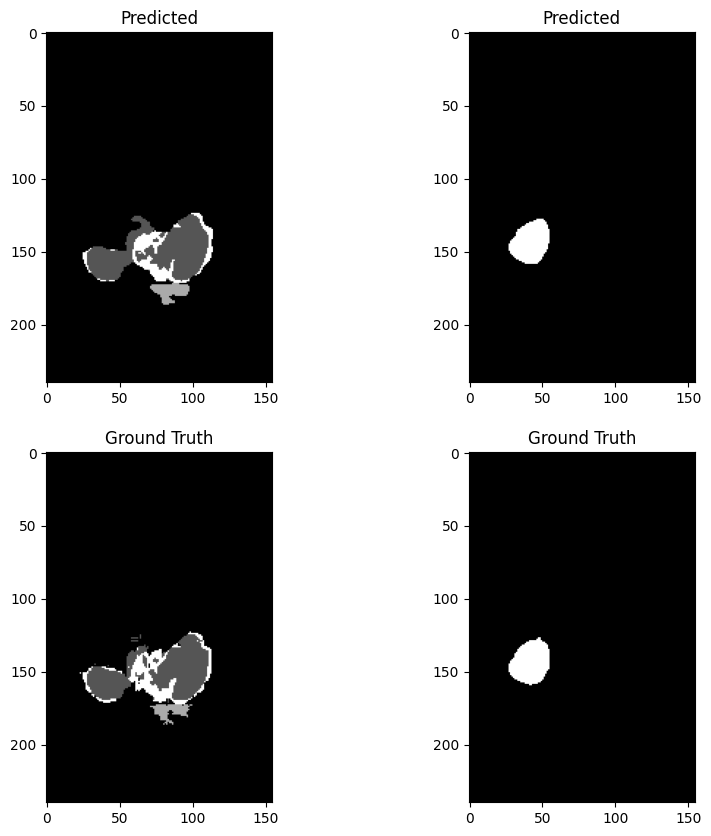

100%|██████████| 39/39 [04:33<00:00,  7.00s/it]


Average Validation Loss: 0.01001965767966631

Average Validation DSC: [0.99907954 0.89667847 0.9459189  0.7594275 ]
Average Validation ASSD: [ 0.09195828 16.04117567  7.78690279 28.46380723]
Epoch 77/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


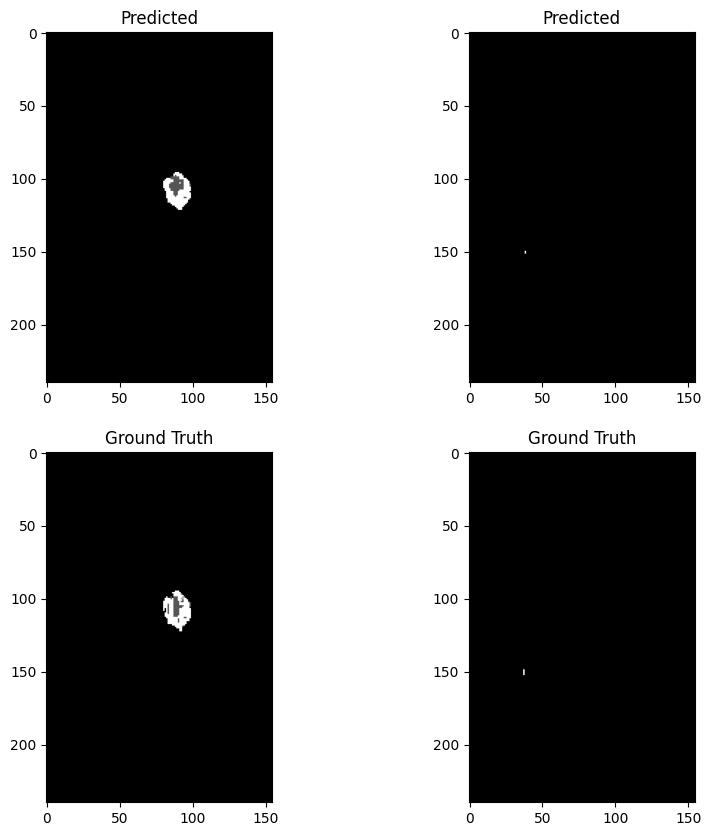

100%|██████████| 156/156 [19:36<00:00,  7.54s/it]



Average Training Loss: 0.005479801529779648

Average Training DSC: [0.99938009 0.94602341 0.94985018 0.82010243]
Average Training ASSD: [ 0.05764994  3.17233111  7.21770479 24.43444906]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


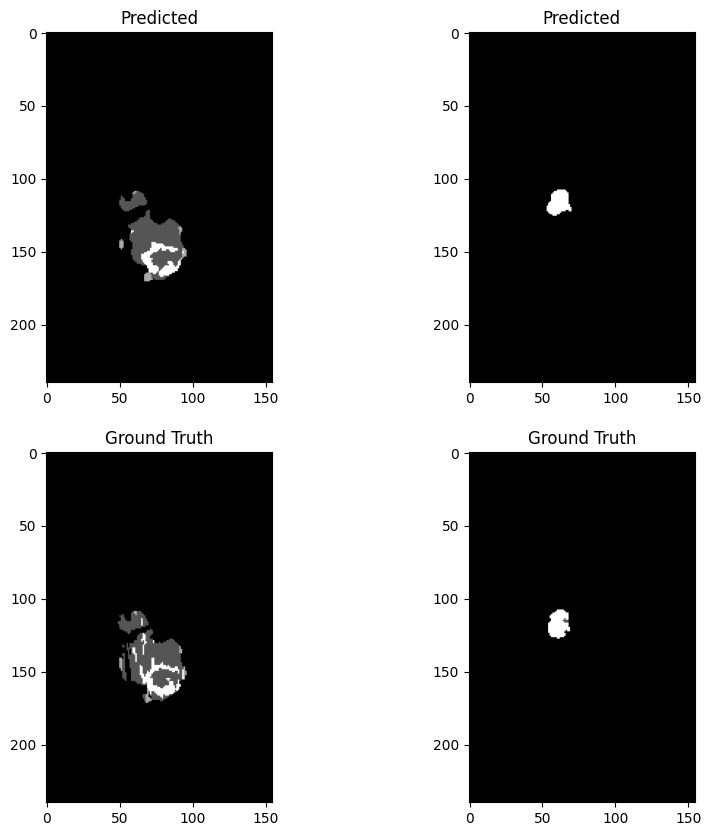

100%|██████████| 39/39 [05:05<00:00,  7.83s/it]


Average Validation Loss: 0.010166990439383647

Average Validation DSC: [0.99905823 0.90393473 0.93712973 0.77990181]
Average Validation ASSD: [ 0.0944346  14.88877954  8.96109408 25.08474636]
Epoch 78/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


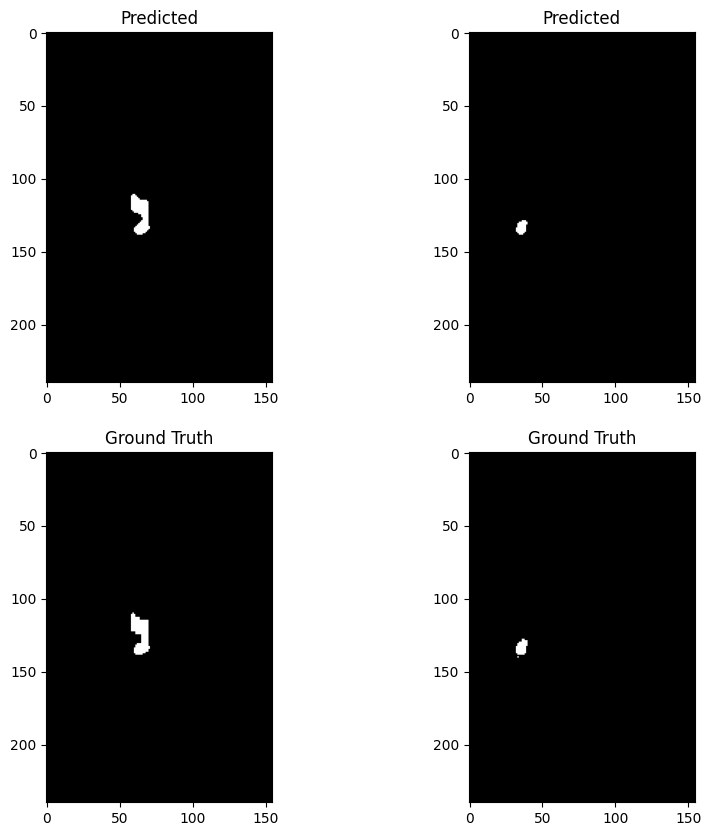

100%|██████████| 156/156 [21:07<00:00,  8.13s/it]



Average Training Loss: 0.007541269547520922

Average Training DSC: [0.99916349 0.89688042 0.93359801 0.78282008]
Average Training ASSD: [ 0.08454698 16.40830017 10.2884037  24.52542447]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


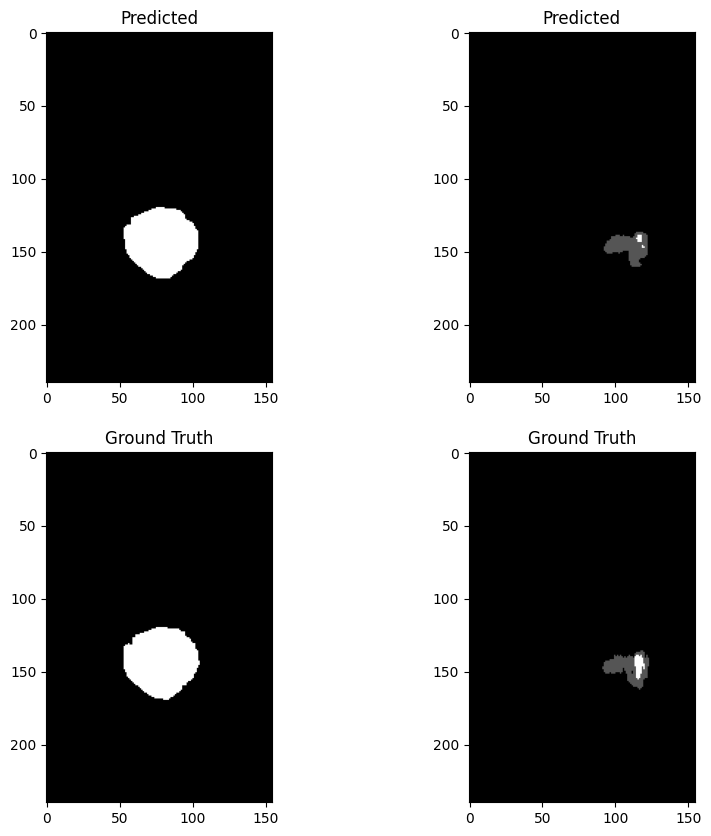

100%|██████████| 39/39 [05:05<00:00,  7.84s/it]


Average Validation Loss: 0.01671825932004513

Average Validation DSC: [0.99856408 0.75375243 0.87909106 0.59920493]
Average Validation ASSD: [ 0.18053357 59.2380732  25.70328853 52.48756654]
Epoch 79/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


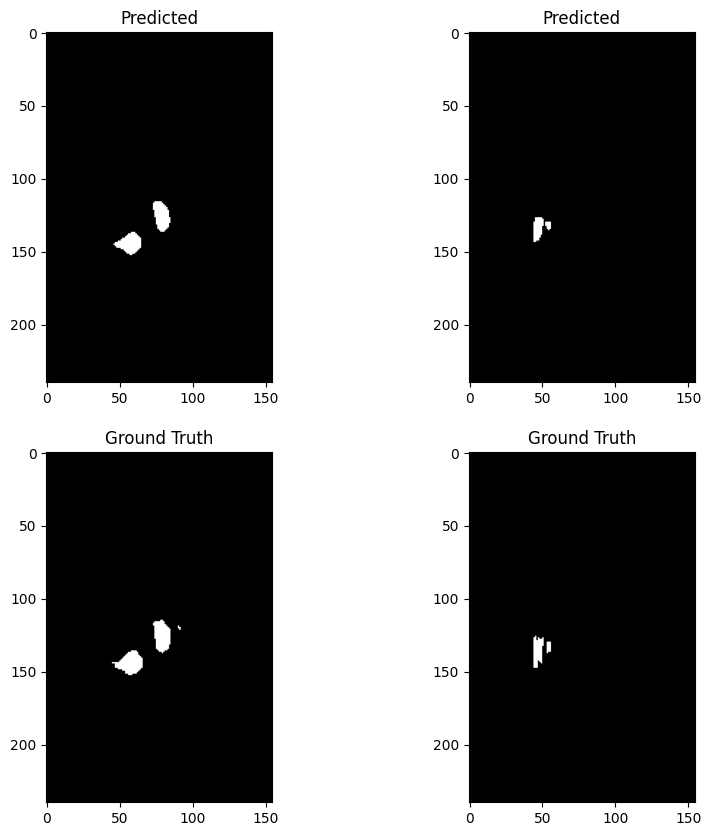

100%|██████████| 156/156 [19:49<00:00,  7.63s/it]



Average Training Loss: 0.0121749537722327

Average Training DSC: [0.99867685 0.83606803 0.87888644 0.70927266]
Average Training ASSD: [ 0.14757137 30.16201192 25.74045556 29.04152746]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


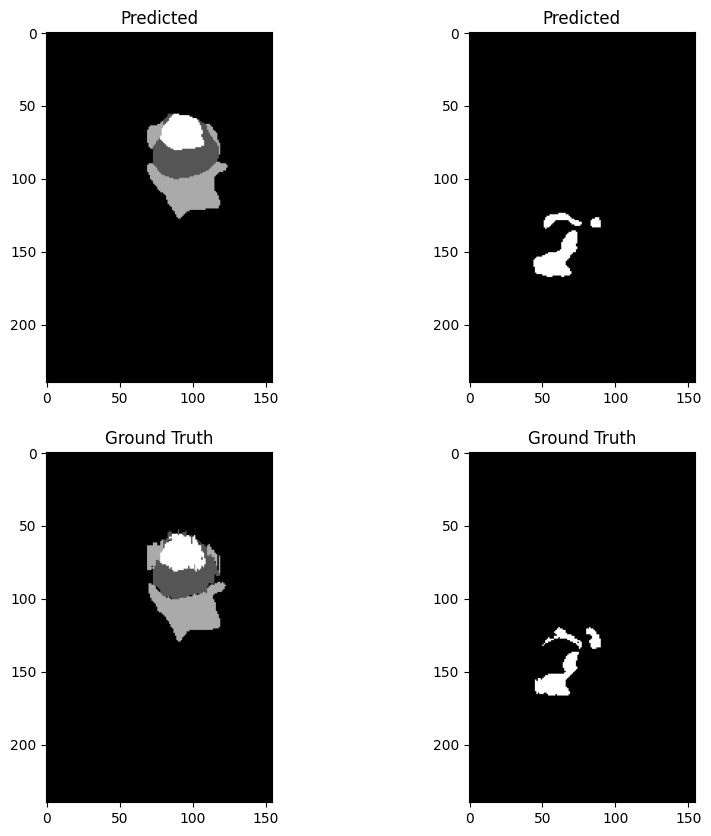

100%|██████████| 39/39 [04:59<00:00,  7.69s/it]


Average Validation Loss: 0.011841248756704422

Average Validation DSC: [0.99883489 0.83585657 0.91672854 0.71785956]
Average Validation ASSD: [ 0.13397525 35.63492287 15.23036779 28.20419211]
Epoch 80/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


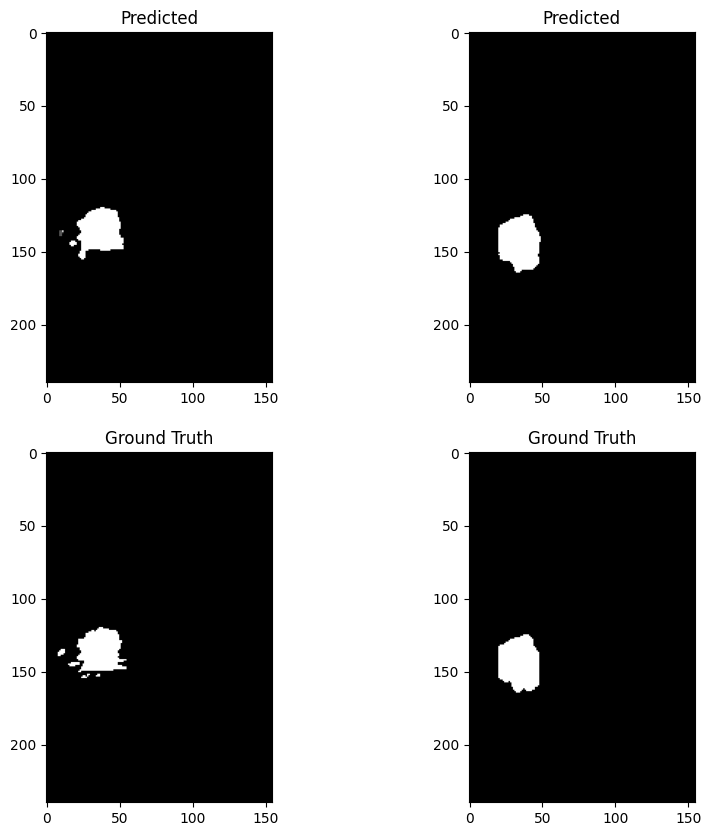

100%|██████████| 156/156 [20:37<00:00,  7.93s/it]



Average Training Loss: 0.0077676144294225825

Average Training DSC: [0.99912712 0.90355347 0.93604828 0.77015806]
Average Training ASSD: [ 0.08767332 13.28472471  9.88671792 25.92541185]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


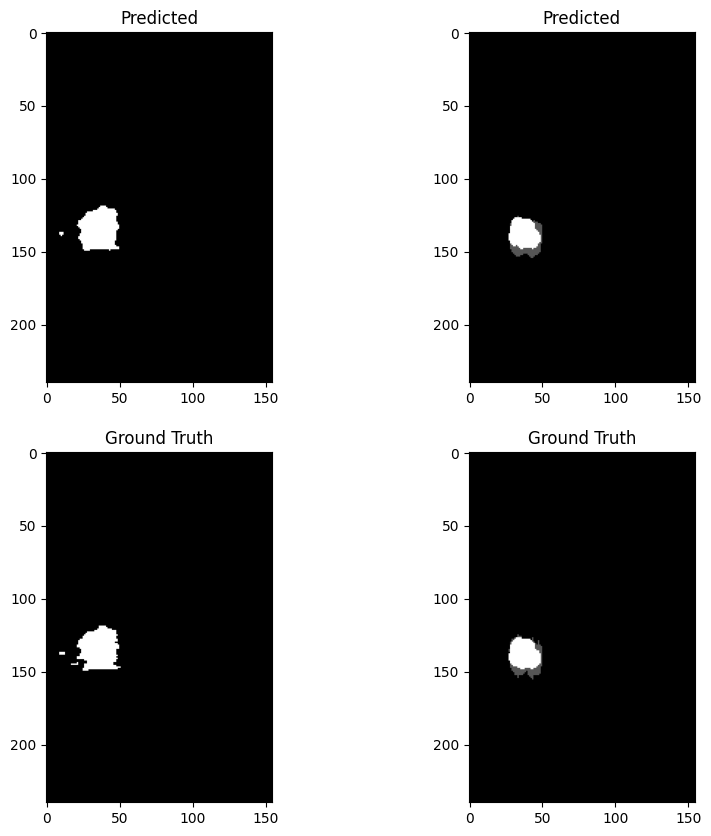

100%|██████████| 39/39 [04:38<00:00,  7.15s/it]


Average Validation Loss: 0.00969799741720542

Average Validation DSC: [0.999054   0.89734914 0.94347298 0.76566644]
Average Validation ASSD: [ 0.10933981 16.07688574  8.93536195 27.37982022]
Epoch 81/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


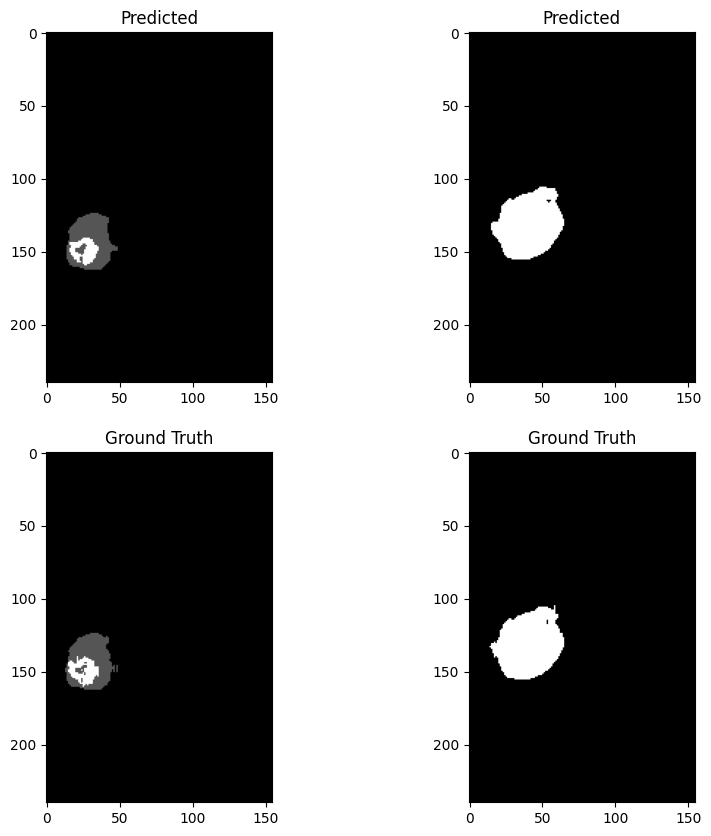

100%|██████████| 156/156 [20:12<00:00,  7.78s/it]



Average Training Loss: 0.006118380918334692

Average Training DSC: [0.99931704 0.93214439 0.94727333 0.80326842]
Average Training ASSD: [ 0.06664846  6.8301103   7.7886058  26.74876489]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


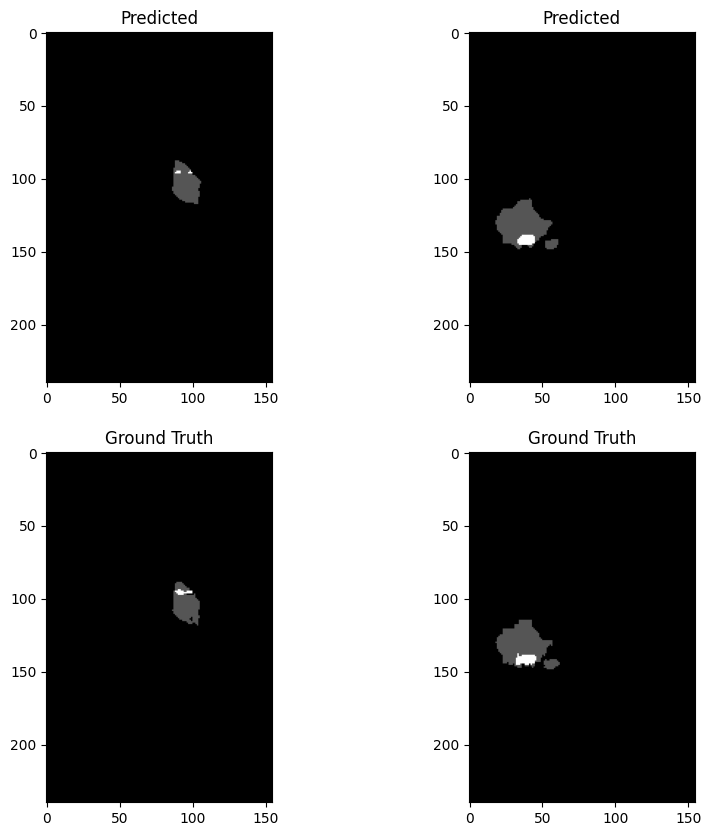

100%|██████████| 39/39 [04:50<00:00,  7.44s/it]


Average Validation Loss: 0.009984438247883167

Average Validation DSC: [0.99897384 0.89643188 0.94590305 0.75993453]
Average Validation ASSD: [ 0.10914125 17.239069    7.4810977  25.79999309]
Epoch 82/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


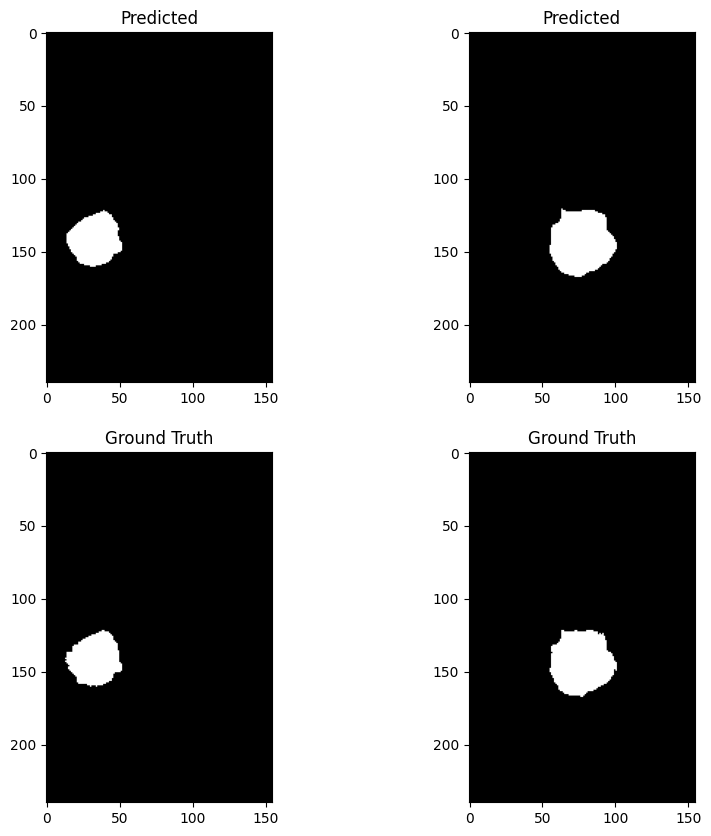

100%|██████████| 156/156 [20:49<00:00,  8.01s/it]



Average Training Loss: 0.0054821689219142385

Average Training DSC: [0.9993761  0.94445252 0.95082633 0.8194707 ]
Average Training ASSD: [ 0.05885204  4.11211634  6.97128105 24.75461666]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


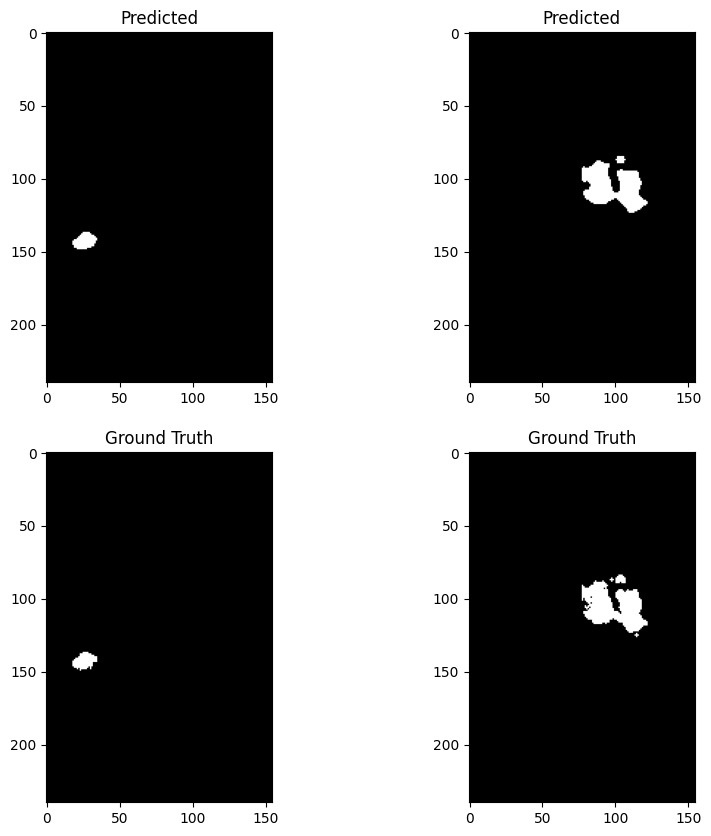

100%|██████████| 39/39 [04:56<00:00,  7.59s/it]


Average Validation Loss: 0.009153499411275754

Average Validation DSC: [0.99914135 0.90551096 0.94649097 0.78656114]
Average Validation ASSD: [ 0.09613948 14.88308876  7.73858235 23.11777672]
Epoch 83/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


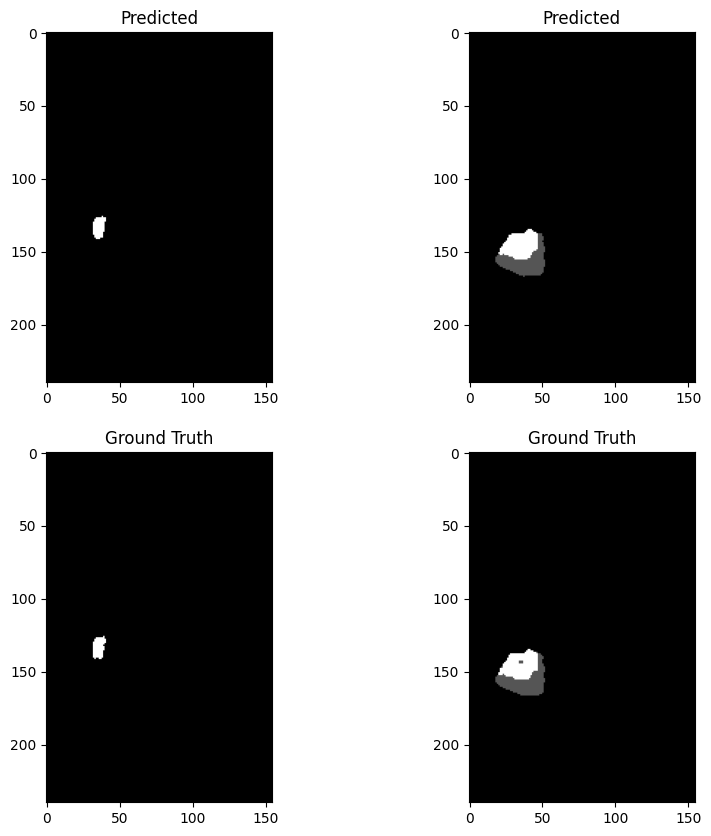

100%|██████████| 156/156 [20:58<00:00,  8.07s/it]



Average Training Loss: 0.005285329857053092

Average Training DSC: [0.99940601 0.94702007 0.95017753 0.82420574]
Average Training ASSD: [ 0.05597517  3.5213619   7.55438209 24.95454547]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


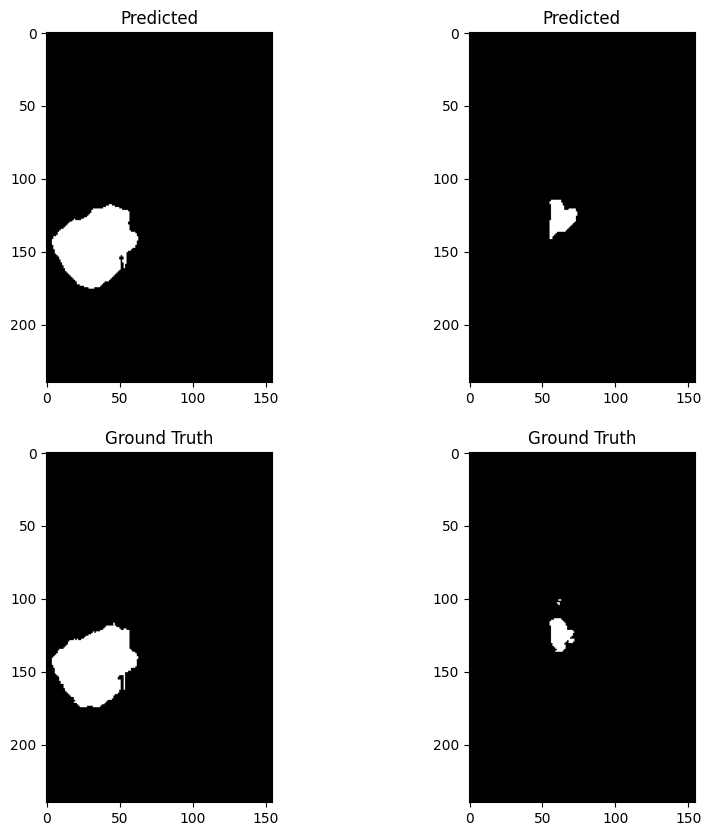

100%|██████████| 39/39 [05:05<00:00,  7.83s/it]


Average Validation Loss: 0.009212200237342563

Average Validation DSC: [0.99917015 0.91007969 0.94973838 0.78990469]
Average Validation ASSD: [ 0.08975864 13.72181432  6.85780782 25.04691647]
Epoch 84/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


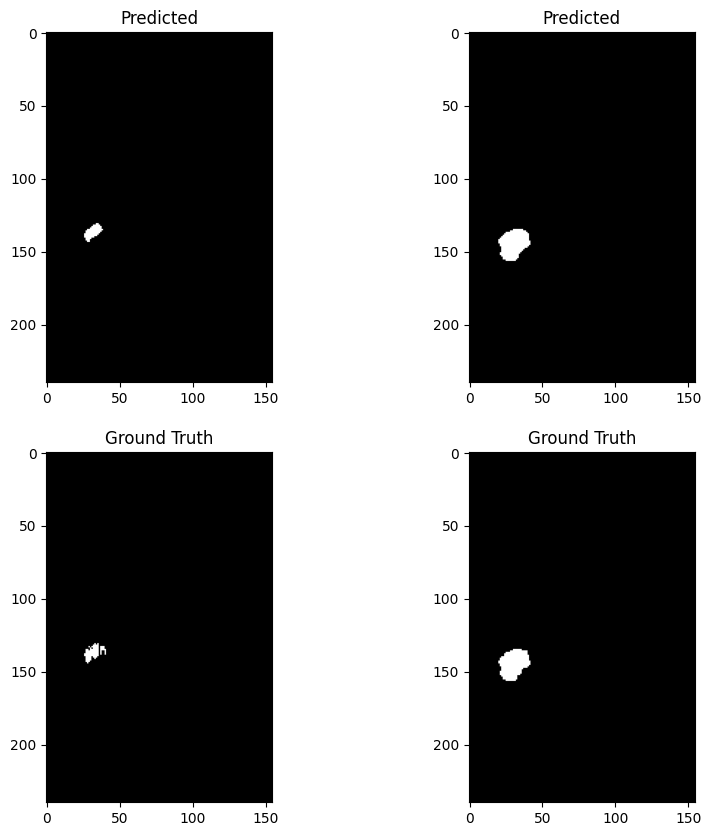

100%|██████████| 156/156 [21:33<00:00,  8.29s/it]



Average Training Loss: 0.005037386271839914

Average Training DSC: [0.99943413 0.95199489 0.95249159 0.83141879]
Average Training ASSD: [ 0.05323177  2.41982321  6.95568858 24.20503868]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


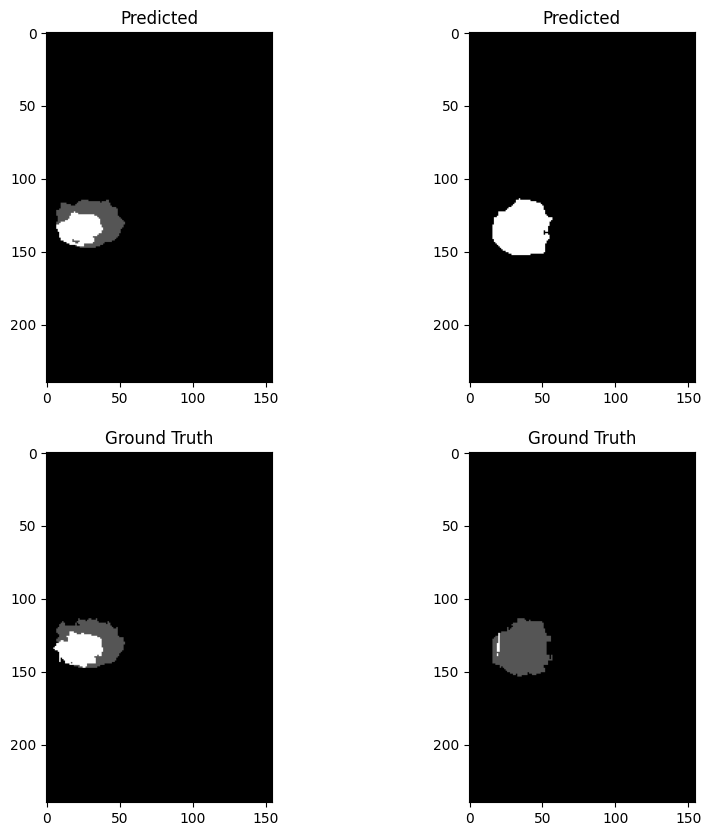

100%|██████████| 39/39 [04:43<00:00,  7.26s/it]


Average Validation Loss: 0.00943464415673262

Average Validation DSC: [0.99917891 0.91290135 0.94961593 0.79420612]
Average Validation ASSD: [ 0.08804499 12.89195215  6.84832113 22.42253224]
Epoch 85/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


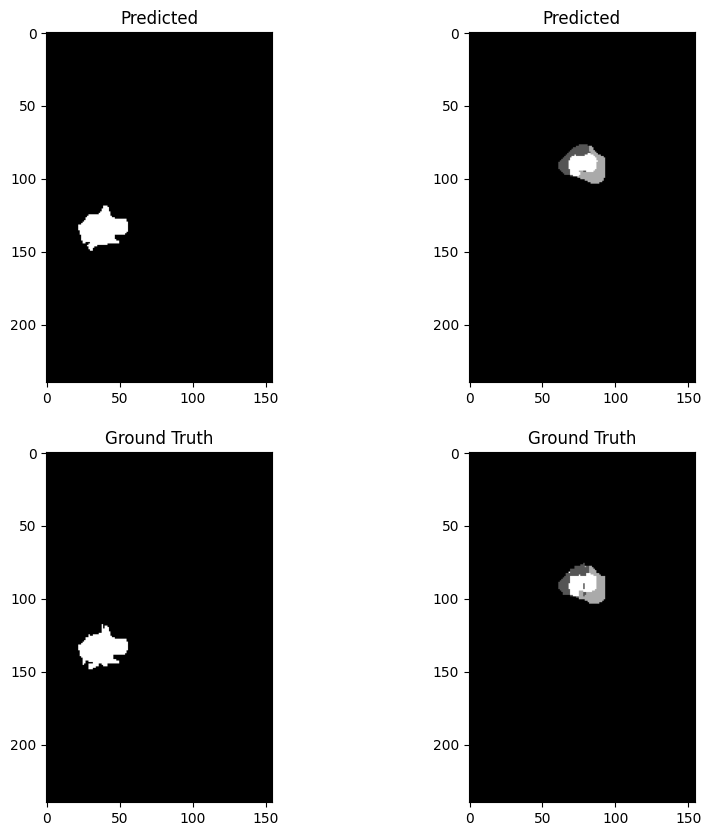

100%|██████████| 156/156 [21:20<00:00,  8.21s/it]



Average Training Loss: 0.004863545977665733

Average Training DSC: [0.99945967 0.95295539 0.95518653 0.83639581]
Average Training ASSD: [ 0.05056774  2.62550786  6.51786859 22.28696814]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


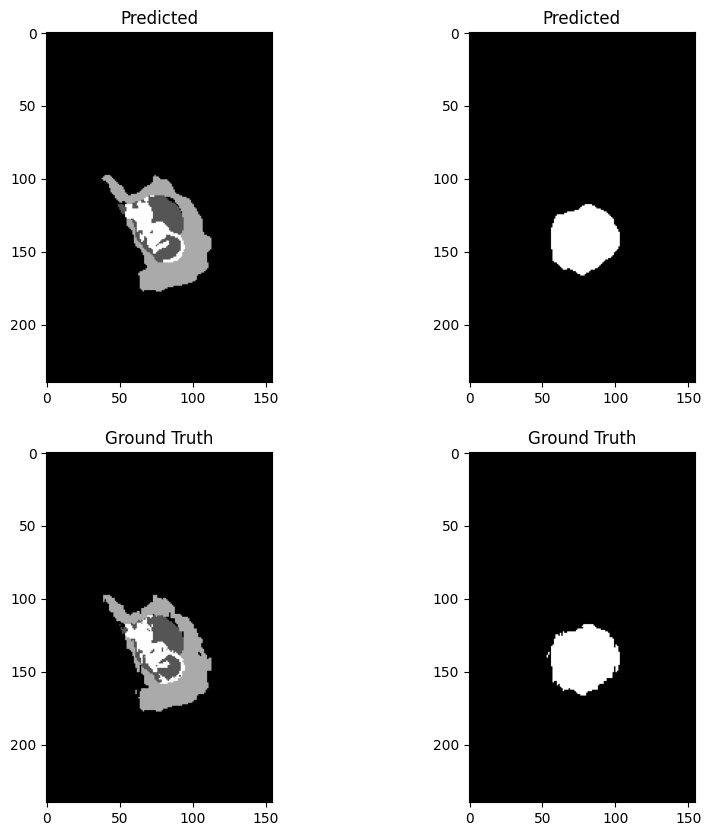

100%|██████████| 39/39 [05:04<00:00,  7.81s/it]


Average Validation Loss: 0.009295967455284718

Average Validation DSC: [0.99919054 0.91016491 0.94952939 0.79846287]
Average Validation ASSD: [ 0.08692158 14.27546799  7.41991355 22.40709927]
Epoch 86/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


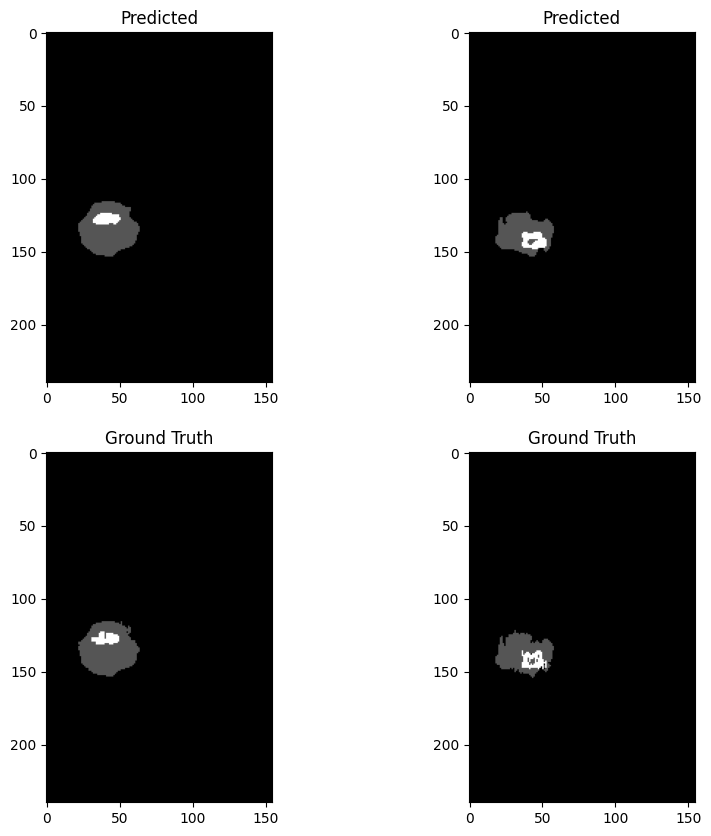

100%|██████████| 156/156 [20:41<00:00,  7.96s/it]



Average Training Loss: 0.004717105641387976

Average Training DSC: [0.99947911 0.95428182 0.95688689 0.83919236]
Average Training ASSD: [ 0.04755664  2.33319703  6.14950202 21.89093208]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


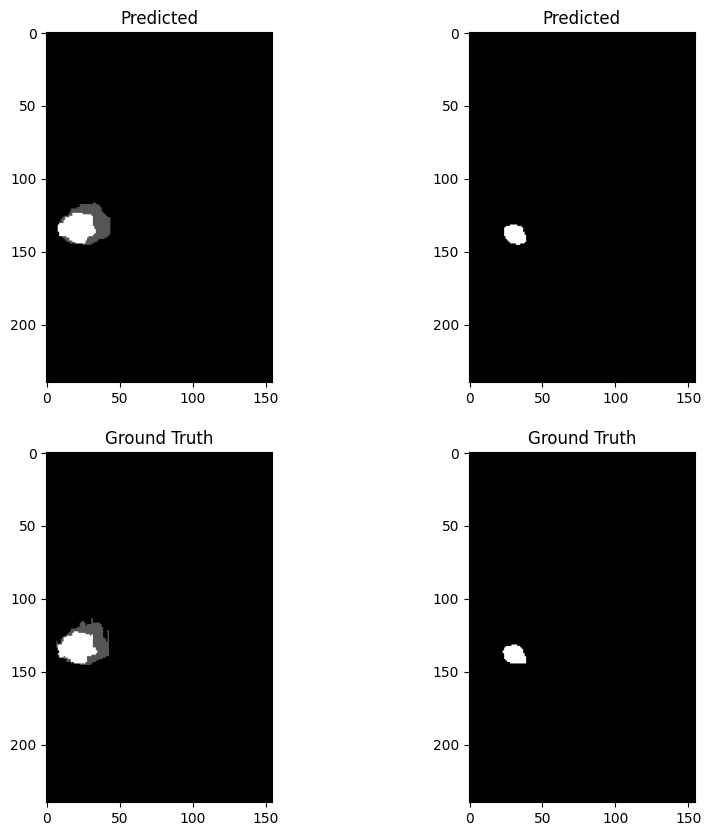

100%|██████████| 39/39 [05:00<00:00,  7.71s/it]


Average Validation Loss: 0.009569085203111172

Average Validation DSC: [0.99920435 0.91112607 0.95235356 0.79399261]
Average Validation ASSD: [ 0.08318456 14.23815137  6.26442222 23.9493412 ]
Epoch 87/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


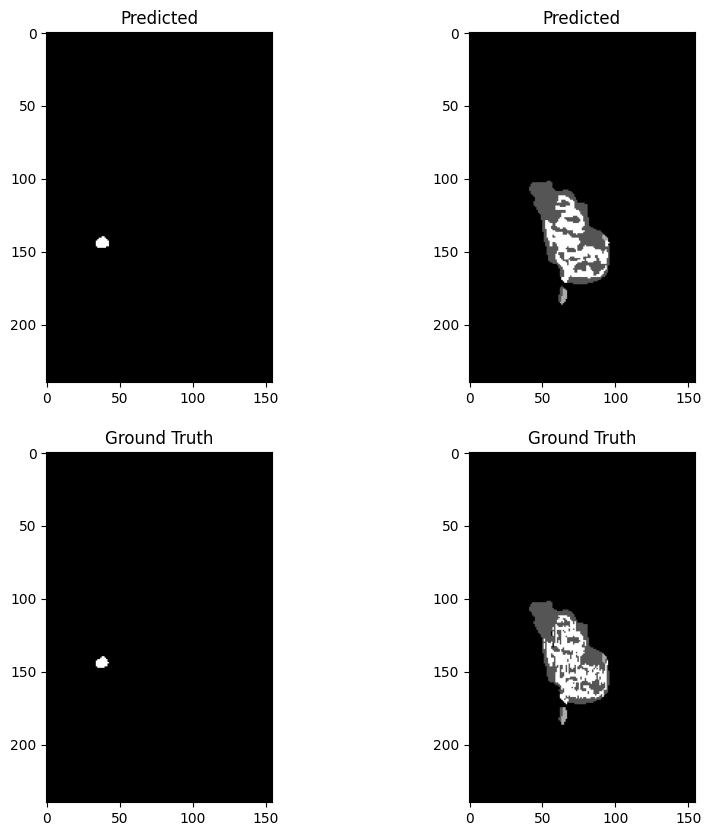

100%|██████████| 156/156 [20:44<00:00,  7.98s/it]



Average Training Loss: 0.004732568151293657

Average Training DSC: [0.99948029 0.9544631  0.95599618 0.83799963]
Average Training ASSD: [ 0.04772725  2.26276315  6.08565774 22.62201039]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


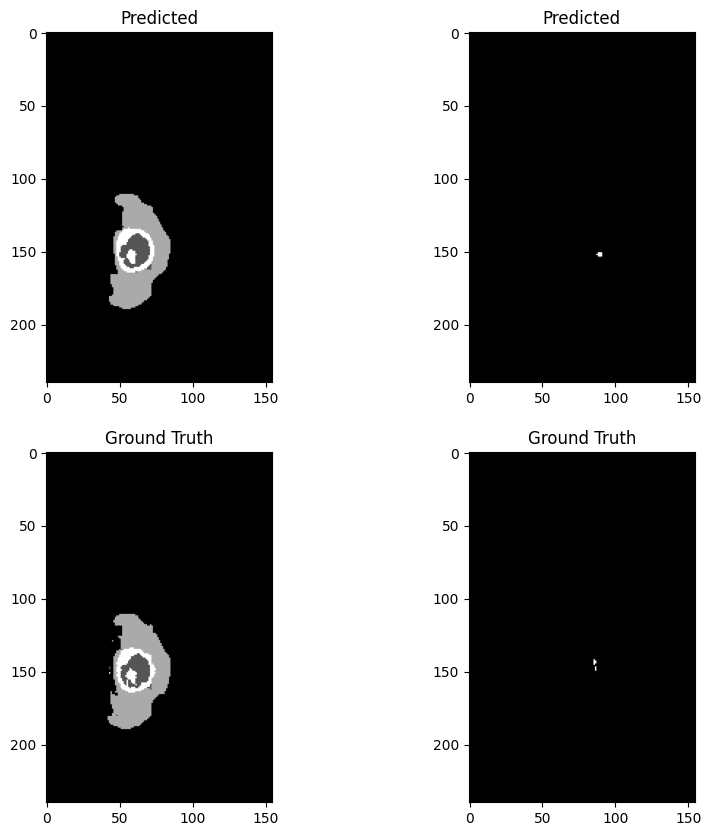

100%|██████████| 39/39 [04:29<00:00,  6.91s/it]


Average Validation Loss: 0.009383470381204134

Average Validation DSC: [0.9991945  0.91218782 0.94813662 0.79938436]
Average Validation ASSD: [ 0.08603262 13.73786833  7.78338764 22.1638934 ]
Epoch 88/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


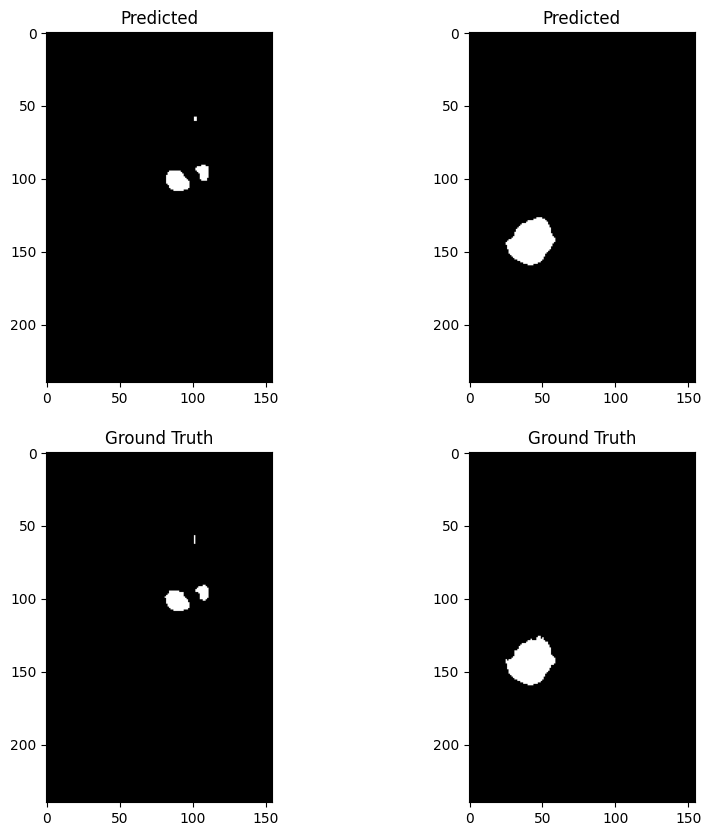

100%|██████████| 156/156 [16:45<00:00,  6.44s/it]



Average Training Loss: 0.004723939286449399

Average Training DSC: [0.99948174 0.95482658 0.95383474 0.83999584]
Average Training ASSD: [ 0.04759769  1.97675271  6.75711882 22.00305038]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


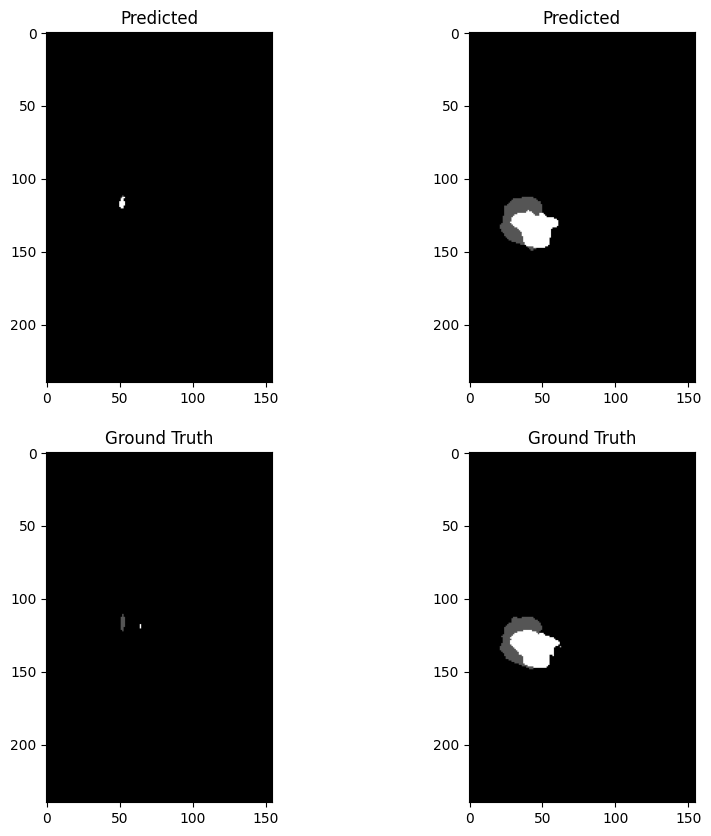

100%|██████████| 39/39 [03:09<00:00,  4.87s/it]


Average Validation Loss: 0.009669637355284814

Average Validation DSC: [0.99918943 0.91315139 0.94697851 0.79422084]
Average Validation ASSD: [ 0.08430653 13.12882458  6.35991756 23.61229631]
Epoch 89/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


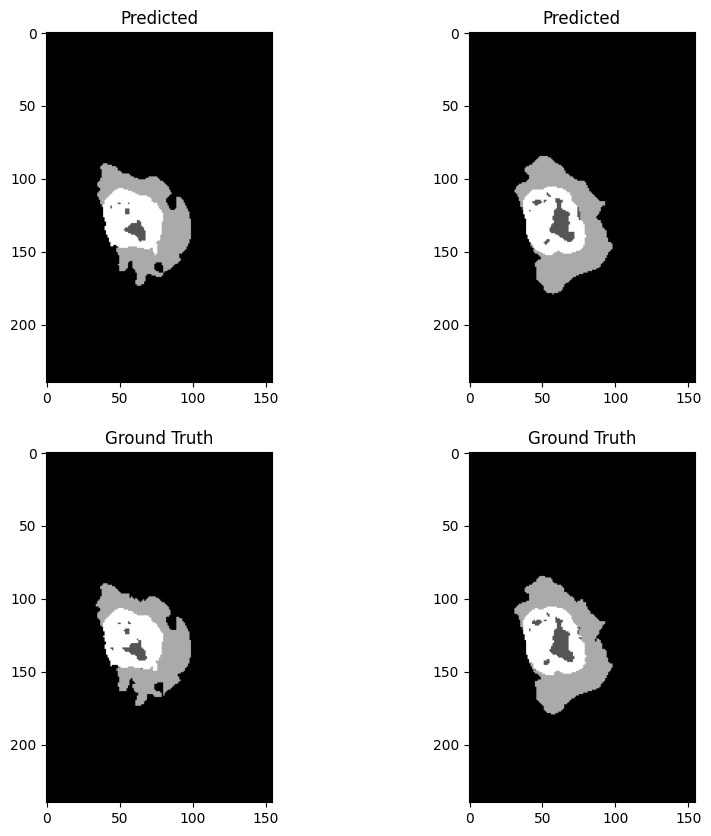

100%|██████████| 156/156 [15:21<00:00,  5.91s/it]



Average Training Loss: 0.004632354709498871

Average Training DSC: [0.99948941 0.95425124 0.95560496 0.84490573]
Average Training ASSD: [ 0.04595334  2.76344725  6.47948021 20.77119258]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


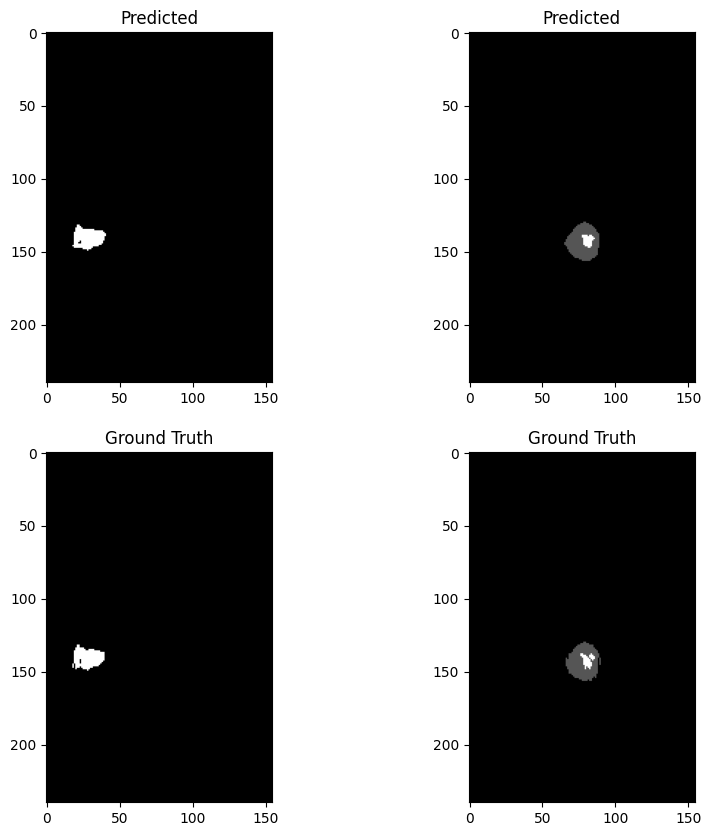

100%|██████████| 39/39 [03:19<00:00,  5.12s/it]


Average Validation Loss: 0.009636050084223732

Average Validation DSC: [0.99919131 0.91103942 0.94947069 0.79467081]
Average Validation ASSD: [ 0.08785794 13.16086225  7.43402065 23.26378363]
Epoch 90/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


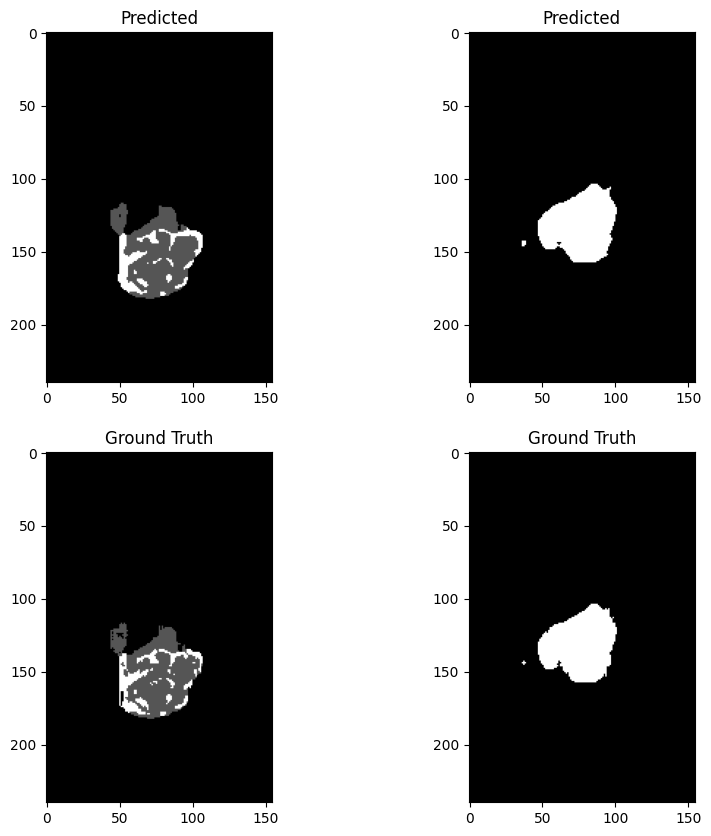

100%|██████████| 156/156 [15:39<00:00,  6.03s/it]



Average Training Loss: 0.004684930216544905

Average Training DSC: [0.99948537 0.95327941 0.95437996 0.84113957]
Average Training ASSD: [ 0.04822674  2.5962205   6.45875665 21.6171204 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


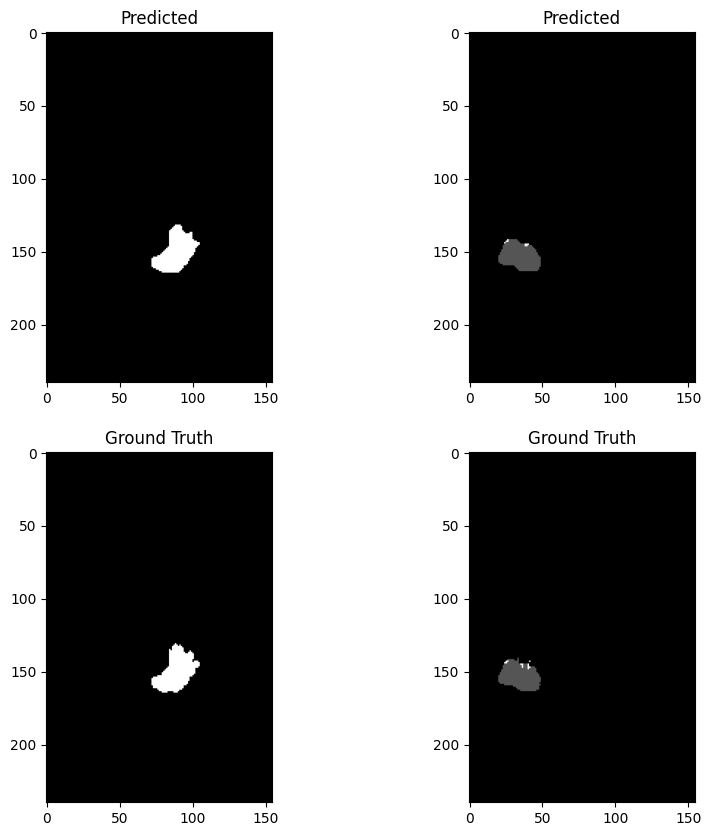

100%|██████████| 39/39 [03:37<00:00,  5.58s/it]


Average Validation Loss: 0.00926236771285916

Average Validation DSC: [0.99920064 0.9129116  0.9493817  0.80436766]
Average Validation ASSD: [ 0.08190994 13.44628286  6.85626992 19.25872126]
Epoch 91/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


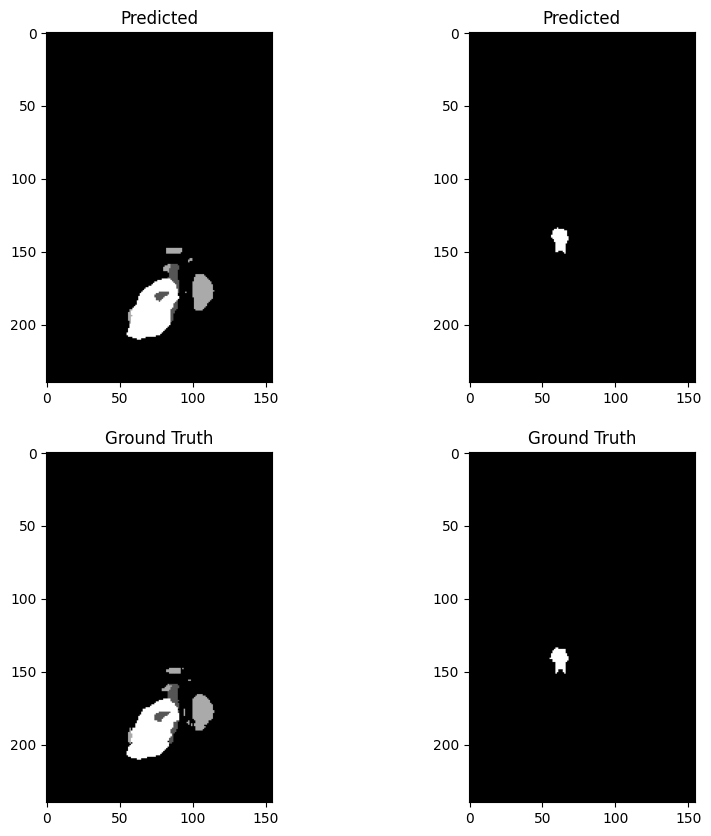

100%|██████████| 156/156 [15:38<00:00,  6.02s/it]



Average Training Loss: 0.00463315654390802

Average Training DSC: [0.99948796 0.95388173 0.95559945 0.84150213]
Average Training ASSD: [ 0.04686508  2.62022589  6.59359268 21.15385752]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


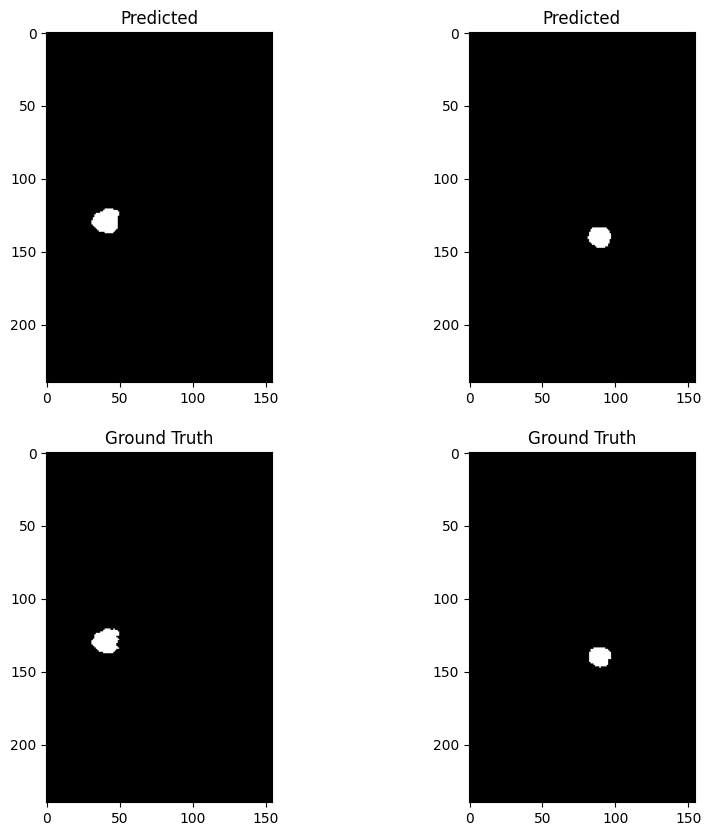

100%|██████████| 39/39 [03:43<00:00,  5.74s/it]


Average Validation Loss: 0.009370534107662164

Average Validation DSC: [0.99919835 0.9108339  0.9490643  0.80835306]
Average Validation ASSD: [ 0.08279648 13.65713249  7.55578174 17.53791561]
Epoch 92/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


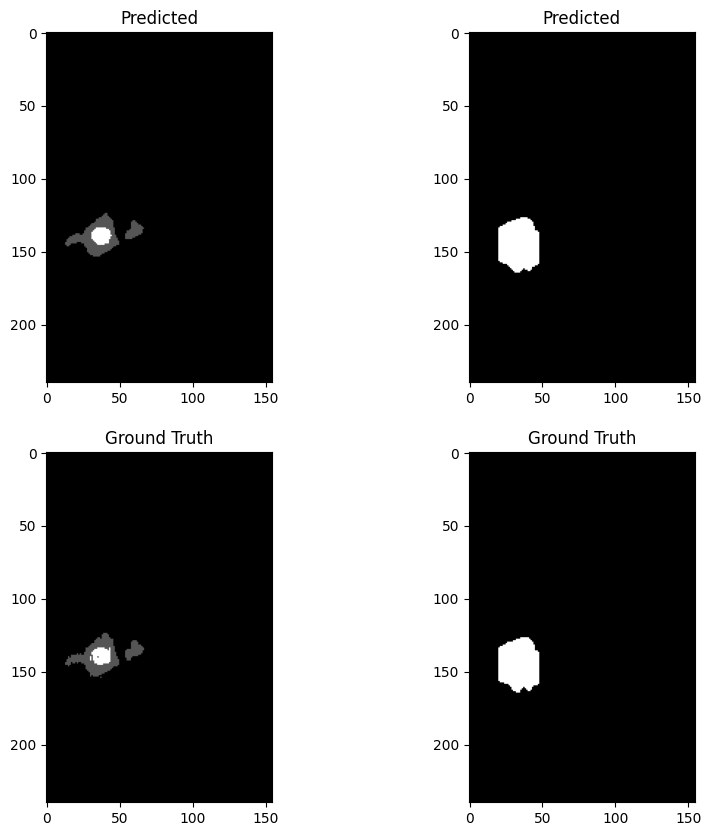

100%|██████████| 156/156 [15:46<00:00,  6.07s/it]



Average Training Loss: 0.00455794725059651

Average Training DSC: [0.99949463 0.95532872 0.95525678 0.84407631]
Average Training ASSD: [ 0.04651467  2.32612749  6.54879906 21.39866457]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


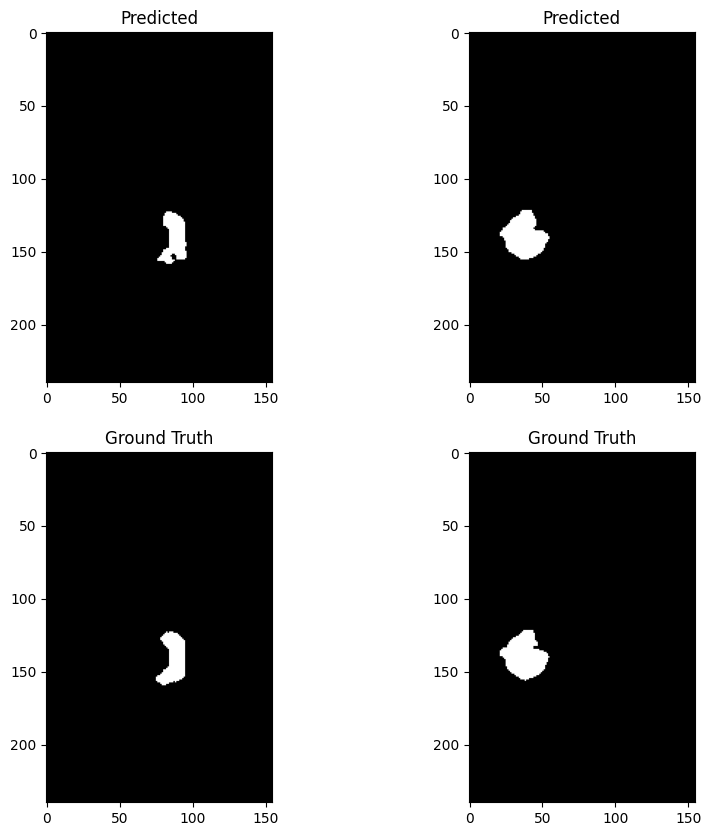

100%|██████████| 39/39 [03:24<00:00,  5.25s/it]


Average Validation Loss: 0.00984064613779386

Average Validation DSC: [0.99920323 0.91300624 0.95175229 0.79679298]
Average Validation ASSD: [ 0.08260633 13.72661084  6.92851674 21.02405305]
Epoch 93/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


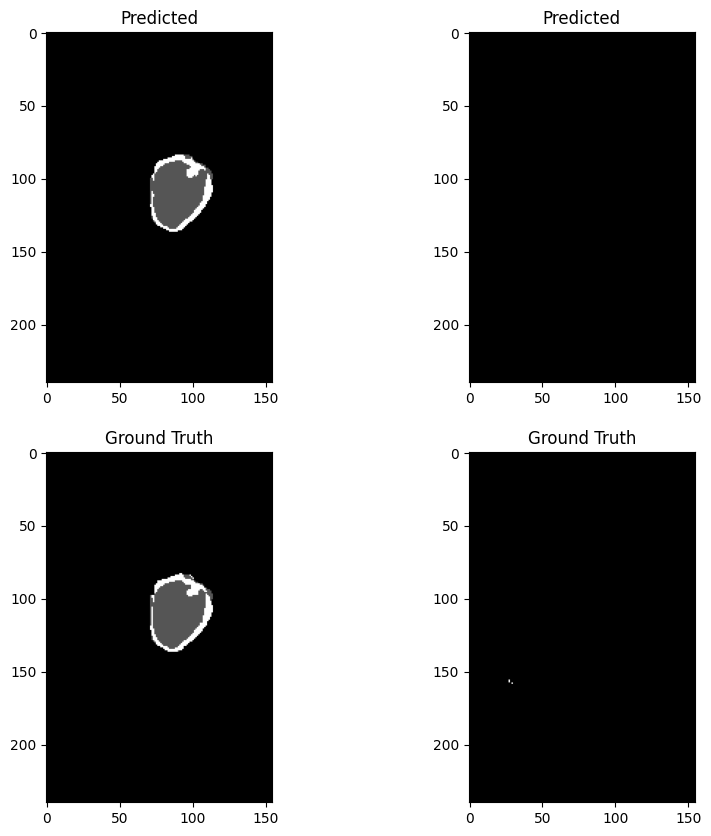

100%|██████████| 156/156 [15:37<00:00,  6.01s/it]



Average Training Loss: 0.004510674418177074

Average Training DSC: [0.99950582 0.95530533 0.95683881 0.84723261]
Average Training ASSD: [ 0.04515041  2.39845589  5.87808483 19.85914603]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


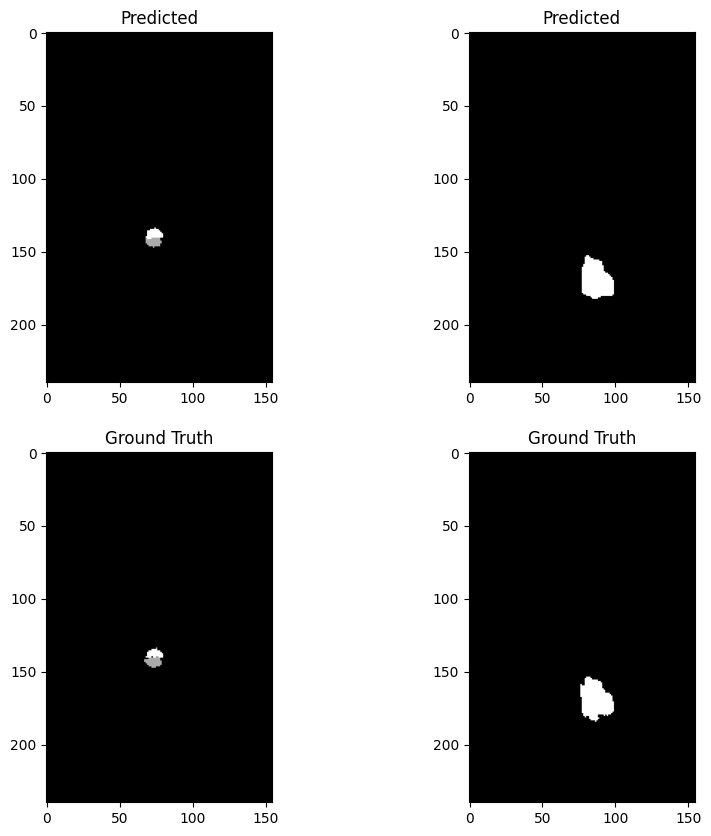

100%|██████████| 39/39 [03:48<00:00,  5.86s/it]


Average Validation Loss: 0.009465225625974245

Average Validation DSC: [0.99920528 0.90926422 0.95466151 0.80503031]
Average Validation ASSD: [ 0.08304165 15.38284169  5.11275717 19.00351939]
Epoch 94/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


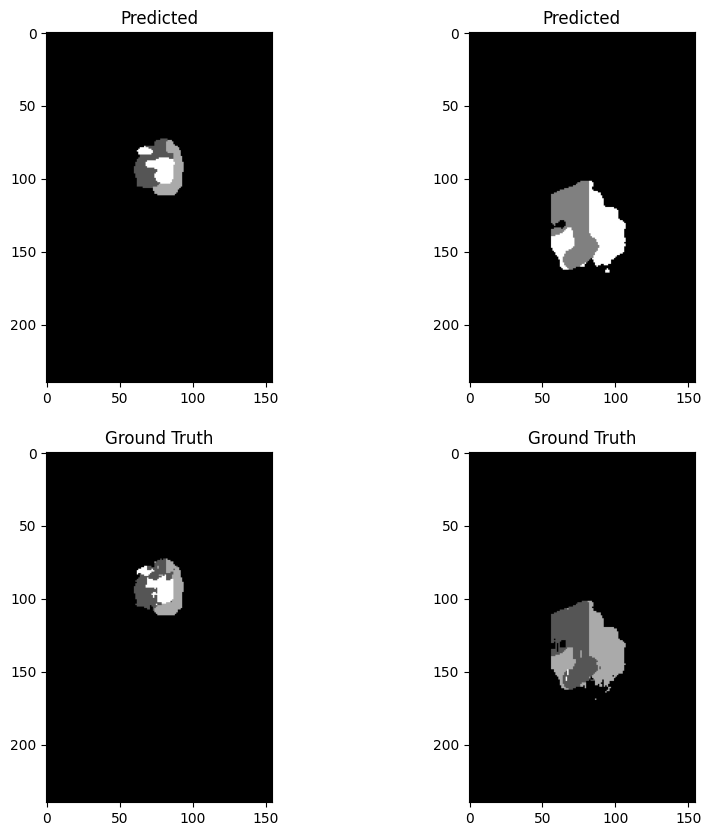

100%|██████████| 156/156 [15:45<00:00,  6.06s/it]



Average Training Loss: 0.0045443426934070885

Average Training DSC: [0.99949659 0.95332041 0.9556962  0.84514648]
Average Training ASSD: [ 0.04639321  2.64386037  6.69901781 19.99673915]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


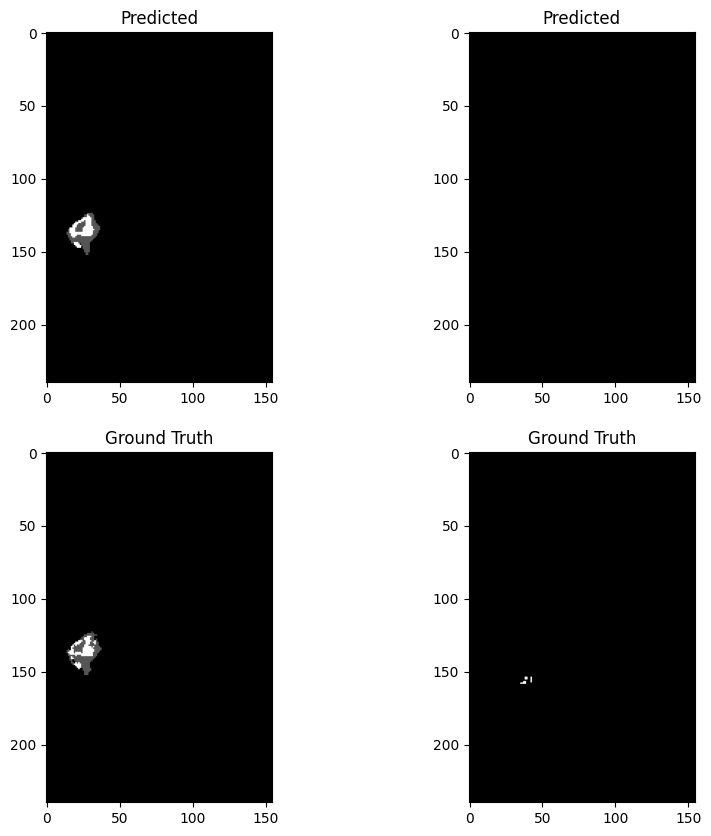

100%|██████████| 39/39 [03:27<00:00,  5.31s/it]


Average Validation Loss: 0.009447306943818545

Average Validation DSC: [0.99919661 0.90999074 0.9477462  0.8054919 ]
Average Validation ASSD: [ 0.08098078 14.82770887  7.83113562 19.26666532]
Epoch 95/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


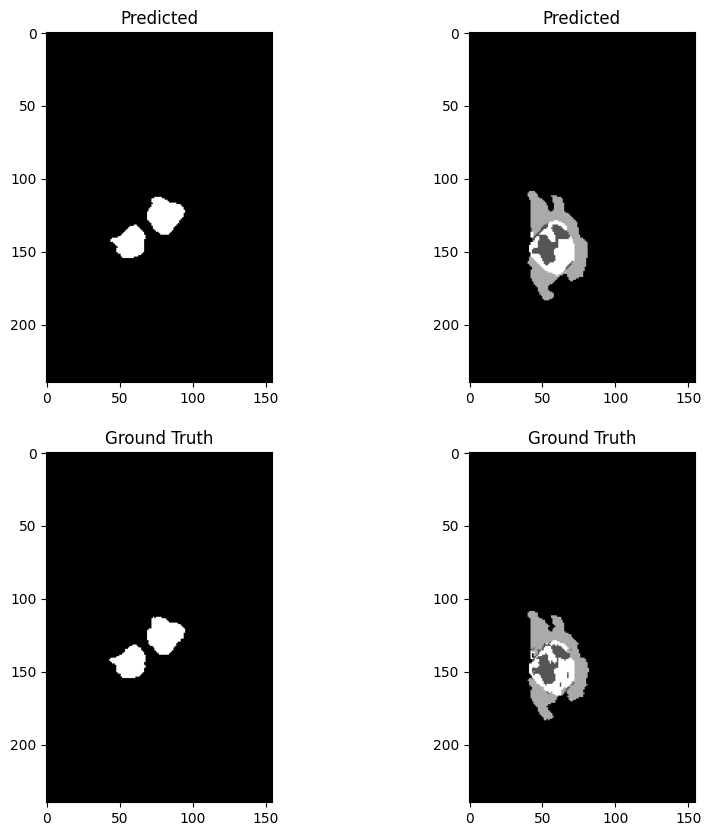

100%|██████████| 156/156 [14:33<00:00,  5.60s/it]



Average Training Loss: 0.004414212643706168

Average Training DSC: [0.9995094  0.95465258 0.95768556 0.84914707]
Average Training ASSD: [ 0.04479844  3.04365412  5.93932328 20.15309497]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


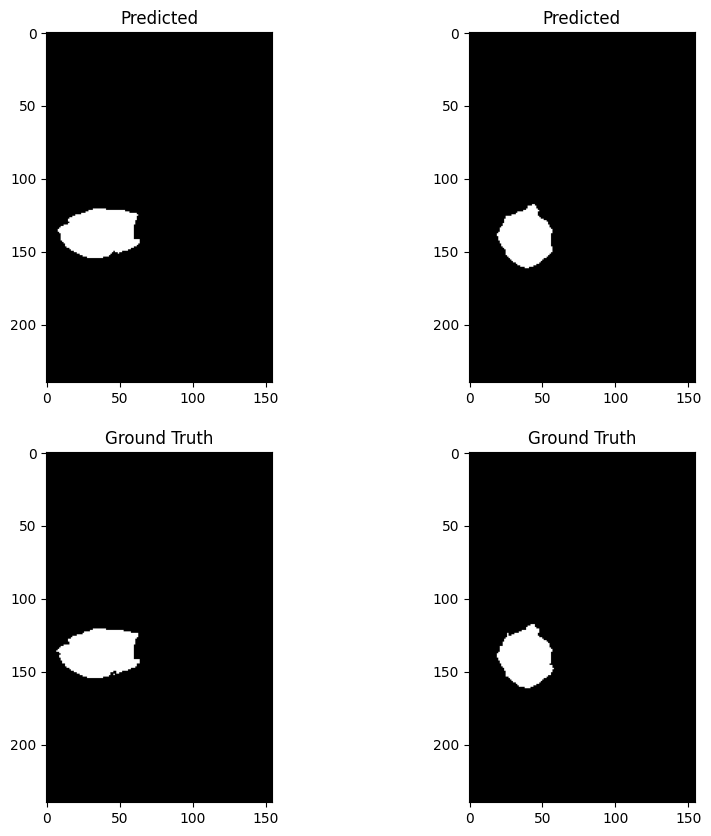

100%|██████████| 39/39 [03:51<00:00,  5.93s/it]


Average Validation Loss: 0.009635849975240536

Average Validation DSC: [0.99921072 0.91276398 0.95418164 0.80941278]
Average Validation ASSD: [ 0.08105408 14.82597725  6.5731255  19.81446841]
Epoch 96/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


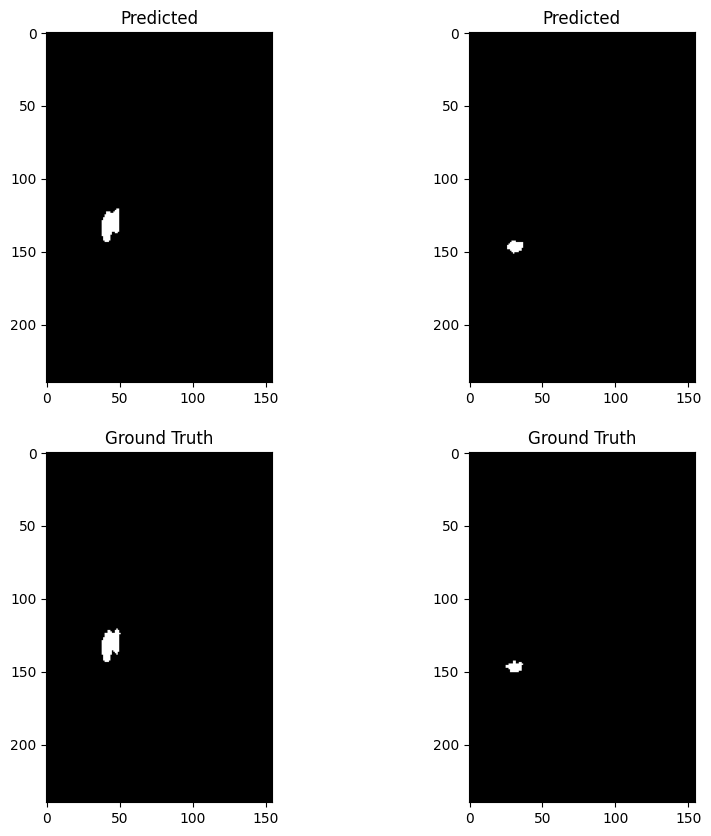

100%|██████████| 156/156 [15:05<00:00,  5.80s/it]



Average Training Loss: 0.004365362206067986

Average Training DSC: [0.99951254 0.95629916 0.95827108 0.85004555]
Average Training ASSD: [ 0.04380675  2.45964796  6.00240577 19.94689463]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


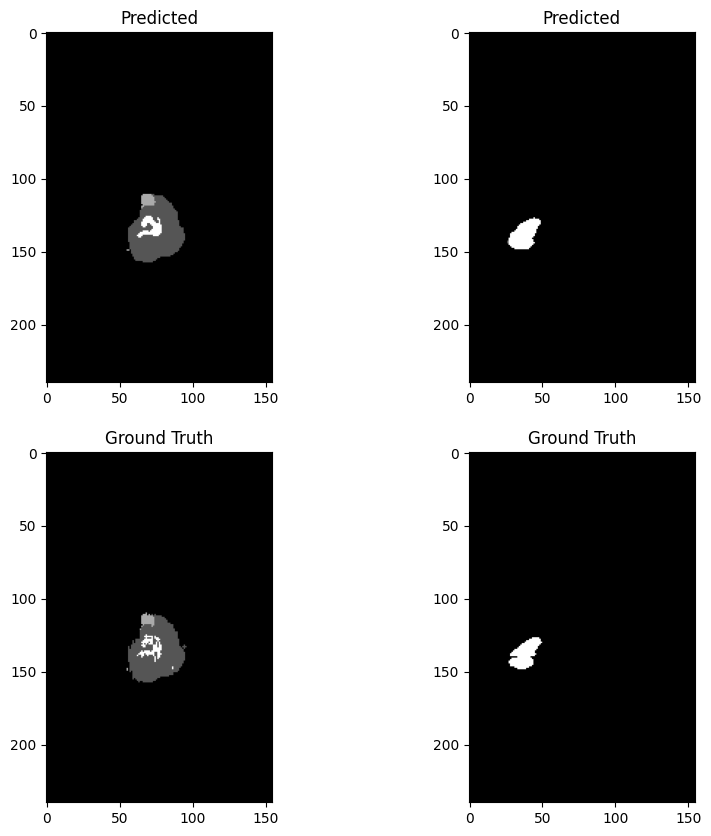

100%|██████████| 39/39 [03:53<00:00,  5.98s/it]


Average Validation Loss: 0.009560650763794398

Average Validation DSC: [0.99922902 0.9041507  0.95092011 0.8081297 ]
Average Validation ASSD: [ 0.08183405 18.25149858  6.91870882 18.64231302]
Epoch 97/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


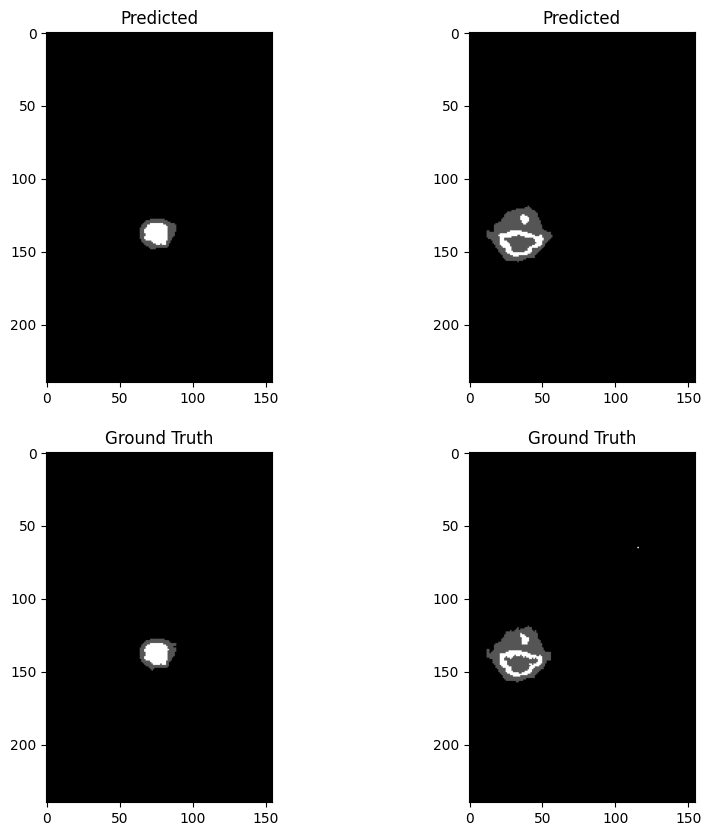

100%|██████████| 156/156 [15:33<00:00,  5.99s/it]



Average Training Loss: 0.004869695585698654

Average Training DSC: [0.99945937 0.94368668 0.95264475 0.8389224 ]
Average Training ASSD: [ 0.0502347   5.67252517  7.53647925 19.76987297]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


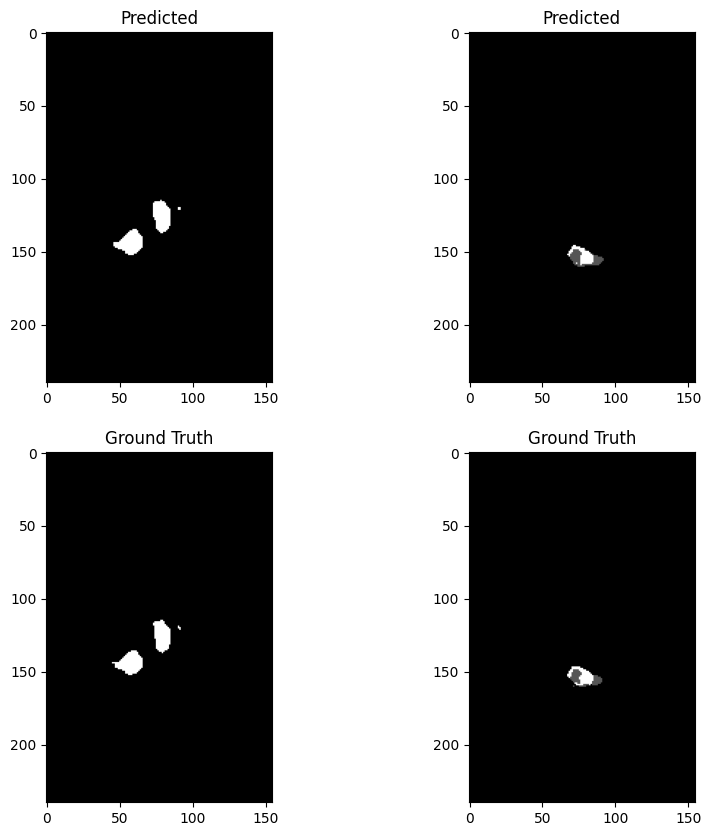

100%|██████████| 39/39 [03:41<00:00,  5.68s/it]


Average Validation Loss: 0.010134786343536316

Average Validation DSC: [0.99912266 0.89298615 0.94147123 0.78968836]
Average Validation ASSD: [ 0.08969745 20.40962034  9.19647776 20.36052675]
Epoch 98/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


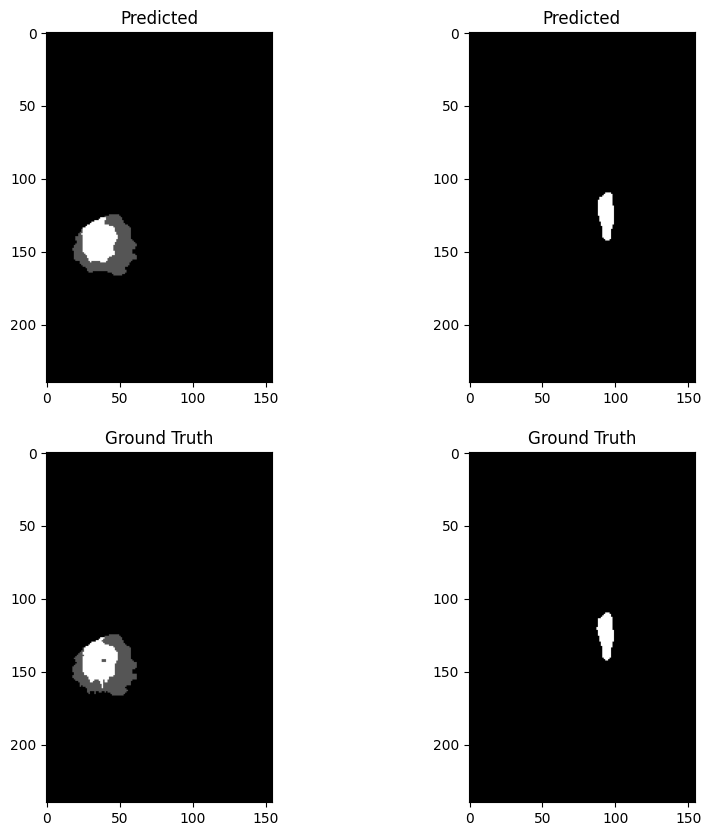

100%|██████████| 156/156 [15:00<00:00,  5.77s/it]



Average Training Loss: 0.005260963391405172

Average Training DSC: [0.99940887 0.93213324 0.94777887 0.82992716]
Average Training ASSD: [ 0.05577407  8.74495256  8.85593483 20.3796928 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


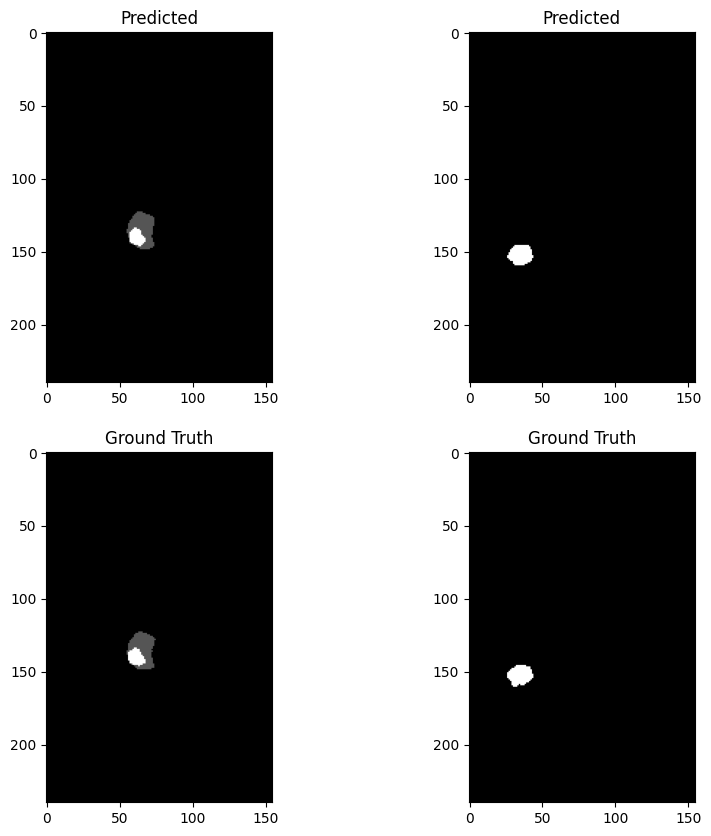

100%|██████████| 39/39 [03:19<00:00,  5.13s/it]


Average Validation Loss: 0.010074425679750932

Average Validation DSC: [0.99908438 0.89449516 0.94093846 0.76008125]
Average Validation ASSD: [ 0.09868368 16.72072511  7.52839418 23.84578369]
Epoch 99/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


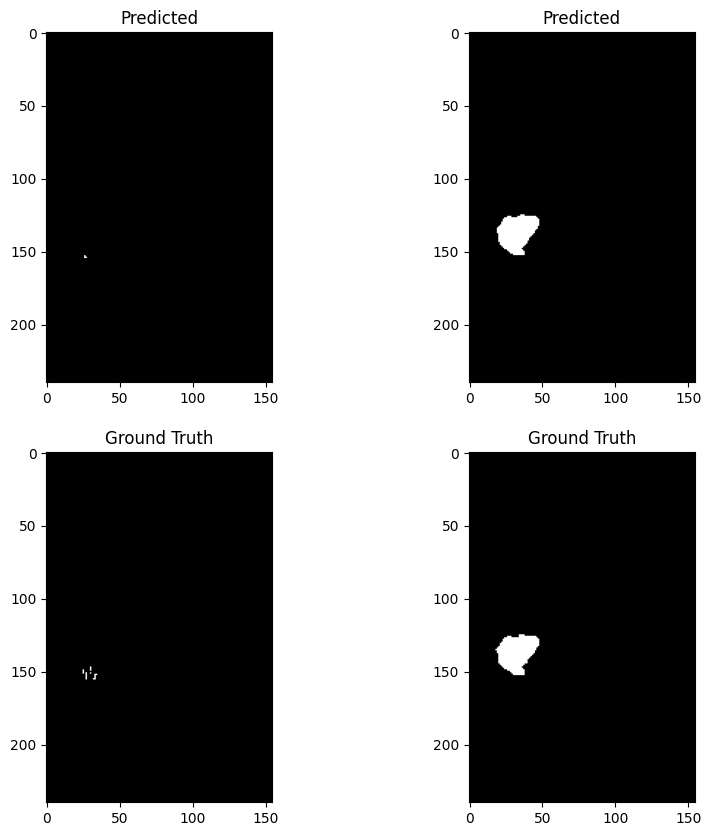

100%|██████████| 156/156 [15:53<00:00,  6.11s/it]



Average Training Loss: 0.005990122716563444

Average Training DSC: [0.99933675 0.9189524  0.94021423 0.814502  ]
Average Training ASSD: [ 0.06466746 12.26245998 10.46350741 19.80892666]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


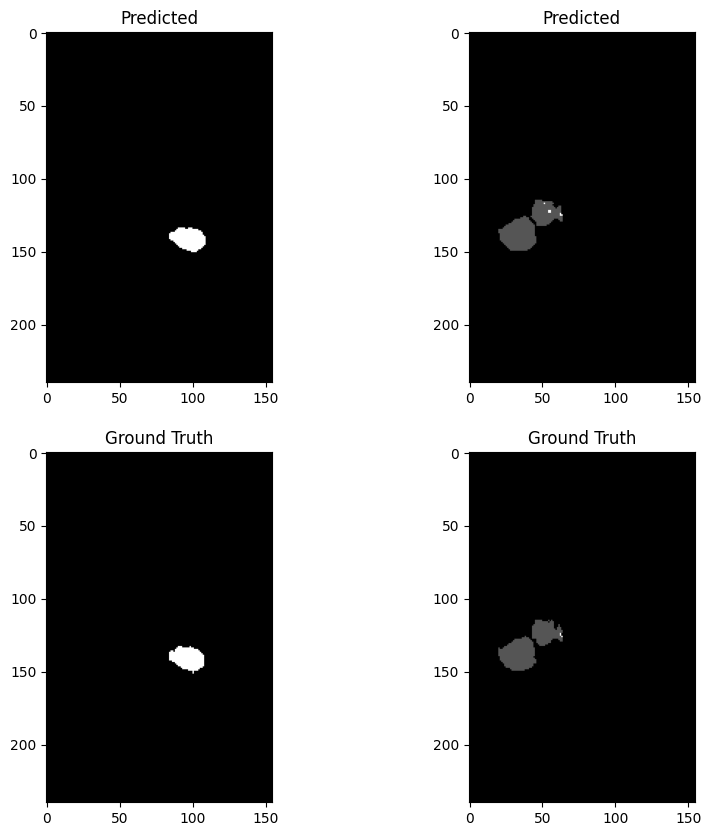

100%|██████████| 39/39 [03:50<00:00,  5.91s/it]


Average Validation Loss: 0.010543350010919265

Average Validation DSC: [0.99894785 0.88055745 0.92431012 0.76521249]
Average Validation ASSD: [ 0.12079383 22.18147485 13.88919364 19.62710999]
Epoch 100/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


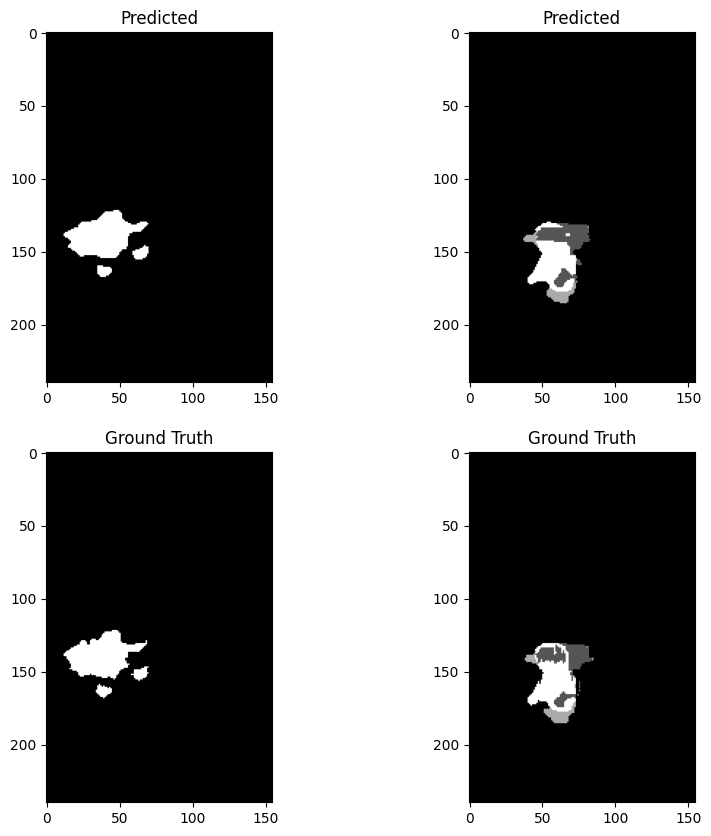

100%|██████████| 156/156 [15:48<00:00,  6.08s/it]



Average Training Loss: 0.006287577939637674

Average Training DSC: [0.99929341 0.92087731 0.93974466 0.80808829]
Average Training ASSD: [ 0.07060036 10.55171675 10.55481879 21.39278638]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


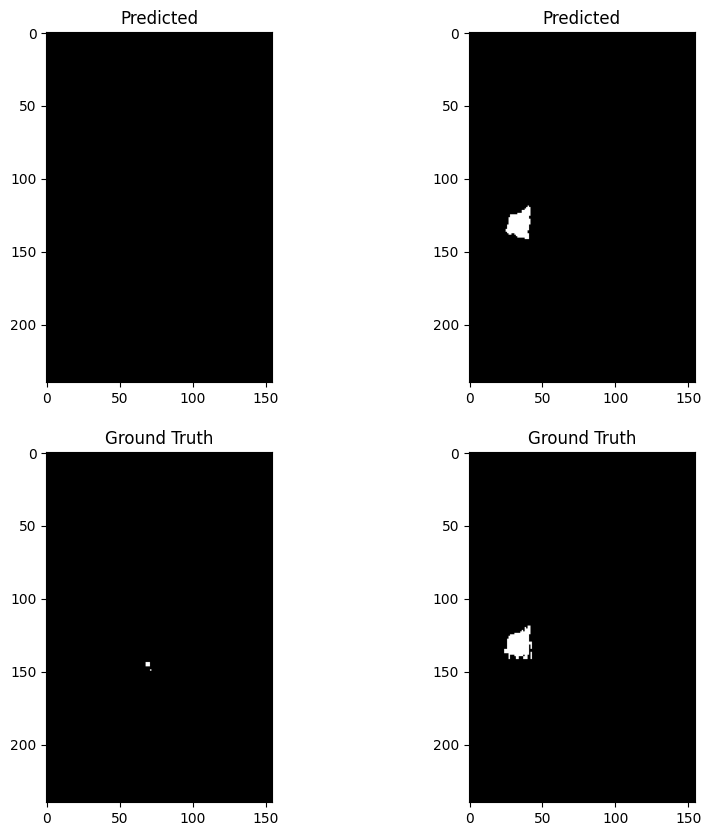

100%|██████████| 39/39 [03:24<00:00,  5.24s/it]


Average Validation Loss: 0.011304229844170503

Average Validation DSC: [0.99893561 0.80190247 0.91647982 0.75913744]
Average Validation ASSD: [ 0.1150358  50.99551185 17.10862981 25.67071053]


In [11]:
model = train_model(num_epochs = 100)